## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [231]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [232]:
# Opening JSON file 
f = open("complaints-2021-05-14_08_16.json","r")
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [233]:
# Inspect the dataframe to understand the given data.
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [234]:
#print(df["_source.company_public_response"].value_counts())
#print(df["_source.tags"].value_counts())
print(df["_source.sub_product"].value_counts())
#print(df["_source.sub_issue"].value_counts())

Checking account                              17182
General-purpose credit card or charge card    10504
Other mortgage                                 8447
Conventional fixed mortgage                    4892
Credit reporting                               4172
                                              ...  
Government benefit payment card                   4
Gift or merchant card                             4
Medical debt                                      2
ID prepaid card                                   2
Electronic Benefit Transfer / EBT card            1
Name: _source.sub_product, Length: 72, dtype: int64


In [235]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [236]:
#Assign new column names
# For simplicity and avoiding "." values in column, let us remove '^_|_source.' from column names. 

newcols = [ y.replace('source.','',1) for y in [ x.replace('_','',1) for x in df.columns ]]    
df.columns = newcols
print(df.columns)

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [237]:
# let us check shape of the dataframe
print(df.shape)
print(df.isnull().values.any())
print(df.isnull().values.sum())

(78313, 22)
True
212346


In [238]:
# let us check non-numerical columns
df.describe(exclude="number")

index       type      id            tags zip_code  \
count                 78313      78313   78313           10900    71556   
unique                    1          1   78313               3     9442   
top     complaint-public-v2  complaint  402412  Older American    606XX   
freq                  78313      78313       1            6103      472   

       complaint_id                                    issue  \
count         78313                                    78313   
unique        78313                                      154   
top          402412  Loan modification,collection,foreclo...   
freq              1                                     9743   

                    date_received  state consumer_disputed  ...  \
count                       78313  76322             78313  ...   
unique                       3444     62                 3  ...   
top     2015-08-27T12:00:00-05:00     CA               N/A  ...   
freq                           82  14009             35683  ...   

               company_response               company submitted_via  \
count                     78313                 78313         78313   
unique                        8                     1             6   
top     Closed with explanation  JPMORGAN CHASE & CO.           Web   
freq                      60230                 78313         47972   

             date_sent_to_company                  company_public_response  \
count                       78313                                        4   
unique                       3309                                        3   
top     2012-06-21T12:00:00-05:00  Company has responded to the consume...   
freq                          105                                        2   

             sub_product timely complaint_what_happened  \
count              67742  78313                   78313   
unique                72      2                   20931   
top     Checking account    Yes                           
freq               17182  78217                   57241   

                                      sub_issue consumer_consent_provided  
count                                     32016                     77305  
unique                                      205                         5  
top     Credit card company isn't resolving ...                       N/A  
freq                                       2904                     42847  

[4 rows x 21 columns]

In [239]:
# Do we have Duplicate records ?
n_duplicates = df.drop(labels=['id'],axis=1).duplicated().sum()
print(n_duplicates)

# conclusion - no duplicates, unique IDs

0


In [240]:
# drop columns with only 1 or less type of value in addition to few more not adding value to analysis.
cols_valcounts = {}
col_valcounts = { cols:df[cols].unique() for cols in df.columns }
cols_to_drop = [ col for col,val in col_valcounts.items() if len(val) <=1 ]
print(len(cols_to_drop), cols_to_drop)

4 ['index', 'type', 'score', 'company']


In [241]:
for each_col in cols_to_drop:
    print("---%s---".format(each_col))
    print(df[each_col].value_counts())

---%s---
complaint-public-v2    78313
Name: index, dtype: int64
---%s---
complaint    78313
Name: type, dtype: int64
---%s---
0.0    78313
Name: score, dtype: int64
---%s---
JPMORGAN CHASE & CO.    78313
Name: company, dtype: int64


In [242]:
# Let us drop above 4 columns in cols_to_drop given they have unique values and don't add any new info in learning
df = df.drop(columns=cols_to_drop)

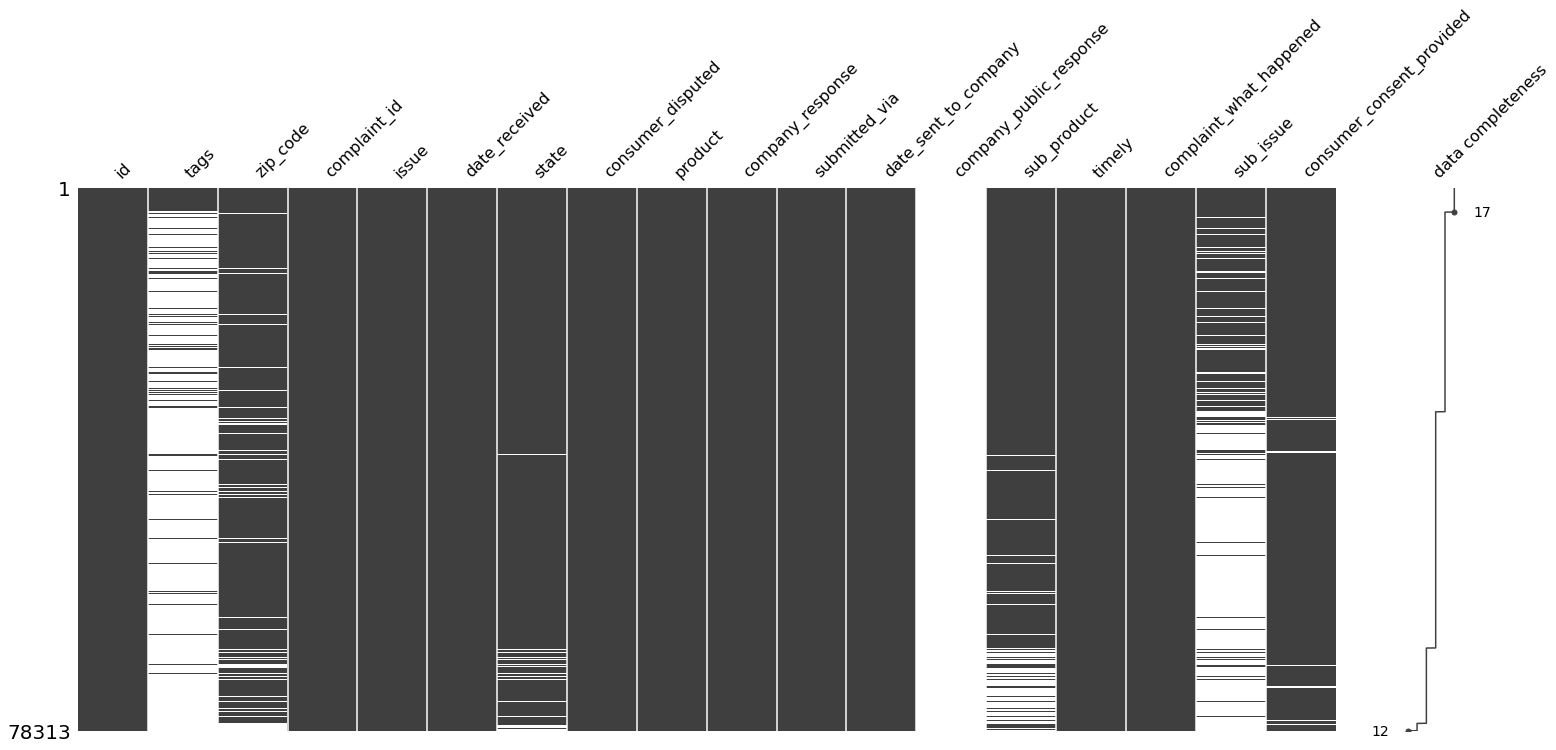

In [243]:
# Let us find any missing values across features for samples - horizontal investigation
import missingno as msno
msno.matrix(df,labels=True,sort="descending")

In [244]:
df["tags"].value_counts()

Older American                   6103
Servicemember                    3759
Older American, Servicemember    1038
Name: tags, dtype: int64

In [245]:
df["sub_issue"].isnull().value_counts()

True     46297
False    32016
Name: sub_issue, dtype: int64

In [246]:
df["sub_product"].isnull().value_counts()

False    67742
True     10571
Name: sub_product, dtype: int64

In [247]:
df["sub_product"].value_counts()

Checking account                              17182
General-purpose credit card or charge card    10504
Other mortgage                                 8447
Conventional fixed mortgage                    4892
Credit reporting                               4172
                                              ...  
Government benefit payment card                   4
Gift or merchant card                             4
Medical debt                                      2
ID prepaid card                                   2
Electronic Benefit Transfer / EBT card            1
Name: sub_product, Length: 72, dtype: int64

In [248]:
df["company_public_response"].value_counts()

Company has responded to the consumer and the CFPB and chooses not to provide a public response    2
Company believes complaint relates to a discontinued policy or procedure                           1
Company chooses not to provide a public response                                                   1
Name: company_public_response, dtype: int64

In [249]:
df["zip_code"].value_counts()

606XX    472
112XX    395
900XX    383
100XX    372
770XX    325
        ... 
87710      1
32043      1
94108      1
13433      1
33549      1
Name: zip_code, Length: 9442, dtype: int64

In [250]:
df["state"].isnull().value_counts()

False    76322
True      1991
Name: state, dtype: int64

In [251]:
df["consumer_consent_provided"].value_counts()

N/A                     42847
Consent provided        21077
Consent not provided    12285
Other                     991
Consent withdrawn         105
Name: consumer_consent_provided, dtype: int64

In [252]:
# Based on above values seen , let us handle features with null values as below :  
# 1. "tags" =>  only 10-15% values are non-Null, so we should drop this feature
# 2. "sub_issue" => 50% of the values are null, let us replace Null values as "unknown"
# 3. "sub_product" => Only 10% data is missing i.e. has null values, let us replace NULL values as "unknown"
# 4. "company_public_response" => only 4 rows have value, let us drop it
# 5. "zip_code" => 6K+ rows don't have zip code, let us replace it as "000XX"
# 6. "state" => only 1991 rows don't have state defined, let us replace them as "unknown"
# 7. "consumer_consent_provided" => small #s are null values, let us replace them as "unknown"

In [253]:
df = df.drop(columns=["tags","company_public_response"])
df["sub_issue"] = df["sub_issue"].fillna("unknown")
df["sub_product"] = df["sub_product"].fillna("unknown")
df["zip_code"] = df["zip_code"].fillna("000XX")
df["state"] = df["state"].fillna("unknown")
df["consumer_consent_provided"] = df["consumer_consent_provided"].fillna("unknown")

In [254]:
df.isnull().sum()

id                           0
zip_code                     0
complaint_id                 0
issue                        0
date_received                0
state                        0
consumer_disputed            0
product                      0
company_response             0
submitted_via                0
date_sent_to_company         0
sub_product                  0
timely                       0
complaint_what_happened      0
sub_issue                    0
consumer_consent_provided    0
dtype: int64

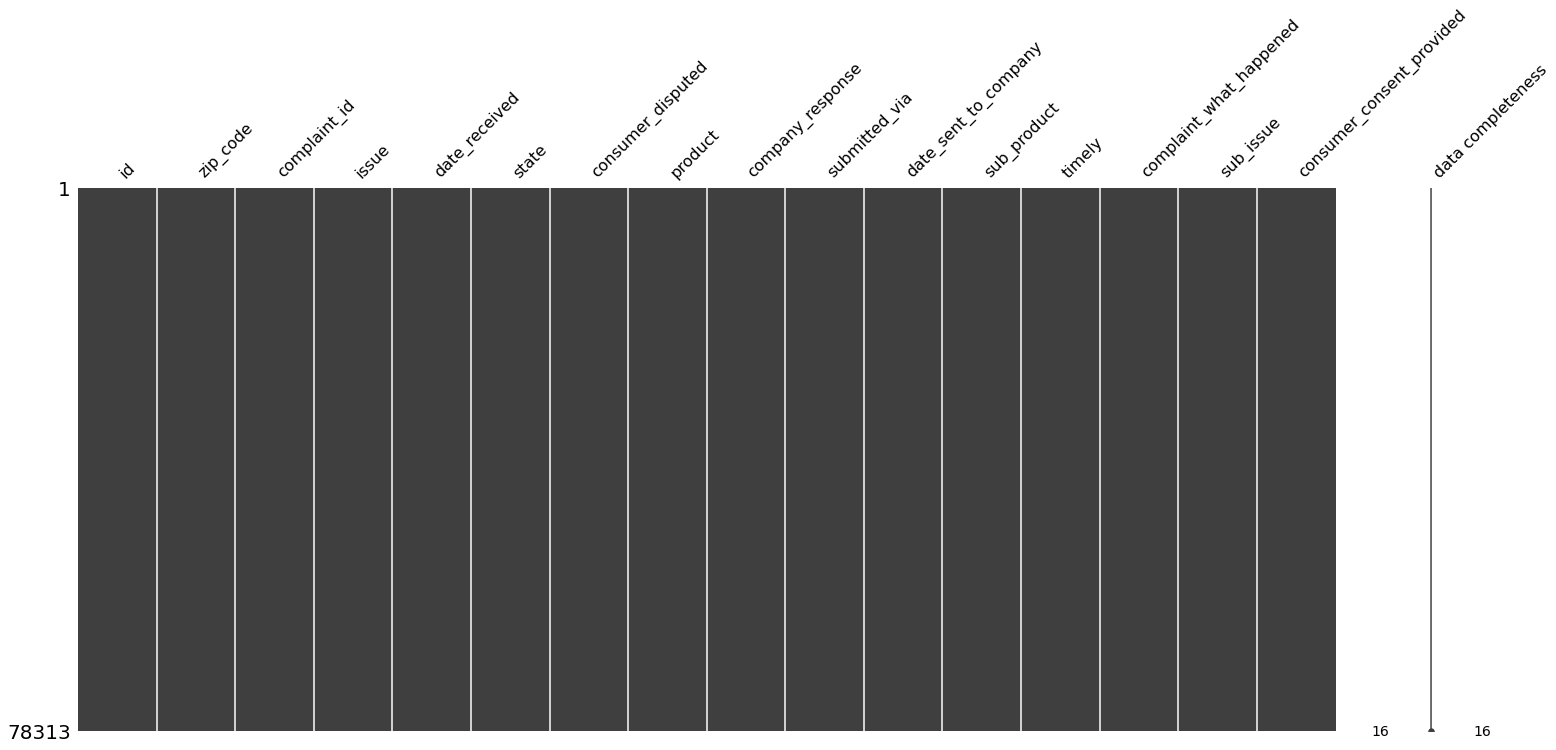

In [255]:
msno.matrix(df,labels=True,sort="descending")

In [256]:
df["issue"].isnull().value_counts()
df["complaint_what_happened"].isnull().value_counts()

print(df["complaint_what_happened"])
print(df["complaint_what_happened"].isnull().value_counts())
df = df.rename(columns={"complaint_what_happened":"complaints"})

0                                               
1        Good morning my name is XXXX XXXX an...
2        I upgraded my XXXX XXXX card in XX/X...
3                                               
4                                               
                          ...                   
78308                                           
78309    On Wednesday, XX/XX/XXXX I called Ch...
78310    I am not familiar with XXXX pay and ...
78311    I have had flawless credit for 30 yr...
78312    Roughly 10+ years ago I closed out m...
Name: complaint_what_happened, Length: 78313, dtype: object
False    78313
Name: complaint_what_happened, dtype: int64


In [257]:
#Assign nan in place of blanks in the complaints column
df["complaints"] = df["complaints"].replace(r'^\s+$', np.nan, regex=True)
df["complaints"] = df["complaints"].replace(r'^$', np.nan, regex=True)

In [258]:
#Remove all rows where complaints column is nan
print(df["complaints"])
print(df["complaints"].isnull().value_counts())
#df["complaints"] = df["complaints"].dropna()
df = df.dropna()
print(df["complaints"].isnull().value_counts())



0                                            NaN
1        Good morning my name is XXXX XXXX an...
2        I upgraded my XXXX XXXX card in XX/X...
3                                            NaN
4                                            NaN
                          ...                   
78308                                        NaN
78309    On Wednesday, XX/XX/XXXX I called Ch...
78310    I am not familiar with XXXX pay and ...
78311    I have had flawless credit for 30 yr...
78312    Roughly 10+ years ago I closed out m...
Name: complaints, Length: 78313, dtype: object
True     57241
False    21072
Name: complaints, dtype: int64
False    21072
Name: complaints, dtype: int64


In [259]:
print(df.info())
print(df.isnull().sum())
print(df["complaints"])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         21072 non-null  object
 1   zip_code                   21072 non-null  object
 2   complaint_id               21072 non-null  object
 3   issue                      21072 non-null  object
 4   date_received              21072 non-null  object
 5   state                      21072 non-null  object
 6   consumer_disputed          21072 non-null  object
 7   product                    21072 non-null  object
 8   company_response           21072 non-null  object
 9   submitted_via              21072 non-null  object
 10  date_sent_to_company       21072 non-null  object
 11  sub_product                21072 non-null  object
 12  timely                     21072 non-null  object
 13  complaints                 21072 non-null  object
 14  sub_is

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [260]:
# Write your function here to clean the text and remove all the unnecessary elements.

import contractions
import string


# Lower case and replace \n i.e. newline charater
df["clean_complaints_1"] = df["complaints"].str.lower().astype('str')
df["clean_complaints_2"] = df["clean_complaints_1"].str.replace('\n', ' ')

# Let us expand english contractions e.g. I've 
df["clean_complaints_3"] = df["clean_complaints_2"].apply(lambda x: contractions.fix(x))

# remove words in square brackets as mentioned in the exercise
df["clean_complaints_4"] = df["clean_complaints_3"].str.replace(r'\b\[.*?\]\b','',regex=True).astype('string')

# remove all punctuation charaters
df["clean_complaints_5"] = df["clean_complaints_4"].str.replace(r'[^\w\s]+','',regex=True).astype('string')

# remove all words with digits in those.
df["clean_complaints_6"] = df["clean_complaints_5"].str.replace(r'\b\w*\d+\w*\b','',regex=True).astype('string')


# remove one or more blank charaters from start and end of document
df["clean_complaints_7"] = df["clean_complaints_6"].str.replace(r'^\s+|\s+$','',regex=True).astype('string')


# compress multiple blank charaters in succession into a single space charater
df["clean_complaints"] = df["clean_complaints_7"].str.replace(r'\s+',' ',regex=True).astype('string')

# Let us drop all interim columns we prepared above, they were created due to jupyter bug of not handling 
# multiple regex operations correctly
df = df.drop(columns=["clean_complaints_1", "clean_complaints_2", 
                      "clean_complaints_3", "clean_complaints_4", 
                      "clean_complaints_5", "clean_complaints_6", "clean_complaints_7" ])

print(df.columns)

Index(['id', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state',
       'consumer_disputed', 'product', 'company_response', 'submitted_via',
       'date_sent_to_company', 'sub_product', 'timely', 'complaints',
       'sub_issue', 'consumer_consent_provided', 'clean_complaints'],
      dtype='object')


In [261]:
pd.set_option('display.max_colwidth', None)
print(df["clean_complaints"] )
pd.set_option('display.max_colwidth', 40)

1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [262]:
#Write your function to Lemmatize the texts
nlp = spacy.load("en_core_web_sm")

def pos_lemmatize(row):
    # Accept each row i.e. series and fidn lemma_ and pos_ for each row i.e. complaint
    # returns : lemma and pos for each complaint
    
    nlp_list = nlp(row.values[0])
    x = " ".join([w.lemma_ for w in nlp_list])
    y = " ".join([w.pos_ for w in nlp_list])
    return x, y

# temp copy of one column only
df_temp = df[["clean_complaints"]].copy()

df_temp[['clean_complaints_lemma', 'clean_complaints_pos']] = df_temp.apply(
    lambda row: pd.Series(pos_lemmatize(row)), axis=1
)
print(df_temp)

                              clean_complaints  \
1      good morning my name is xxxx xxxx an...   
2      i upgraded my xxxx xxxx card in and ...   
10     chase card was reported on however f...   
11     on while trying to book a xxxx xxxx ...   
14     my grand son give me check for i dep...   
...                                        ...   
78303  after being a chase card customer fo...   
78309  on wednesday xxxxxxxx i called chas ...   
78310  i am not familiar with xxxx pay and ...   
78311  i have had flawless credit for yrs i...   
78312  roughly years ago i closed out my ac...   

                        clean_complaints_lemma  \
1      good morning my name be xxxx xxxx an...   
2      I upgrade my xxxx xxxx card in and b...   
10     chase card be report on however frau...   
11     on while try to book a xxxx xxxx tic...   
14     my grand son give I check for I depo...   
...                                        ...   
78303  after be a chase card customer for w...   

In [263]:
df_temp.to_csv("df_temp.csv")

In [264]:
df_temp = pd.read_csv("df_temp.csv",header=0,index_col=0)
df_temp.index.name = "Id"
df_temp = df_temp.reset_index()
df_temp.index.name = "row_number"

In [265]:
print(df_temp)

               Id                         clean_complaints  \
row_number                                                   
0               1  good morning my name is xxxx xxxx an...   
1               2  i upgraded my xxxx xxxx card in and ...   
2              10  chase card was reported on however f...   
3              11  on while trying to book a xxxx xxxx ...   
4              14  my grand son give me check for i dep...   
...           ...                                      ...   
21067       78303  after being a chase card customer fo...   
21068       78309  on wednesday xxxxxxxx i called chas ...   
21069       78310  i am not familiar with xxxx pay and ...   
21070       78311  i have had flawless credit for yrs i...   
21071       78312  roughly years ago i closed out my ac...   

                             clean_complaints_lemma  \
row_number                                            
0           good morning my name be xxxx xxxx an...   
1           I upgrade my xxx

In [266]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df_temp[['Id', 'clean_complaints', 'clean_complaints_lemma']]

In [267]:
#Write your function to extract the POS tags 

def pos_tag(text):
  # write your code here
    lem = str(text["clean_complaints_lemma"])
    pos = str(text["clean_complaints_pos"])
 
    # in case, field is blank or nan, let us drop it by converting it as NOUN / unknown
    if(pos == "" or pos == np.nan or pos == "nan"): 
        pos = "UNK"
    if(lem == "" or lem == np.nan or lem == "nan"):
        lem = "unknown"
    
    idx_list = [ idx for idx,id in enumerate(pos.split(" ")) if id == 'NOUN' ]
    #print(idx_list)
    #print(lem)
    if(idx_list and len(idx_list) > 0):
        lem_list = [ lem.split()[each_idx] for each_idx in idx_list ] 
        #print(lem_list)
    else:
        lem_list_return = "unknown"
        return lem_list_return
    
    #print(lem_list)
   
    if(lem_list and len(lem_list) > 0):
        lem_list_return = " ".join(lem_list)
    else:
        lem_list_return = "unknown"
        
    print(lem_list_return)
    return lem_list_return

# temp copy of required columns only
df_temp_2 = df_temp[['clean_complaints_lemma', 'clean_complaints_pos']].copy()
        
#df_clean["complaint_POS_removed"] =  #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] = df_temp_2.apply(
    lambda row: pd.Series(pos_tag(row)), axis=1
)


morning name xxxx xxxx stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account thank advance help
morning name xxxx xxxx stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account thank advance help
card agent anniversary date agent information order account xxxx anniversary date xxxxxxxx consent xxxx recording agent
card application identity consent service credit identity applicant
xxxx ticket offer ticket reward card information offer minute screen decision bank notification screen chase representative application information offer credit offer account statement ticket account application representative application request application representative chase fact credit account name credit report chase information credit report application error
son check chase account fund chase account money son check money chase bank money son time check owner country 

xxxx xxxx office company office company entity owner entity bank chase xxxx xxxx bank contact relationship company location infrastructure bookkeeper xxxx relationship xxxx chase relationship xxxx xxxx xxxx xxxx line credit company tv commercial production oftentime equipment location advance deposit addition travel credit card xxxx money xxxx day solution touch xxxx xxxx bank company credit card card liability card liability card application phone call xxxx call xxxx xxxx process card company instance employee card name event kind default company word call xxxx application card date issue xxxx end xxxxxxxx office company part time bookkeeper company insolvency xxxx xxxx owner xxxx account balance week xxxx xxxx office xxxx xxxx part time bookkeeper one affair bank business xxxx xxxx basis checkbook card record chase business po box statement company address day office chase branch banking contact xxxx xxxx office bookkeeper signatory check card possession time xxxx banking matter leav

complaint case managment xxxx attention representative call xxxx voice mail xxxx xxxx noon xxxx xxxx xxxx voice mail xxxx xxxx voice message return voice message return call hour xxxx xxxx voice messsage return call call importance issue representive call behalf note date time message joke call door day day xxxx voice message xxxx tactic chase year head time environment top client file supervisor failure expectation phone call question representative
checking account explanation chase credit card issue credit card timeline note account denial xxxxxxxx client banker location account check checking account chase check chase credit card check deposit slip chase checking account xxxx account review reason idea boiler plate language document copy account alert screen shot application inquiry xxxxxxxx email email app app copy disclosure account note account document xxxxxxxx xxxx copy document printout deposit account agreement privacy account alert account xxxxxxxx email account tool xxxxxx

complaint manager home loan loan xxxx regard deference office interpretation email xxxx xxxx xxxx correspondence threat suit terseness narrative inference correspondence frustration interpretation deficiency candor process standard care loan advisor agent conduct email communication part record allegation business practice business practice sense standard care sense style scoutus following text principle t constitution voter word phrase meaning sprague gibbon ogden wheat meaning course meaning meaning citizen generation district obligation language state predicate obligation code procedure provision provision section twentysix obligation duty person thing contract operation law code amendment language state meaning term contract operation law code civ division obligagtion part obligation title definition obligation obligation duty person thing section obligation contract party operation law obligation operation law manner law action proceeding code amendment review event xxxxxxxx wife 

fraud investigator extension xxxx day employee message customer service customer service hold minute fraud department employee chase money customer service xxxx money contact xxxx xxxx instance department response drating xxxx xxxx complaint xxxx xxxx arrogance employee fraud department end conversation department mistake merchandise xxxx merchandise xxxx xxxx tracking number xxxx xxxx xxxx charge refund chase bank people job case merchandise xxxx xxxx chase problem xxxx date chase matter fraud department customer xxxx xxxx bank decency fraud investigator investigation card fee fee card merchant money chase money bank xxxx xxxx investigation professionalism chase employee customer access person investigation other customer wrong chase affidavit police report charge information police report class misdemeanor police report decision importance purchase credit card bank charge credit card purchase charge chase dollar merchandise item charge thing xxxx guy credit card address order address

variety credit card chase card card point reward order flight chase reward website representative purchase flight xxxx xxxx layover xxxx booking process upgrade class seat upgrade xxxx coach website upgrade legroom meal alcohol baggage check feature legroom meal reward representative upgrade flight xxxx wife year son seating arrangement flight perk legroom meal flight seat flight xxxx partner plane medium ability legroom seat drink meal food plane lot flight family misrepresentation chase reward airline change change fee flight home flight xxxx xxxx coach place cost seat research coach seating feature effort chase representative reward representative credit card response flight cabin feature website possibility flight option advertising flight accommodation none flight xxxx type accommodation way accommodation website supervising representative xxxx center compensation recourse concern xxxx day hold hour supervisor situation xxxx note supervisor complaint concern process hold hour indi

chase dept card day thief transaction xxxx average transaction card pin total police report day dispute letter xxxxxxxx claim transaction
chase charge day chance issue overdraft fee transaction transaction account xxxxxxxx xxxxxxxx reason time chase overdraft fee fee charge xxxx xxxxxxxx xxxx overdraft fee transaction overdraft fee other charge day chase bank fee stuff mistake case payment account pay period fee xxxx charge account xxxxxxxx xxxx chase overdraft fee transaction charge charge account payday month issue chase od fee incident
year flood insurance mortgage company flood map fraction home property area chance flood damage year mortgage payment reminder checking account check statement threatening notice need insurance clause law mortgage company homeowner escrow account insurance warning rate month threat progress flood insurance xxxx escrow year thing escrow year flood insurance year escrow escrow principal loan collection flood insurance force insurance company flood insur

xxxxxxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx issue care unit number day hospital place employment year lifechanging experience mortgage payment saving assistance home financing avail mortgage payment assistance bank home financing servicer participation agreement home modification program harp contract document exhibit information belief finance hamp contract xxxx xxxxxxxx knowledge assistance home finance result time chase telephone period time message representative service provider mailbox message addition chase statement document document home finance letter review record chase contact attempt order sale plaintiff recording story recording home finance plaintiff telephone number number plaintiff assistance practice document telephone conversation bank document relief sale mortgage relief home finance fact document document result bankruptcy property foreclosure request assistance documentation record statement document defendant mail mail mail home finance letter indication property

veteran award xxxx xxxx xxxx service xxxx xxxx year service discharge career xxxx xxxx standard regard light peer chain command purview business mortgage chase xxxx account credit report crisis month period unemployment job opening road support child time assistance family member way month xxxx xxxx xxxx career year xxxx ability obligation commitment path point decision bankruptcy attorney process lawyer field process problem matter tardiness matter control period time attempt department request fruition variety delay setback month time inability document delivery xxxx pause refinance attempt effort refinance department refinance service lady xxxx xxxx loan period time hit period time reason obligation family importance job job issue xxxx life saver point superior work life today loan term part trial period payment agreement appreciation time modification chase section xxxx payment interaction chase life opportunity mortgage xxxx year service group person time setup period time phone c

rent business office space landlord account chase pay xxxx company name pay page chasecom customer instruction page disclosure space name number email information name email notification day information state number landlord company transfer landlord xxxxxxxx fund money account inspection number chase day number way name landlord chase liability situation user error account information name phoneemail match fund claim resource information account holder number chase pay market way money protection event money person way process safety security verification account name type guarantee bank way money money person person money name bank money way check name address way xxxx case money contact information person money account xxxx order money tracking piece money marketing way money protection bank guarantee money person account copy transaction number recipient name
cfpb complaint xxxx date chase premier account money issue pay xxxx email address course transaction week chase transaction 

check amount xxxx injury payment insurance check account account number deposit back check thief name name address front check signature back check account number deposit check institution copy check xxxx check xxxxxxxx name signature check probability thief account number police report xxxx issue xxxx injury case manager process day xxxx package information investigation xxxxxxxx xxxx xxxx xxxx point contact xxxx xxxx xxxx time xxxx xxxx liaison followup issue process guidance supervisor followup update bank check outcome voice message xxxx xxxx information lack information wait time information point contact file number case information option point office consumer protection bureau complaint line office way name attorney area note check mailbox check property bank value mailbox
balance credit card order xxxxxxxx jxxxxxxxx order fraud fraud day chase credit card situation representative amount thing order xxxxxxxx order mail item store store credit credit card thing chase deduct cred

chase auto number xxxx billing extension month health hospital month extension extension date xxxx month xxxx payment date xxxx statement hospital agent statement emergency xxxx xxxx fee amount supervisor name i d xxxx payment fee date xxxx month supervisor xxxx situation account current date xxxx month extenuating circumstance credit fee total credit statement account payment supervisor credit date supervisor xxxx xxxx date xxxx month fee total chase honor supervisor fee date xxxx month agent extension payment xxxx xxxx agent name xxxx
year mortgage loan company error insurance lender insurance time policy year policy escrow policy mortgage payment insurance company bank fault policy xxxx bank policy xxxx escrow account mortgage statement amount escrow xxxx breach section respa complaint dozen violation law loan representation belief bank behavior representation damage cooperation authority victim law chase behavior predatory attorney general escrow statement proof doubt
xxxx issue xx

xxxx report inquiry credit chase amazon visa card fraud alert credit application xxxx xxxx inquiry credit chase amazon visa chase application representative information application affidavit file police report summary driver d step information class mail review ay request requirement website phone chase application hoop information application name information start phone call
xxxx pair concert ticket xxxx seat card concert xxxx xxxx ca ticket order number xxxx purchase t scheduling conflict concert ticket sale platform xxxx xxxx ticket xxxx concert section row seat xxxx ticket statement xxxx xxxx xxxx amount xxxx dispute charge credit card purpose week call fro xxxx claim xxxx sale tick et fro listing xxxx penalty fee ticket xxxx order receipt purchase sale information detail xxxx document xxxx voicemail call voicemail call charge account dispute xxxx xxxx attempt chase resolution dispute xxxx xxxx attempt chase t fund dispute documentation proof d chase recei xxxx order claim avail d

case number event bank wire daughter xxxx communication xxxx xxxx ad xxxx apartment xxxx xxxx number text xxxx text xxxx certificate ownership apartment complex xxxx order apartment xxxx apartment deposit account account number xxxx number xxxx monie account apartment xxxx text xxxx xxxx xxxx copy receipt xxxx daughter receipt bank wire xxxx monie wire transfer work work xxxx xxxx one key apartment xxxx phone apartment xxxx xxxx owner xxxx xxxx xxxx xxxx police station report office xxxx report xxxx xxxx phone car tomorrow show call monie claim money xxxx account friend xxxx xxxx picture people xxxx xxxx agent service xxxx picture name profile party tax i d claim money bank xxxx incident fund complaint case chase xxxx xxxx contact fraud department chase fraud wire department wire department account fund amount wire xxxx xxxx hrs bank wire recall wire department update xxxx hold letter representative care processing account fund amount wire department representative mama bank recall ban

privacy preference offer credit credit bureaus marketing material company business company business choice chase marketing material chase privacy preference mail name neighbor mail company ftc list dma optout database credit bureau database mail company
xxxx chase promotion xxxx xxxx purchase month companion pass xxxx point xxxx xxxx notification application credit card chase term offer chase offer xxxx xxxx deal
servicer sale package loss mitigation procedure complaint servicer loss mitigation application request violation b borrower writing day holiday saturday sunday loss mitigation application servicer receipt loss mitigation application servicer loss mitigation application loss mitigation application notice document information borrower loss mitigation application date paragraph section notice borrower statement borrower servicer mortgage loan property loss mitigation option today date servicer application document application xxxx package
credit card payment bill pay day day bill

trustee fact claim investor information xxxx xxxx xxxx business xxxxxxxx corporation commissioner identity bank xxxx xxxx xxxx employee xxxx employee xxxx xxxx position mortgage assignment fraud fraud contract fraud inclusion fraud concealment trust trust servicer mortgage assignment information investor xxxx xxxxxxxxxxxxhe case attachment resolution servicer mortgage investor proof payoff emc placexxxxxxxx xxxxxxxxa payment form money order xxxx attempt debt mortgage assignment action jurisdiction again bank personnel bond xxxx hall release mortgage assignment title release xxxx xxxx xxxx document xxxxxxxx recordedxxxxxxxx county registrar document nature lack information dollar amount date party debt collector loan release t loan xxxx xxxx investment xxxx yearxxxxxxxx document secretary xxxx beneficiary nominee wamu address phone number xxxx xxxx document xxxx county recorder registrar onxxxxxxxx year acquisition year business county xxxx state document hall property recording docume

consumer protection bureau consumer xxxx consumer co xxxx balance filing behalf identity mortgage instrument bank property quality life year evidence fact owner investor loan occasion chase year owner loan none bank permission security identity loan credit history xxxx wamu chase mention agency mortgage credit agency loan history year husband complaint cfpb result husband hand attorney general process securitization bloom report year issue xxxx xxxx mortgage lien property year acquisition bank place date bank xxxxxxxx husband lawsuit ceo xxxx xxxx xxxx xxxxxxxx lack jurisdiction bank proof connection property husband jurisdiction person future day response letter permission information permission information party agency bank information xxxx husband xxxx resulution mortgage assignment dealing title trust document property harassment identity release mortgage lien name property day lawsuit claim dispute eye citizen xxxx xxxx husband xxxx transfer document complaint permission law suit 

complaint xxxx complaint website house sale escrow report title loan mortgage xxxx loan mortgage xxxx loan modification xxxxxxxx word mortgage chase xxxx xxxxxxxx escrow officer demand reconveyance escrow bank time reconveyance loan bank request broker sale request authorization letter broker xxxx xxxx agent xxxx xxxx behalf copy deed trust title report request complain cfpb copy reconveyance loan xxxx chase customer client day person letter chase specialist xxxx xxxx person message answer xxxxxxxx copy loan modification xxxx today pay loan thing copy reconveyance loan xxxx
account
chase branch ny xxxxxxxx mortgage property mortgage broker branch manager xxxx xxxx xxxx vp xxxx information paperwork credit credit inquiry credit one knowledge knowledge period commitment letter xxxx loan processing office letter day reason xxxx closing property property one thing year experience point beginning process xxxxxxxx property month property xxxx situation email commitment letter correspondence 

hippa police report credit report
account xxxx membership fee xxxx xxxx time xxxx writing account interest payment charge balance
million bank world xxxx xxxx xxxx xxxx xxxx xxxx bank world xxxx chase account attempt check mistake printing account number printing name mailing address etcetera check company check account practicing xxxx checking account
offer contract home xxxx closing date sale purchase agreement xxxx advisor home loan process xxxx xxxx xxxx xxxx mail application set loan disclosure loan processor mail loan process information application xxxx xxxx request information xxxx answer document xxxx closing disclosure document closing date xxxx insurance binder xxxx person xxxx branch xxxx confirmation track confirmation closing fund closing attorney afternoon xxxx email xxxx copy invoice xxxx email master insurance policy payment order renewal invoice xxxx xxxx xxxx mail payment document question customer service invoice xxxx xxxx payment association unit owner information 

xxxx branch checking saving account coupon chasecom website credit card account bonus checking saving account banker account chase banker information question regard situation banker concern information account issue opening check checking saving sale home documentation closing mortgage xxxx wire instruction escrow company request xxxx xxxx check fund account xxxx chase app notice account customer service checking saving account information understanding account explanation branch account branch manager information attempt knowledge chase closure account notice account institution issue bank xxxx xxxx
business card service xxxx company status security number company resale number xxxxxxxx deadline information account chase xxxx customer relation person person company reason information person documentation company tax return business license company resale number xxxxxxxx company business license company resale number company proof fax information time deadline letter chase xxxxxxxxsay

course xxxx product contact merchant claim amount money merchant problem course claim reversal time merchant money checking account money merchant courseaccount merchant course problem contact claim department occasion promise claim department issue blame merchant transcript checking account xxxx xxxx xxxx merchant money date mail money merchant bank mail call claim claim manager phone call manager claim department visa confirmation number xxxx money xxxx money hour phone contact merchant xxxx xxxx course contact photo detail date xxxx xxxx bank money bank bank money bank date xxxx xxxx course net side xxxx xxxx xxxx xxxx fraud claim visa state money bank kind xxxx course product status charge xxxx visa transaction screen shoot transaction fraud case visa transaction visa money month payment printout visa transaction screen shoot transaction account xxxx kind xxxx xxxx screen shot charge status xxxx xxxx phone bank visa fund confirmation number transaction xxxx amount account kind xxxx

credit account security number business account xxxx company account credit file chase business knowledge account xxxx xxxx xxxx account xxxx credit file knowledge credit score credit report banking score security number xxxx score change credit account file knowledge account year chase information account chase credit account xxxx knowledge file banking process ability money chase credit account file
interest account customer service payment payment program fee payment program complaint complaint d xxxx fee refund customer payment removal month fee refund credit line increase letter enrollment payment assistance program interest balance copy cardmember agreement information interest charge fee account credit reporting agency information credit reporting agency account activity status request update
chase customer xxxx issue chase account notice time reason account fund check signer check branch
mortgage company seller privilege property sale value approval letter buyer buyer appraisal

chase card service xxxxxxxx computer claim d xxxx order xxxx month computer screen period time option middle computer message shutdown month computer freeze flashing screen time xxxx computer computer phone representative minute team member xxxx manufacturer memory check operating system xxxx fee xxxx resolution xxxx computer box price reason computer price xxxx money computer card service information charge fact computer resolution letter charge merchandise letter xxxx statement computer xxxx computer letter card service resolution letter merchandise supervisor phone resolution letter computer card service xxxx computer xxxx information computer chase card service case computer mention computer xxxx computer paper trail xxxx contact email issue way phone
chase college checking account xxxx chase today notification explanation closure account account father year time father name account account state permission branch xxxx xxxx banker name phone information approval convenience date fa

name xxxx xxxx victim wire fraud chase business type assistance help claim chase case wire fraud lost usd business account money xxxx pandemic money sba loan point month back chase claim office wire transfer transaction chase claim chase money xxxx pandemic email hope light decision patience claim department claim chase business account claim number xxxx email xxxx
evening expense taxis amount account card total transaction xxxx day transaction transaction xxxx chase xxxx xxxxxxxx charge information evidence dispute email week transaction transaction charge bank chase charge charge day account thati attention statement mail xxxx supervisor store day xxxxxxxx card number transaction history record transaction email receipt transaction email supervisor charge side chase today xxxxxxxx chase supervisor xxxx evidence xxxx charge end charge dispute day dispute bank fund complaint
transaction xxxx amount chase credit card dispute charge credit xxxxxxxx charge charge account xxxxxxxx credit c

cfpb detail communication response morning spite knowledge debt result identity theft chase credit card collection agency work hour time pandemic office xxxx xxxx xxxx xxxx xxxx credit card dept case number xxxx request credit agency damage chase theft victim agent mailing address credit card fraud issue result fraud reduction credit score life chase request fee credit card dept process identity theft issue favor chase credit card chase saving account request victim customer theft victim credit card purchase amount faith company pandemic remark fee interest charge balance chase credit card identity theft victim transaction xxxx statement detail refund place issue favor victim faith purchase transaction credit card fact amount transaction spite knowledge documentation proof transaction chase remark credit agency credit score victim point score score bank representative xxxx chase credit card dept credit card dept fraud identity theft chase credit card dept case number xxxx phone line ag

summary charge credit card event place credit card charge freedom card charge charge charge transaction fee charge total credit card account chase fraud number account card assurance charge transaction fee number back card time case fraud alert xxxx identity theft report d xxxx identitytheftgov police report number xxxx police department fraud report credit report information form fraud theft charge transaction fee couple business day credit card account number week case month chase fraud pdf statement document section account pdf fraud department review transaction account benefit transaction chase fraud transaction charge today notice chase charge account newlymade account charge month measure cfpb measure charge fraud party agency information case
chase account chasecom bonus deposit account day coupon open button attachment coupon code account link code case code spite advertisement chasecom deposit account attachment statement day bonus chase bank branch manager customer service x

inquiry credit file credit reporting agency inquiry statement fact consumer xxxx inquiry law credit reporting act usc entity consumer s credit report purpose purpose employment organization credit organization evidence possession inquiry pretense language law usc b state part case liability person consumer report pretense purpose damage consumer result failure
people credit card chase bonus saving account xxxxxxxxxxxx email chase account reason bonus chase bait bank offering account activity https concern authenticity message chasecomcustomerservice option message xxxx address mail response email account recipient email address typo space recommendation chase bank account account day problem account fraud money bank account transfer support line hour chase branch form i d account day account point checking saving account account fraud branch representative fraud department hour branch day checkingsaving credit card payment
truck vehicle coverage insurance insurance vehicle insurance co

item warranty protection benefit chase card need repair manufacturer warranty claim warranty benefit claim time week website traffic hour hold time person company line day assistance claim claim explanation claim fact day day representative frontline worker pandemic touch furniture store hour business manufacturer month public estimate supervisor occasion supervisor business day call supervisor time claim court business practice company frontline representative xxxx day claim week help documentation repairman home week restriction business estimate
chase credit card purchase business charge xxxx xxxx xxxx xxxxxxxx chase account charge day chase action account number replacement card amount end month account amount explanation chase information fraud department information correspondence fraud claim information information theft correspondence issue chase date card fraud prevention transaction account
vehicle dealership xxxx trading vehicle loan chase auto finance dealership check chase

transfer transaction recipient recipient chase app xxxx transfer money recipient claim chase credit investigation xxxxxxxx investigation claim reversal chase claim rep claim fund rep recipient bank statement transfer transfer proof fax branch branch banker fax document week action chase reason denial supervisor call day day person supervisor person transfer xxxx xxxx recipient chargeback today refund transaction bank copy bank statement recipient bank statement printout activity list recipient contact info transaction question bank statement
home agent xxxx supervisor xxxx xxxx money saving account account fee service xxxx money checking account charge chase credit card charge customer support customer support person charge claim charge service authorization card payment charge checking department representative xxxx money saving checking xxxx xxxx fee chase credit card transaction charge email supervisor issue matter agency police report use credit card
occasion creditor impact pandem

xxxx security xxxx disclosure identity theft dispute position identity theft credit reporting agency subscribere privlidge consumer payment history dispute ground validation purpose dispute disclosure timeline procurement addition payment history date payment history rule information requirement information consumer report information consumer report subsection b section consumer reporting agency consumer report item information case title bankruptcy act date entry order relief date adjudication case report year suit judgment record arrest date entry report year statute limitation period tax lien date payment report year account collection profit loss report year item information record conviction crime report case provision subsection section case consumer credit report connection credit transaction amount underwriting life insurance face amount employment individual salary period period paragraph subsection respect account collection referral party profit loss action expiration perio

email offer cash nonamazon purchase card offer husband chase card advantage offer holiday computer activate button email offer activation confirmation sort card statement purchase card amazon day offer card household shopping email solicitation fact purchase card reason xxxx husband point credit card company bonus point basis end period lump sum chase site xxxx situation reward card chase surcharge auto repair chase card xxxx bonus reward promise case correction error chase customer responsibility problem end customer service representative card confirmation email confirmation email thing customer dependability correction error request offer oneclick optin website time review account letter xxxxxxxx consumer customer service baitandswitch bonus point value chase chase card
chase offer card offer card offer chase xxxx issue chase chase issue chase xxxx conversation chase note term offer stay chase
claim transaction review friend thief steel lock box friend truck wallet phone wallet phon

date claim claim xxxx xxxx ticket flight number xxxx xxxx xxxx xxxx xxxx xxxx xxxx flight xxxx xxxx destination xxxx xxxx flight number xxxx xxxx xxxx xxxx xxxx xxxx xxxx flight number xxxx xxxx xxxx xxxx holder declare benefit merchant account holder exchange account holder payment iaccount holder payment contingent spirit flight number date time xxxx xxxx xxxx knowledge claim investigator claim evidence fact concert account holder right money merchant investigator iaccount holder flight protest herein bias theory fact truth investigator holder hashave foregoing transaction investigator investigation matter claim hearsay opinion material fact iaccount holder debt fund account holder charge duty directive account holder interest account holder matter
possession tigr bond xxxx xxxx weekslong effort answer bond table cusip number maturity date face amount relation telephone payee dtc xxxxxxxx bondholder relation xxxxxxxx payee maturity date bond chase address investment bank xxxx chase s

xxxx est xxxx xxxx xxxx checking account xxxx xxxx wire payment supplier purchase meat service wire transaction xxxx number xxxx remittance order beneficiary bank xxxx xxxx beneficiary fraud correctness legality payment payment fraud beneficiary account activity xxxx client xxxx fraud money people fraud manager wire person amount bank charge account return xxxx xxxx account message xxxx attachment swift xxxx bank statement sender company xxxx xxxxxxxx information fraud meat trading company xxxx victim fraudand xxxx payment xxxx xxxx phone call representative amount way one xxxx wire money call request xxxx email message xxxx xxxx xxxxxxxx xxxx xxxx message word fraud beneficiary payment fraud beneficiary account activity message xxxx xxxx xxxxxxxx amount xxxx xxxx history communication wire xxxx xxxx lawyer xxxx _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ fraud wire payment xxxx day xxxxxxxx respond xxxx xxxx subject fraud wire copy messa

xxxxxxxx credit card offer chase type card balance transfer period time balance card balance card month card expense card sort flag chase account account portal closure letter reason credit information file xxxxxxxx customer service phone number account closure letter xxxx credit history year account history credit history xxxx debt time account chase year card card card year reason closure credit information file year credit history account xxxxxxxx chase card credit limit mail time account account xxxxxxxx email letter portal letter portal email snippet customer notice letter statement document chasecom sic credit card letter information account xxxxxxxx customer service consideration account representative information credit history crash xxxxxxxx estate business decline debt bankruptcy care creditor credit risk credit history xxxx payment thousand dollar month card life purchase customer email one xxxxxxxx statement sic credit card error xxxxxxxx complaint summary loss credit mark 

agency xxxx complaint complaint xxxx home mortgage payment month killer interest rate principle time bank people money year modification process interest rate payment month principle loan officer time modification term loan month letter payment xxxx xxxx joke issue maturity date xxxx amount loan loan modification term loan addition amount kind loan underwriting house payment mistake notice balloon loan balloon loan home bank balloon loan property bank loan payment rate payment xxxx month money underwriting loan standing loan modification loan officer loan term maturity chase year lawn addendum xxxx opportunity regard issue chase residence mortgage loan number xxxx loan mortgage loan day complain executive chase phone number xxxx office hour xxxx est issue chase business customer way modification modification xxxx chase payment date conversation chase official day letter letter chase modification option court case public judge chase practice phone call call call record answer modificati

issue relation chargeback complaint chase company xxxx xxxx tire customer service hold term rv night issue customer service proof problem xxxx problem vendor prosuct mean customer service assistance judgement chase debit card result fraud report chase issue xxxx fact chase debit card ability replacement anyway risk debit card claim representative situation charge investigate product honesty side note chase travel plan return issue account time claim xxxx rental cost charge agent xxxx vacation chase choice month travel chase ballpark transaction month period xxxx return xxxx xxxx finance thing task charge chase account fraud sense one bill trip thing item visa charge xxxx reason security xxxx xxxx staff inability xxxx matter chase story call claim call date charge representative side caution notice chase error company xxxx chase charge claim oversight claim investigation amount claim protest account misperception i d abuse reality xxxx xxxx xxxx agent qualifying reason claim warning acc

dispute chase charge xxxx reason dispute store face face xxxx return receipt document chase response xxxx return chase return receipt return receipt email chase email address email letter chase document document message website technical problemsthen dispute customer service time morning chase dispute service time lady time lady fax guy document communication one document time process chase document fax email
offer bonus checking saving account information chase credit card account branch xxxx banker xxxx account address verification driver license chase credit card i d checking saving account code email offer system money credit union account file chase decade use credit card xxxx transfer fraud flagshold cash card account election xxxx pull fund credit union account account account source checking saving account verification deposit credit union account amount account chase test pull account chase call est fraud agent transaction credit union fund transfer problem hassle time deposit

account credit card fee fee user exchange priority access lounge airport xxxxxxxx statement date xxxxxxxx charge priority pass guest visit xxxxxxxx lounge airport day priority pass time husband user guest adult kid year priority pass user xxxx guest charge kid year charge month chase top membership fee xxxxxxxx chase sapphire marketing advertising priority pass benefit issue reserve representative success chase month visit proof number guest day chase charge lounge information number guest today charge reserve issue
complaint credit card service reason rejection dispute transaction purchase company amount company difference dispute chase receipt amount payment phone documentation merchant dispute contract seller signature line buyer reason chase contract signature proof charge dispute chase office xxxx xxxx dispute department receipt proof paperwork person visa rule rule time information call rule credit card public end credit card use purchase phone internet amount merchant charge ass

complaint complaint xxxx ticket ticket court loss xxxx xxxx vehicle inspection end lease buyout lease agreement loss xxxx month title vehicle expiration vehicle inspection time vehicle void day vehicle inspection tag car loss xxxx state taxis time vehicle check title title vehicle loss loss xxxx detail issue tag xxxx street tag tag xxxxxxxx ticket instruction back ticket ticket address day fine day day day xxxxxxxx charge ticket co copy ticket ticket ticket court date xxxx situation payment ticket note conversation account notification court date xxxxxxxx court judge ticket judge registration date renewal registration ticket ticket ticket judge ticket admission guilt part court refund reimbursement court representative case case week month notification process representative case week month notification time situation representative case week month notification time representative xxxx case result result xxxx ticket car point court date day ticket day summary ticket xxxxxxxx ticket cou

pleaseeee couple week balance transfer check chase balance transfer credit card number xxxx day balance transfer check yesterday notification check credit card yesterday est phone notification fund issue balance transfer est lady credit card department charge credit card check account number card offer day account lady checking account department stop payment fund account call lady mishap chase fee xxxx xxxx payment payment process chase stop payment chase stop payment est phone advisor stop payment credit card fund balance transfer fund life point balance transfer money fee incompetence chase advisor issue account company interest customer incompetence chase mistake account number change credit card account card balance transfer check card number lady stop payment charge charge email notification deposit notification est matter fee account issue chase customer history credit card account dollar account time card chase money customer issue chase
letter collection mail xxxx letter debt 

bank week xxxxxxxx question xxxx operator account bank fund purchase company xxxx name xxxx purchase today item email confirmation tracking number sort purchaser page scam fraud money people while item bank chase claim operator xxxxxxxx fund bank information page scam bank payment xxxx bank account fraud money bank copy conversation owner boutique bank argument way fund
resubmission complaint company complaint response complaint xxxx xxxx account payment debt account loss chase chase customer datum call chase representative office xxxx phone call ssn complaint bank application time account year xxxx credit card inquiry card reason relationship bank concern credit file today credit score loan payment credit risk checking account account convenience branch home time action problem request cfpb way office
card credit credit freeze security number police credit inquiry credit report regard security number chase card inquiry credit report inquiry credit report
xxxx xxxx xxxx reference accou

xxxx dollar account xxxx bank help police
schedule appointment business xxxx xxxx xxxx tax identification check business form identification article organization application business xxxx xxxx xxxx account xxxx xxxx xxxx process account phone call money business business card day xxxx debit card chase representative card day representative charge dollar account fund business account day debit card store chase card reason branch account reason customer service number account time line claim department pandemic account grocery account claim claim xxxx xxxx xxxx one xxxx xxxx xxxx total claim pass year notification claim recovery department xxxx email xxxx mail time frame check xxxx claim client year business account business chase money account place bill change bill day point fund account checking account xxxx account xxxx xxxx type notice fund information mail timeframe xxxx account recovery department xxxx fund decision office account fund account direction fund account chase fund acc

withdraw account city procedure bank manner friend banker action card one return money portion bill return card information chase account claim investigation situation law enforcement account reasoning claim day card chip code identity ssa document sympathy situation authorization transaction fact virus day act information claim xxxx xxxx bank fraud situation bill fund time check account fund friend law bank practice situation money opportunity money story help law thing identity theft
email email bank app stay account app chasecom chase account chase account chase account email phishing attempt link email chase website email chase customer service number customer service rep minute situation name security number mailing address account checkingsaving credit loan account chase investing account investing account chase investing department fraud department office time est afternoon situation customer service rep information investing account information hour situation investing account 

letter text chase fraud service transaction amount credit card xxxx gift card chase transaction chase gift card attempt amount chase gift card purchase husband account credit card account number letter xxxxxxxx chase information fraud line letter state use account line letter activity knowledge purchase yesterday message chase claim husband branch xxxx relationship banker chase fraud member chase fraud recovery team woman message account xxxx charge phone call husband xxxxxxxx email day transaction charge chase fraud recovery claim order number transaction relationship banker branch purchase transaction gift card paper trail reference number denial fraud purchase xxxxxxxx charge payment xxxx chase fraud claim credit purchase chase identity transaction authorization chase fraud recovery representative telephone number call husband purchase number number profile email address email authorization purchase domain name xxxx ip address email time period email correspondence husband email xxx

rt ticket xxxx flight xxxx ticket xxxxxxxx hour travel ban ticket policy refund cancellation detail return xxxx trip travel restriction xxxx return return return flight route airline ticket moment refund ticket law one contract trip charge credit issue day meantime department transportation claim credit email credit instruction department transportation review letter charge day position refusal refund chase info fax mail receipt proof letter week refund bank info refund hold person refund xxxx xxxxxxxx ticket ticket cancellation people mistake today chase refund dispute department customer xxxx refund compensation time chase representative work hour money letter hour post office chase employee
account reason xxxxxxxx rep fund day account branch banker phone xxxx tracking number check xxxx account time answer fund month access money fund
dispute charge debit card auto repair chase credit day chase account mechanic break turn rack pinion charge chase bank
part liquidification plan chase 

dispute dept pdt charge credit card dispute dept phone system munite hour munite one phone people phone music run hour customer blood spirit abuse way xxxx xxxx
charge chase saphire card food delivery app xxxx app credit card purchase app fraudster order restaurant xxxx purchase day charge saphire card one number charge statement result attempt bank hold hold hour minute page rep one inquiry overview issue representative account department claim fraud department wait minute minute issue phone call fraud bank handling
forbearance mortgage credit card xxxxxxxx agreement forbearance credit agency credit report balance mortgage credit card account lender fico score work government nightmare covid credit score brick credit bureaus increase balance credit card xxxx process refinancing mortgage xxxx credit card class action suit process bank right credit status individual pandemic charge regulation level name agency email address complaint addition
party credit score problem customer fact cus

complaint chase representative contact information complaint chase account advertising account online complaint d xxxx complaint voicemail response chase rep greeting message xxxx xxxx executive office acknowledgement call concern cfpb cfpb date event question xxxx extension hour xxxx time day number extension xxxx man xxxx office name extension extension digit complaint
issue account xxxx customer care xxxxxxxx checking account agent transfer saving account checking account process account check balance checking account money account account statement transfer account saving account couple day account check customer care closure transaction account transfer account transaction checking account customer care person account week check week customer care find status account thing closure supervisor escalation team call email account response closure closure email date check time response copy paste concern account closure check balance closing account account information xxxx date accoun

xxxx security disclosure identity theft dispute position identity theft credit reporting agency subscribere privlidge consumer payment history dispute ground validation purpose dispute disclosure timeline procurement addition payment history date payment history rule information requirement information consumer report information consumer report subsection b section consumer reporting agency consumer report item information case title bankruptcy act date entry order relief date adjudication case report year suit judgment record arrest date entry report year statute limitation period tax lien date payment report year account collection profit loss report year item information record conviction crime report case provision subsection section case consumer credit report connection credit transaction amount underwriting life insurance face amount employment individual salary period period paragraph subsection respect account collection referral party profit loss action expiration period dat

charge chase credit card merchant communication chase merchant charge ferry ticket xxxx trip pandemic merchant chase charge chase documentation charge government mandate customer pandemic effect trip refund dispute deadline end chase letter documentation letter chase time xxxx deadline name xxxx xxxx validation charge xxxx xxxx detail transaction xxxx xxxx detail transaction documentation information refund ferry ticket vacation xxxx merchant email ticket xxxx pandemic ticket xxxx term condition refund day trip trip xxxx xxxxxxxx cancellation deadline chase customer chase hassle favor beginning hour phone chase time work schedule information issue chase situation xxxx ticket merchant xxxx xxxx fact xxxx xxxx reservation information reservation xxxx information cancellation request travel information pandemic consideration circumstance xxxx company ability ticket credit voucher ticket date destination company charge credit voucher route preference company xxxx ticket booking transaction

question lending practice bank mortgage loan wife cashout refinance residence home xxxx home suggestion chase bank branchs loan representative wife bank website mortgage loan xxxxxxxx application call chase application number information application process phone wife security number permission credit credit profile score credit bureaus type property value loan amount info computer program minute loan program cashout refinance cashout loan family home chase cashout refinance family home condo residence account holder type property security number credit loan property type application credit time credit score wife credit credit problem year wife account chase chase credit card requirement income fund loan loan amount ltv appraisal fact loan appraisal loan amount threshold appraisal chase valuation modexxxx avm appraisal purpose loan purpose purpose loan property year future call today reason call rep credit property type rep followup call apologize call process prequalificationvetting p

change cardmember agreement fee payment penalty percentage rate account term cardmember type account description chase plansm fee change section cardmember agreement amendment transaction chase plansm period change effect change right change term table chase plan fee xxxx service operator relay change account transaction payment balance detail change account cardmember agreement rate fee table term penalty apr market ratec penalty account payment date time payment penalty penalty reason penalty effect plansm fee finance fee amount purchase transaction amount chase plan chase plan fee time chase plan chase plan payment fee payment fee penalty rate penalty maximum apr aprs rate money rate section business day weekend holiday statement closing date rate rate information change chase plan fee chase plan fee time plan amount purchase transaction amount plan number billing period balance factor dollar amount chase plan fee activation chase plan penalty fee payment fee payment fee violation t

call number chase fraud team representative transaction checking account credit card chase amazon credit card xxxx xxxx instance person people charge amazon call person debit card number code account time phone scam access account money number chase number employee chase number number factor authentication code chase hold individual manager chase banking account password access account checking account xxxx feature scammer information email address xxxx name recipient chase customer fraud dispute claim checking saving account claim phone branch option branch account debit card police report police department identity theft report fraud prevention team fraud alert credit report severity pattern activity claim letter email claim week type status update claim info money credit money claim month documentation chase claim pdf letter email update update reason credit money claim representative device history activity sense device access history browser ip address location state vpn device ac

car card company website xxxx booking hand error website advice book tomorrow price
duplication case number xxxx complaint information complaint number xxxx complaint chase summary report credit card company money credit card service hand chase money xxxx time voicemail time agent case xxxx xxxx refund flight reservation customer relation agent ticket xxxx money agency screenshot email xxxx reservation agent agency money airline hour money airline screenshot email customer relation department lady charge chargeback reservation money chase xxxx xxxx reservation reason cancelation service contact chase tracking number rebill transaction chase callback point party xxxx xxxx pointing party money account booking flight place xxxx flight travel party refund week xxxx year money one credit card service place
xxxx xxxx bank window deposit dollar cash teller receipt dollar mistake form dollar friend dollar day number teller amount dollar difference amount dollar cash bank day bank teller deposi

call xxxx chase account xxxx permission violation privacy branch manager xxxx district manager xxxx information xxxx xxxx kid xxxx ssn bank balance information exfather law xxxx xxxx motherinlaw xxxx xxxx xxxx xxxxxxxx case child abuse court information life safety kid asset chase privacy confidentiality violation violation privacy breach confidentiality account branch xxxx nj trauma stress information xxxx xxxx
law group mortgage fraud year discussion case xxxx xxxx impression attorney plight attorney juncture copy mortgage statement information cost debit card xxxx company xxxx xxxx accounting money case month bank charge xxxx retainer agreement consultation fee retainer agreement signature xxxx xxxx xxxx xxxx money activity account fact hundred overdraft fee mind security xxxx home electricity home lack diligence responsibility client
balance account process bank account fraud account account number bank fund xxxx xxxx bank check mail account bank
covi loan xxxx mortgage payment cha

chase care act consideration pandemic fault healthcare worker consideration work worker field technologist chase time employment month chase amount
lease system payment call account day error credit score sba loan result xxxx xxxx payment xxxx month payment bank hoild deposit hold account xxxxxxxx payment payment notice payment payment payment system payment amount epidemic credit payment xxxxxxxx representative payment jom chase system way checking account message platform rep couple xxxx phone system amount option option amount option amount option option payment credit sba loan xxxx weekend result phone call hour phone rep sba loan employee xxxx xxxx age stress health issue accountability lossesthey apology bank world copy complaint xxxx email xxxx business
bank authority deposit fund regulation e fund transfer act fund lawsuit bank account deposit account plan account fund chase authority fund regulation e loan entity sba llc business deposit account name business fund
checking acc

consumer protection bureau name attempt time investment damage information company admire chase thing information perspective bicycle xxxx xxxxxxxx series event goal bicycle way check purchaser bicycle basis check transaction amount xxxxxxxx xxxx chase check verification specialist check use day contact bank check chase lady voice customer decade word way case movers fee person bicycle mover fee chase specialist customer check person evening day bank account balance amount check amount chase bank issuer check signature point chase representative bottom chase check representative bank side chase people department excuse fund fund act deed note system account balance none major fund check period summary check mistake help time specialist loss prevention team account goodbye minute conversation chase access voice recording morning fault time day process contact option opportunity help chase incident day issue mean moneygram money order officefacility person phone detail report time chase 

account approx month chase credit card credit limit credit check chase credit score credit check score point web year man result chase inquiry chase effect ability credit credit checking account credit card refund xxxx credit card mean payment checking account chase account fact checking account source placethey way check mail mail check reason credit card money response
mother cd trust name xxxx track xxxx record cd mother account paper cd
company interest rate time credit score balance rate
xxxx text message bank fraud detection transaction attempt debit card bank transaction merchant day possession card house day claim time credit letter chase claim credit fraud department charge card representative card possession claim claim claim issue account charger balance fraud department claim credit office decision account transaction nsf fee reversal account fraud department payment merchant fund money supervisor reason claim claim supervisor line complaint hold research call chase letter 

xxxx card chase term condition xxxx xxxx xxxx xxxx day account opening xxxx xxxx paragraph term condition chase customer service department representative supervisor manager benefit interpretation term matter office team xxxx research customer service department team member term xxxx xxxx day account opening month date message xxxx response xxxx xxxx month benefit platinum member xxxx xxxx assistance credit term misunderstanding term team bonus point eligibility product product cardmember credit card credit card premier xxxx credit card cardmember credit card credit card premier credit card cardmember bonus month premier premier customer product number back card product change eligibility cardmember bonus bonus cardmember cardmember day xxxx xxxx credit card cardmember card credit card xxxx card card cardmember bonus bonus month card credit card xxxx xxxx card day cardmember bonus bonus purchase month account opening purchase balance transfer cash traveler currency money order wire tra

message date police report xxxx xxxx fraud message date pdt police report xxxx xxxx fraud record experience xxxx hold letter time understanding xxxx client scam behavior call xxxx representative email report email result xxxx file record representative question message date police report xxxx xxxx fraud officer xxxx time today police report fraud account bank order fraud claim message report scam property manager xxxx xxxx xxxx xxxx email xxxx phone number application landlord xxxx xxxx lease agreement amount month rent security deposit email xxxx xxxx phone number xxxx account number xxxx number xxxx swift beneficiary address xxxx event month rent order location lease agreement change payment amount xxxx xxxx xxxx amount month rent landlord order apartment money tenancy i location email morning xxxx xxxx contract tenancy d amount refund activity bank activity police report xxxx police report number emaili file police xxxx xxxx police report case number wire xxxx information case bank 

chase checking account chase branch caxxxx refer branch advantage account bonus xxxx chase checking account offer url xxxx offer xxxx today middle webpage chase cash chase account money moment cash fee bank fee transaction chase customer chase xxxx xxxx chase checking term condition offer bottom webpage bonusaccount information chase customer account day balance bonus chase checking account approval delivery earning time xxxx app chase checking account day account cash delivery earning time day requirement bonus account business day checking account bonus year enrollment date bonus account screenshot webpage offer term condition banker chase account branch xxxx xxxx time account type chase offer information offer computer information information system website chase checking account condition cash earning app cash withdrawal earning xxxx xxxx transaction date chase banking activity screenshot banking activity condition condition bonus day term offer state requirement bonus business day

government cfpb call chase credit card visa transaction card xxxx xxxx gas station purchase email day transaction knowledge chase card one day matter week letter credit card transaction charge impossibility card possesion week call chase week transaction card card store xxxx store manager video purchaser xxxx police station report case time police store video record xxxx chase time period investigation receipt store signature week letter decision credit bureaus problem life nature dozen credit card year card problem year credit rating xxxx phone possession card replacement card notification card card address replacement card transaction rest day transaction store i d card phone number phone purchase card card transaction xxxxxxxx mailing chase transacation sense day card charge determination criminal procedure method avenue lie detector test expense knowledge chase proof transaction video document chase matter xxxx length agent copy signature i d month example operation application wee

chase customer service complaint xxxx xxxx xxxx account xxxxxxxx dollar account permission account debit card wallet csr chase merchant chase debit card call csr card csr transaction claim csr claim account againi merchant csr number message xxxx customer service day xxxxxxxx csr claim csr claim account payroll check account negativity account transaction dollar dollar overdraft fee text message xxxx xxxx account account reversal dollar dollar overdraft fee merchant claim problem month day dollar account customer service csr chase dollar csr reversal claim xxxx csr claim onxxxxso claim merchant csr note xxxxxxxx claim supervisor supervisor call note claim office note chase dollar dollar account xxxx dollar account dollar fault office attention xxxx inconvenience money transaction xxxx merchant money account text account chase claim xxxx xxxx note chase money account claim claim csr note way note csr note customer call claim xxxx situation problem car payment tomorrow balance dollar dol

card service amount account number xxxx credit report mail account card amount charge account chase hold credit company fraud alert police report xxxx identity theft report trade commission security service identity service email document person phone email info loan service amount account number xxxx xxxx credit report account name account business xxxx dispute form identity theft police trade commison identity theft report dispute form credit company
account girlfriend check bank call deposit communication bank deposit bank chase account chase day account
insurance claim checking account check insurance company atm day check reason endorsement deposit chase customer help line atm endorsement bank teller deposit wife teller check check business name check company name wife name chase customer dept endorsement location wife location bank branch deposit way wife branch teller deposit minute bank teller deposit wife deposit branch manager problem work banking site money saving account ac

booting experience city lot mall dinner woman boot car man lot credit card boot mall parking lot card duress charge credit card company card dispute process city parking company reputation practice chase dispute resolution process letter information picture warning sign bush day letter call woman number time time information call time information letter chase information woman call letter xxxxxxxx dispute charge number person way call person dispute card man fact card responsibility man child will question dispute process letter phone call information call information information letter statement resolution letter dispute resolution specialist basis resolution merchant cancellation process information resolution process copy policy guideline human concern address xxxx complaint dispute resolution process person number time version resolution process people chase charge letter phone call information resolution
credit card account chase address xxxx account address credit report address 

consumer complaint mortgage lender violation mortgage settlement settlement lender abuse application process loan modification assistance result negligence family foreclosure trial payment adherence trial agreement loan modification xxxxxxxx review period loan trial payment hamp loan modification program trial payment amount payment chase trial modification xxxxxxxx exhibit proof trial payment agency fhfa program borrower home modification initiative nodocument way borrower loan modification xxxxxxxx mortgage servicer borrower offer letter term modification payment modification letter borrower payment trial period borrower trial period modification borrower payment time mortgage borrower payment trial period modification program foreclosure alternative servicer modification agreement borrower trial period plan hamp guideline modification program trial payment period number trial period payment modification trial period investor guarantor insurer approval borrower servicer modification 

sapphire credit card xxxxxxxx xxxxxxxx issue delivery card address card fee dollar reimbursement travel year xxxxxxxx customer service representative card call program purchase date xxxxxxxx statement reimbursement xxxxxxxx purchase point reimbursement xxxxxxxx chase policy month year month opening card calendar year travel credit xxxxxxxx statement statement xxxxxxxx total dollar year purchase airline ticket xxxxxxxx date information bank xxxxxxxx purchase flight winter break week xxxxxxxx travel credit cycle purchase xxxxxxxx statement bank bank travel credit xxxxxxxx leaving xxxxxxxx credit xxxxxxxx credit issue customer service letter xxxxxxxx year account date xxxxxxxx statement date year billing cycle statement date xxxxxxxx statement date travel credit charge account statement date xxxxxxxx travel credit xxxxxxxx response distinction date purchase process purchase account final month bank customer service representative purchase travel credit xxxxxxxx purchase customer service c

xxxxxxxx citizen type crime institution business practice assistance cfpb issue chase credit card dollar charge authorization charge mobile application service xxxx credit card number account time card home person accountant paper credit card statement paper bill account paperless billing unbeknownst accountant order account standing credit card chase visa setup bill payment balance paper statement payment card month xxxx xxxx voicemail chase payment balance card accountant error misunderstanding credit card limit amount note limit chase card xxxx chase hold account xxxxxxxx time account accountant time caner diagnosis parent chase xxxx fraud charge question account hold list accountant charge year charge phone charge month chase charge vendor detail month specialist chase surprise call vendor charge specialist decision fact payment card time frame charge reporting circumstance basis decision fraud specialist explanation account credit limit call chase amazon effort amazon rep informat

complaint mortgage holder mortgage escrow department escrow department property tax escrow account effect county property taxis reason chase escrow department loantovalue ratio escrow account chase mortgage department equity line appraisal county value estate market value chase escrow department mortgage department appraisal estate market downturn document property valuation source reason increase escrow account deposit increase property taxis result increase valuation chase way appraisal year value documentation property value escrow account deposit documentation loantovalue ratio range state ratio requirement mortgage department representative occasion denial requirement estate settlement procedure estate loantovalue amount chase appraisal property property value county property taxis time year estate market valuation recourse escrow fund advantage use sequence event escrow department chase mortgage statement escrow analysis xxxxxxxx escrow account property tax year xxxxxxxx escrow a

attorney xxxx attorney right property right da charge litigation dispute theft property authority chase property note authority note foreclosure foreclosure property chase hundred court case purchase assumption agreement receiver evidence chase xxxx xxxx loan purchase assumption agreement state page mean transfer receiver bill sale receiver deed bill sale list loan schedule agreement proof chase claim property wamu loan record product year harassment loan servicing company attorney familys payment home threat year prosecutor year jail trustee record wamu company subprime mortgage scheme minority nondisclosure balloon payment amortization loan complaint harassment issue quitclaim damage family problem company litigation year offer step edit section xxxx country minor xxxx xxxx xxxx xxxx business transaction banking relationship time family home financing wamu wamu receivership xxxx chase asset receiver term requirement purchase assumption agreement receiver bill sale loan officer wamu x

acceptance counteroffer account settlement closure co trustee care officer agent credit xxxx notice notice principal notice agent notice principal acceptance value proof claim corporation contract determination meeting mind fraud contract contract andor agreement discharge account xxxxxxxx notice performance notice mail xxxx information information state law acceptance counteroffer obligation offer item account proof claim xxxx decedent representative trustee estate person xxxx debt charge obligation account xxxx proof claim condition proof claim furnish copy form statement tax identification number revenue service address day failure fine revenue service division b proof claim instrument liability copy instrument liability xxxx claim copy twoparty contract party signature man monie form silver gold debt party creditor honor order honor law clarity question employer party man property case fact case name _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

transaction account xxxx xxxx xxxx xxxx deposit credit account number xxxx report xxxx record relationship xxxx cfpbcase xxxx transaction account xxxx summary file disclosure consumer i d xxxx warning summary disclosure party creditor holder interest property proceed possession management xxxx xxxx xxxx claim request right title interest regard property trustee trust right title interest order remedy offer proof evidence proof claim affidavit penalty perjury liability evidence copy rebuttal acquiesce proof document xxxx xxxx xxxx debt proof payment account xxxx proof accounting debt interest fee proof fee interest proof contract term debt proof debtor debt proof copy bill creditor proof payment history creditor proof copy agreement application matter writing administration permission telephone call harassment action debt collection practice harassment abuse usc
chase card xxxx company card year card year couple month hit credit report chase credit name credit problem issue card credit 

reason xxxx mile sign bonus chase bonus sort explanation statement credit offer statement credit mile bait family ticket mile end xxxxxxxx xxxx xxxx card purpose xxxx reward bonus mile xxxx xxxx website mileage advertisement card mile reward card spending requirement mile chase statement credit lieu mile reward mile bait process website xxxx intent mile chase offer table offer xxxxxxxx statement credit option mile offer xxxx xxxxxxxx offer xxxxxxxx xxxx mile user card earth statement credit option card add offer play today chase cardholder bonus offer credit card month purchase total month account account default xxxx xxxx xxxx product cardmember credit card cardmember credit card bonus credit card month bonus offer bonus mile purchase month account opening purchase balance transfer cash traveler currency money order wire transfer cashlike transaction lottery casino gaming chip race track wager transaction check account interest charge fee kind fee week bonus mile account bonus offer a

case bank personnel inquiry concern chase home equity line credit heloc account consumer protection bureau bureau day case complaint complaint charge chase bank letter attachment response complaint xxxxxxxx fraud investigator finding manner finding paragraph letter history account husband checking account instance tactic paragraph letter copy deed trust signature sentence paragraph letter chase bank office response complaint cfpb lie deed trust chase response fact document self proof forgery perjury fraud page forgery counterfeit document forger fraud turn chase bank action document county recorder office chase channel batch document proof page signature page place xxxx xxxx xxxx place xxxx xxxx signature page signature document page xxxx state sign trustee trust sign trustee trust page state sign individual sign page point xxxx xxxx xxxx xxxx name hand e xxxx earl name hand holder power attorney eye xxxx sign page question investigator executive office personnel andor hand fact fictio

representative block heloc account xxxx representative home equity line credit day payment phone day date payment representative day day form letter bill letter xxxxxxxx payment note letter letter note chase envelope return address person correspondence payment person computer computer help bill computer mail xxxxxxxx phone call representative web site fund suspension representative account time fund suspension payment way way xxxxxxxx call bank xxxxxxxx hour engagement chase bank representative xxxx question credit limit equity line credit department help line web site phone number department question department xxxxxxxx record loan modification xxxxxxxx modification xxxxxxxx extension credit limit helc xxxxxxxx increase credit limit home equity line credit mortgage chase xxxx loan modification action credit worthiness request increase heloc loan term xxxx letter error account refinance time supervisor escalation department escalation complaint rep story time hold rep block borrowing 

letter hope attention person conflict situation ability number issue company time constraint issue month circumstance attempt issue service issue detail issue bank charge account charge transaction addition charge item total transaction merchant attempt transaction detail situation customer service agent call charge issue merchandise order xxxx end xxxx merchant people money chase issue fact company attempt refund contact email website message notification inbox gentleman claim paperwork situation incident claim department support theclaim charge overdraft fee charge investigation place account attack account account set letter investigation account paperwork totality form record bank account one day account appointment day situation bill payment company company account record account bank teller fund account balance xxxx transaction bank teller restriction account debit credit account day appointment compaine autopay bank account impression understanding fund chase account method paym

card xxxxxxxx spouse card year understanding user card card husband card recollection cardholder time card payment definition industry definition account holder cardholder user account cardholder cardholder benefit debit credit card account liability responsibility cardholder cardholder definition xxxx xxxxxxxx credit report chase card owner mistake branch banker card service division phone card owner copy application signature year paper copy storage business day week form banking platform copy credit card application day business day business day reply business day mail branch banker behalf story account coowner document business day week letter request request person phone method form phone person form paper form manager customer care specialist story account account account holder document business day week customer care specialist department note call time fraud department time account account holder user definition credit card issuer world account chase definition account holder 

xxxx prey profit pool company name xxxx xxxx company money account company bank wire amount gbp naservice
credit bureaus auto loan chase reverse fee bureaus balance xxxx
xxxx card fund xxxxxxxx card time xxxx xxxx life merchant account card online i password chase charge fraud xxxx transaction xxxxxxxx transaction
credit report today home lending account foreclosure sale document account chase company mortgage note document expert document account credit credit report document expert affidavit mortgage note home foreclosure bank document
term payment account date payment week payment option mortgage servicing mortgage payment day month notice mortgage term mortgage payment chase customer service autopayment xxxx representative xxxx xxxx payment autopay account xxxx payment representative xxxx xxxx payment xxxx payment account mortgage chase payment business day refund interest day fund payment practice
amazon reward card auto balance feature account payment case balance phone app payme

misfortune chase credit card transaction xxxxxxxx purchase store xxxx xxxx credit card bill charge account dispute information dispute service refund statement issue statement amount credit card bill chase xxxx information chase case record email voice mail call record letter phone conversation holiday case copy receipt message mail fax mail xxxxxxxx xxxxxxxx letter chase result investigation mail information information instruction day chase change statement time case supervisor option merchant yesterday hour merchant business point frustration level boiling point value customer customer rule undo stress claim mind documentation run service website faq customer credit card website dispute day transaction statement transaction charge statement statement day overcharge line purchase amount amount xxxx merchant xxxx xxxx amount documentation overcharge manner time commitment customer charge choice business thing
xxxx check xxxx client xxxx check check issue person business owner business

purchase xxxx oven day company oven website answer payment customer service person chat joke message hour hour bank week purchase debitvisa card website purchase account money month half account chase fund xxxxhype inquire merchantxxxx proof merchandise chase state number signature file address seller customer location course scam artist chase merchant xxxx tracking number bank signature file front desk xxxx xxxx phone tracking number address security reason security reason representative address address home week day world location purchase month chase account purchase address xxxx street desk desk website weight xxxx xxxx oven xxxx bank website screenshot receipt flag college people chase message xxxx involvement transaction decision case dispute xxxx bank website tracking merchant contractor countertop appliance diligence picture receipt website merchant address name person signature file eye excuse denial
auto loan chase record time year payment credit bureaus copy check time xxxx 

xxxxxxxx xxxx xxxx shipping notification shipping email xxxx shipment email xxxxday xxxxxxxx shipping status tracking number xxxx transit tracking porch day email shipment day porch package time message contact number one xxxx mail delivery failure message hold seller claim xxxx seller xxxx claim seller xxxx xxxx xxxx number xxxx package xxxxxxxx porch package porch xxxxxxxx tracking number weight package tracking number weight package xxxxlb product xxxx tracking number website espresso machine model weight xxxxlb claim xxxx package xxxx claim xxxx seller side seller tracking number customer service day transaction dispute case evidence information scam email reponse xxxx information tracking number package xxxx xxxx person address city xxxx evidence product chase month investigation letter investigation result chase dispute team reason decision seller tracking number seller tracking number tracking number mine scammer
list method payment account payment credit limit thief card card p

message complaint violation policy loan program vender loan certificate eligibility family dwelling xxxx xxxx year mortgage week vender xxxx holder year xxxx year fix year fix year fix chase veteran loan guarantee loan veteran guarantee loan veteran time violation tilarrsp piece information application credit score address loan balance xxxx value home xxxx department veteran department xxxx loan officer loan officer vender violation policy action vender status vender way conversation issue chase conference call record email experience email vender loan policy complaint xxxx
chase point mortgage cardholder credit card mortgage chase section website chase representative purchase mortgage xxxxxxxx day closing time status point chase occasion request date communication xxxxxxxx email email email email phone call xxxx xxxx email xxxx xxxx chase reward point mortgage account
chase account balance show credit bureaus day knowledge account contact chase police report account account knowledge 

chase account holder year saving account xxxx chase fund transfer request transfer fund xxxx xxxx xxxx fund fact fund xxxx xxxx chase information thing delivery day curiosity day delay ach transfer delay delay chase reason xxxx ach fund xxxx xxxx day delay xxxx fund transfer xxxx bank morning comparison ach transfer chase twoday delay point xxxx ach xxxx day delay fund letter delay response delay part ach transfer process chase xxxx xxxx delay answer chase reason delay letter question xxxx chase delay question explanation delay respose chase query matter writing delay banking practice conclusion cfpb matter chase delay purpose advantage fund delay period string correspondence matter chase day xxxx xxxx banking support subject transfer inquiry print page category type transfer inquiry generic explaination xxxx day ach delay ach day you ach requirement xxxx ach banking practice question question consumer protection banking dept ach requirement message xxxx feedback team xxxx position iss

credit card locker xxxx thief lock locker credit card wallet lock locker room locker shower locker shower room xxxx car parking lot car phone email alert chase charge chase visa credit card alert charge chase xxxx card xxxx store alert charge chase southwest card store charge card xxxx card subject complaint time charge chase xxxx card email alert wallet chase card phone number back card email alert credit card wallet chase xxxx phone number chase chase card charge card representative card card mail chase phone town xxxx crime incident report computer copy report xxxx crime office charge card letter copy xxxx use card letter xxxx department copy transaction charge benefit transaction number letter voice recording fraud department phone call time situation recording information case email address email xxxx copy copy hand police incident report email copy email computer copy police report detective town charge time chase credit card statement chase letter copy xxxx service mail return r

duplicate privacy issue company credit card company account billing paper billing paperless billing change paperless billing record keeping purpose customer service people paperless billing pop computer screen effort popup popup response paperless request credit card company paperless billing money customer mistake situation consent paperless billing letter phone call billing paperless billing account idea change credit card company bill xxxx xxxx course bill bill bill notice account balance issue account year payment history account paperless billing knowledge customer service credit card company bill card fact bill year time bill date time couple day mortgage refinancing application credit card company credit score incident credit score credit score problem account day problem amount fee interest charge credit card company credit problem company credit company credit card company billing preference paper paperless knowledge consent letter phone call billing preference bill xxxx lette

xxxx debit card grocery account message activity account number xxxx xxxx app recording bank hour one fund account mean fuel car child morning account bank minute hold representative fraud department representative mother xxxx tear money representative account daughter student account process explanation fact chase customer xxxx fact kid way food tear chase branch explanation access fund chase customer sort explanation appalling unemployment benefit checking account reason deposit unemployment boyfriend account problem year daughter xxxx xxxx hour day residence unemployment benefit course state daughter depository account state routing account number account deposit info documentation rent check landlord chase possibility home state dmv payment account draft state driver license account explanation right unemployment benefit situation bank account saving account expense today xxxx correspondence inconvenience nightmare fund shoebox bed bank account
intent following creditor creditor fc

letter mortgage director xxxx xxxx mortgage fraud profit rogue mortgage company xxxx xxxx collection agency point chase phone case manager escalation dept representative escalation dept poc xxxx company disdain company complaint xxxx complaint site chase escrow statement paperwork figure mortgage payment error issue xxxx customer writing opportunity correction homeowner insurance company homeowner insurance increase mortgage payment information homeowner insurance payment case manager name contact information information xxxx xxxx communication mortgage xxxx contract transfer company hundred hundred complaint practice behavior action customer escrow activity money payment fee fraud profit regulation chase loan company answer inquiry phone escalation phone xxxx xxxx chase prerogative loan conversation xxxx xxxx copy conversation escrow analysis payment information respa loan rogue fraud profit company xxxx chase xxxx chase escalation dept escrow analysis mortgage payment school tax esti

fraud chase need reference relation complaint mail request resubmission compliance document spelling mistake date mail fraud attachment dispute support documentation see claim xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx dispute part dispute total institution support documentation xxxxxxxx attachment email response receival confirmation chase xxxxxxxx attachment support documentation credit response chase chase update paperwork paperwork email chase business question refund dissolution business dispute email denial service chase clarification messaging answer correspondence chase dispute question request communication matter dispute department reason dispute attorney misconduct breach duty contract negligence xxxx issue office branch office branch agreement attachment fax list email attachment confirmation fax delivery mailing delivery confirmation paperwork claimsdispute department time frame xxxx pickup information item office claim dispute department excuse informationform delay denial c

notice account deposit day charge account charge account csr account charge xxxx account money payment charge alert account chase time payment xxxx account csr fund account hour account fund csr charge claim day claim day claim money hour account day bank money employee bank people day account account money hour executive company xxxx csr call fund email line xxxx call account email search account charge thief attempt bank access account bank security issue xxxx bank fund email refund fund csr bill chase money error system
payment end xxxx payment payment xxxx account xxxxxxxx payment day account reason business
assistance decision discriminate veteran policy chase policy credit applicant credit card credit card account month policy effect veteran finance result service xxxx xxxxxxxx month xxxx credit account life example government travel credit card service account military member xxxx credit card credit card provider exclusion fee feature example xxxx xxxx xxxx credit card change pa

business customer chase ink visa credit card chase email offer promotion chase business account xxxx xxxx xxxx xxxx chase bank branch xxxx email promotion code information business detail chase product business detail chase business ink credit card chase business ink credit card profile business account issue franchise fee account xxxx xxxx business report due business ink credit card credit card risk institution bank account case chase reason customer branch product business account xxxx xxxx minute chase excuse bank franchise issue account case process year franchise tax xxxx chase branch time xxxx xxxx xxxx branch teller teller reason visit appointment today branch mile home address idea branch mile radius place branch excuse buck other branch xxxx xxxx xxxx name customer register reason visit customer front bank employee other bank account minute customer cubicle banker bank account teller branch time teller customer register banker banker time xxxx xxxx banker business checking ac

chase credit card slate card card card xxxx total chase credit card debt credit card holder xxxx reporting credit credit card holder violation protection clause credit card holder rate customer credit card business chase credit card debt xxxx debt collection practice fdcpa usc section consumer credit protection act title viii truth credit transaction debt collection practice forgiveness chase credit card debt percentage forgiveness credit card debt segment consumer expense credit card consumer misrepresentation deception fraud chase credit card customer consumer enrichment chase credit card profit interest credit card balance experience debt chase credit card chase credit card debt penalty reporting credit violation credit reporting act usc section section chase credit card debt chase credit card debt payment problem chase credit card reporting payment consumer violation credit collection credit reporting law amendment protection clause chase credit credit reporting chase credit card h

xxxx card email account letter bank calling guy information reason fact payment decision card credit history factor year card contact security method back credit card past reason date xxxx credit card control response email card department touch week problem victim identity theft thaught xxxx computer day account email password account thing time credit history account advice lawyer password letter part record information chase card file news file water damage box mine air info requirement ligament rule reason debt issue answer chase bank mile address question lawyer debt writeoff debt proof ownership thing identity your whole identity
worker account chase time account week xxxx work chase wire transfer location time agent issue wire transfer chase morning transfer account agent information account branch bank entity country customer product availability member workforce ease use customer salary money customer rent airfare country police chase representative pr nightmare case chase sol

parent xxxx debit card account minor bank account credit card xxxx bank address address xxxx today xxxx xxxx xxxx xxxx account daughter xxxx yr day account holder verification detail managerbank manager information money bank credit card liability information bank request account employee e manager manager information ssn credit report competitor bank loan credit card information perspective debit card information debit card neighborhood bank chase manager policy customer d law booklet bank information customer service cfpb kind customer information insight market product customer debit card account citizen loandebt detail bank
xxxx balance credit cardi number w ord customer service person payment date t bill
scam scammer money cash advance agent account payment chase cash advance sa i occasion call security department time purchase one occasion payment letter phone time scam payment scammer account transaction payment xxxx gain xxxx chase scammer account bank name xxxx xxxx account sc

contract timesharevacation club company business xxxx day benefit customer service agent benefit day window day xxxxxxxx avail sale office membership consumer cancellation clause contract day xxxxxxxx membership page contact customer support order email information cancellation email address cancellation request date xxxxxxxx reply chase issuer credit card dispute call day call dispute rep account clarification case call customer support specialist xxxx chase charge explanation merchant request cancellation contract consumer cancellation clause xxxx law jurisdiction contract consumer cancellation clause timesharevacation club contract company fraud proof merchant cancellation request request case document mail notice chase mail work request case email address document chase document exhibit exhibit b exhibit review document day info word day document file status status update charge reason notice information law one manager dispute supervisor xxxx question cardmember agreement day disp

email rate xxxx xxxx loan officer chase telephone call chase loan officer note rate goal money payment example reduction payment repaymenta goal refi calculation faith estimate understanding information refi intention commitment estimate refi amount equity day phone appraisal phone call appraiser appointment xxxx email xxxx client care specialist xxxx xxxx phone number number conversation xxxx xxxxmonth xxxx sense goal conversation xxxx appraiser amount conversation one xxxx appointment xxxx number goal money application faith estimate chase money difference estimate number refund notification gfe application xxxx loan loan xxxx outset loan employer interest loan minimum mortgage insurance couple day branch recommendation loan withdrawal excuse faith estimate sense branch phone call chase rep information day branch refund withdrawal reason fact information representative saving recommendation application set information chase option refi branch phone call chase representative xxxx bran

way notice complaint chase hire deal appraiser ball appraisal figure consumer home order xxxx xxxx xxxx xxxx consumer xxxx appraiser i xxxx opinion chase work figure home chase process refinance deal appraiser watch list period delay chase consumer rate interest respect line credit arm chase excuse refinance deal transcript time appraisal truth chase investor appraiser processor chase supervisor phone call email consumer dark xxxx fact chase employee month process chase approval refinance loan interest charging line credit refinance deal hundred email chase statement chase employee process xxxx xxxx
account account account coupon sign bonus reason fraud account washing bank record money bank kind credit facility period question country case account check check xxxx acount bank money fraud report credit report case identity case amount question benefit bank harassment matter matter
student loan student loan year family health issue bill mortgage creditor mortgage company xxxx account xx

hotel stay xxxx stay hotel date reservation reward member xxxx website reservation credit card reservation chase xxxx xxxx charge account chase xxxx charge xxxx xxxx detail charge date amount merchant name transaction charge xxxx charge xxxx xxxx time future charge xxxx _ _ reservation xxxx xxxx hotel chain state business practice company hotel hold fund credit card reservation fund date stay case instance hotel xxxx card reservation reward member reservation charge chase representative charge representative decision hotel reservation xxxx xxxx parking reward member account xxxx xxxx time reservation bank business money account xxxx xxxx xxxx xxxx xxxx hotel runaround xxxx xxxx charge representative department touch hour xxxx parent company xxxx xxxx time month xxxx email guest folio xxxx xxxx issue hotel charge bank chase report fraud number xxxx charge fraud xxxx xxxx story event form report couple day form xxxx reservation reward member parking copy transaction guest folio stay xxxx

divorce part separation agreement exwife property court order name responsibility mortgage equity credit line responsibility xxxx xxxx quit claim deed county copy court order mortgage exwifes name credit line part transaction responsibility obligation industry practice refinance loan residence term refinance credit reporting chase equity credit line default account refinance account arrear credit score fact representative chase account past statementsnotice type correspondence notification credit alert credit score lack communication collection effort violation type credit reporting compliance violation credit bureau advice counsel chase branch officer documentation debt date feedback response credit reporting agency chase dispute item credit report chase property address address line location address exwife mine resolution hope chase situation expense intervention counsel chase credit bureau agency reporting debt security number complaint complaint cfpb discussion time reporting overs

afternoon concern time crisis spot family member household wife mother xxxx kid year credit limit chase account chase slate year month amazon month freedom year month payment history credit card rule thumb chase slate request help request credit limit spending power case problem payment chase freedom credit card payment chase amazon credit card payment chase slate credit card payment card consumer way decision credit limit ceo complaint time service call thing individual name company guideline publish consumer distress
promotion price restriction ticket price chase card trip ticket fact charge ticket total trip economy tix xxxx number hour booking refund xxxx hold person reservation time hour refund credit refund supervisor phone win hour chase visa card xxxx complaint credit win hour chase touch information credit home address state xxxx email cell phone one chase visa week credit ticket chase xxxx complaint information home mail complaint chase assertion supervisor none day mail time

xxxx xxxx ring bank money counter teller xxxx xxxx xxxx identity form form amount number box form amount xxxx amount box bill bill tell amount message form form form amount amount initial update form teller mistake teller form amount operation computer money counting machine operation envelope top envelope case voice envelope cash top envelope envelope pocket wallet jeweler envelope cash day chase account transaction form form amount amount update form system branch day officer situation offer manager xxxx situation xxxx form front officer manager request initial form reason teller work request video footage request picture form jeweler jeweler update xxxx afternoon money machine teller cash box video footage video request request video call update video request manager call xxxx manager call xxxx manager week today xxxx update case xxxx answer discrepancy video police report word email form conclusion investigation manager word compensation teller work
fraud claim period time visa acc

breach settlement agreement yesterday case breach contract post settlement sanction violation code yesterday dialing system interest rate credit card cell phone number xxxx guess chase record filing court judge case chase resolution matter resolution complaint end week case xxxx xxxx
chase mailing address account chase statement credit billing act lender consumer credit statement address consumer day bill penalty chase credit billing act violation credit reporting act information
cjpm none response question year deposit time worker year deposit century worker responsibility government cfpb deposit amount response question mess worker address service mail advertisement advertisement time client address disbursement address disbursement account instruction letter disbursement worker xxxx worker mistake xxxx service goal account request compensation interest act information word service goal account achieve action word account issue today xxxx delay claiming help delay request compensatio

complaint case xxxx information information fact charge company charge card issue charge company phone number number contact number year fact number charge card phone problem use card phone number xxxx xxxx message person card fraud state communication number fact email bill credit amount email problem letter letter mail phone number email address phone number reason issue charge card company merchant part one matter charge company cost item part seller part work phone call complaint information issue documentation case problem vendor info visa address doc address email place address document address product clarification part matter address product doc visa letter consumer affair folk letter conclusion chase problem order month end run vendor case value money item thank
paycheck issue date check check person knowledge permission branch letter head xxxx restitution check branch privacy regulation bank check branch check processor xxxx employer xxxx employer employer notice xxxx reply c

assistance chase sapphire card xxxx issue xxxx job travel xxxx xxxx gym gym town xxxx xxxx tanning membership month xxxx xxxx xxxx time owner gym xxxx tanning machine location xxxx xxxx tanning membership account item gym day time gym note door office tanning portion membership money membership time use card follow letter request xxxx credit card bill xxxx dollar amount close reason chase merchant card time representative chase owner callsletter email phone call gym chase merchant card reason thing customer xxxx time business xxxx xxxx xxxx d decision xxxx xxxx lot job i d credit card jewelry box autopay mail manner statement month fault xxxx xxxx xxxx statement charge xxxx statement payment reason charge desk move job xxxx xxxx minute break hold minute customer service representative idea responsibility help customer letter response letter one letter chase state charge xxxx xxxx kicker response xxxx charge reply letter information letter week xxxx xxxxxxxx reply lie date letter pdfs e

service day money part agreement beginning commitment money payment day money payment order money time money proof address wallet time message call yesterday xxxxxxxx payment day money behalf proof payment transaction call message payment bank payment payment bank account account payment type refund proof merchant money money
chase document change account term penalty xxxx xxxx fee payment payment addition penalty term choice account matter representative chase charge people payment number people time situation chase misery people work fault appalling people chase citizen
total person transaction day account chase bank person police report day police report bank today document communication scammer money
debit card atm withdrawal chase account date transaction date chase transaction bank statement chase letter inquiry transaction chase claim fact debit card pin transaction letter chase date transaction
car xxxx time car company credit card damage condition report credit card company da

time complaint chase credit card complaint reference number complaint lump sum settlement balance account reduction balance time settlement offer amount complaint xxxx husband business husband debt finance income part care disbursement xxxx family finance decision disbursement xxxx information chase balance reduction today xxxxxxxx chase balance reduction xxxx chase balance account representative number xxxx payment history account card payment year end sight addition balance account limit xxxx suggestion xxxxxxxx day status settlement account status account change settlement account decision information chase xxxx balance account reduction hardship disbursement xxxx balance account pandemic family disbursement action chase consumer hardship debt ability chase account credit hope payout account action consumer need aid
chase southwest reward credit card term point month point withing month point account billing statement spending threshold threshold billing statement reward point accou

cfpb fianc flight xxxx flight layover xxxx flight cost outbreak yous voucher ability airline complaint credit card chase visa credit card company credit situation investigation credit card company xxxx xxxx flight cancellation attachment complaint page attachment credit card company dispute copy letter credit card company airline credit card company flight voucher flight flight voucher xxxx xxxx voucher refund refund flight xxxxxxxx credit card statement complaint rebill charge chase day xxxx xxxx rebill fund fund credit card company xxxx xxxx hour week credit card company voucher case xxxx refund voucher refund voucher tap time rebill fund date time xxxxxxxx representative description sequence event address time response copy email complaint xxxx website complaint number xxxx copy complaint confirmation xxxx complaint status complaint information complaint xxxxxxxx minute minute minute dispute chase letter documentation morning letter dispute copy letter documentation chase today flig

credit card fee benefit account xxxx xxxx xxxx compliance date credit card account xxxx enlistment military xxxx xxxx break service service member relief act messaging account benefit xxxx response date guidance website comptroller compliance guidance credit card compliance date xxxx xxxx xxxx way guidance credit card benefit service member military bank benefit credit card regard interest fee xxxx time messaging account specialist telephone response lawyer compliance control benefit account account benefit account account eligibility credit card account act xxxx xxxx xxxx
ski festival package xxxx beginning festival call provider refund day time refund voucher future charge government shutdown time refund
assistance xxxx debut card theft thing account gas station grocery store pin complaint charge pin card xxxx xxxx misunderstanding merchant xxxx xxxx card charge xxxx month way bank money card card
xxxx xxxx xxxx ca loan sba business business account track account chase wife account c

complaint auto finance xxxx truck payment xxxx date day date credit report credit report payment house day time life veteran credit lot home veteran chase representative day call chase representative day chase representative question date day truck payment credit report chase representative xxxx xxxx xxxx chance truck note credit representative chance truck note day chase representative system phone debt card payment checking account chase representative checking account payment chase account chase representative account number number chase account truck note money payment checking account cell phone statement front representative process couple day statement chase app payment process auto finance couple day payment loan part bank statement account chase representative truck note chase account loan part statement chase representative couple day bank statement chase representative thing couple day bank statement point supervisor thing everyday supervisor payment recording xxxx superviso

xxxx xxxx service xxxx credit card total session issue charge account merchant owner company mistake resolution credit card purchase reason xxxx charge sense amount session cycle account card charge amount working relationship trainer finance jeopardy behavior chase charge charge account phone call chase documentation inbox system merchant claim merchant issue xxxx finance order documentation investigation time charge documentation reference charge vendor name person amount datum issue time card age principal consumer interest charge year
credit card account credit limit phone review reasoning credit account balance credit report account report file file credit credit limit credit card account management team report end review month date report end balance xxxx xxxx month information purchase card xxxx balance card limit credit report credit usage behavior move credit score chase move score information copy report screen shot xxxx account credit bureaus credit bureaus usage usage chase

security disclosure identity theft dispute position identity theft credit reporting agency subscribere privlidge consumer payment history dispute ground validation purpose dispute disclosure timeline procurement addition payment history date payment history rule information requirement information consumer report information consumer report subsection b section consumer reporting agency consumer report item information case title bankruptcy act date entry order relief date adjudication case report year suit judgment record arrest date entry report year statute limitation period tax lien date payment report year account collection profit loss report year item information record conviction crime report case provision subsection section case consumer credit report connection credit transaction amount underwriting life insurance face amount employment individual salary period period paragraph subsection respect account collection referral party profit loss action expiration period date com

person owner home xxxx email owner xxxx xxxx rent questionnaire son one email question question decision home day home point trust paragraph word xxxx email security deposit way home key man name xxxx xxxx account manager email xxxx xxxx son key place day email attorney month rent key son money xxxx wife xxxx email day week money response time mail key address people chase xxxx money recipient bank dispute letter fraud criminal
report account amount payment xxxx account form communication contract signature account debt bill signature debt bill card right consumer action account
auto payment chase banking account time payment chase account chase auto loan chase auto claim payment bank wait time people one issue week action investigation chase auto balance credit agency credit score process mortgage issue
job week coronavirus pandemic fund mortgage month mortgage xxxx xxxx cfpb website care mortgage mine option forbearance mortgage day time need day chase forbearance representative ruli

life divorce thing time beginning xxxx xxxx income time coast family support system xxxxxxxx application mortgage loan documentation pay stub tax return gamut letter income xxxx xxxx pension wage career house xxxx letter state xxxx estimate pension pay explanation reward letter day award year wage time year mark day extra year point day day amount estimate time time service wage state amount day problem income issue xxxxxxxx house bedroom guest mile aunt uncle school area daughter land yard fence offer acceptedxxxxxxxx place interest rate xxxx xxxx preapproval letter rate rate year mortgage idea loan origination fee week account insurance company house insurance life bank escrow account xxxx look house home inspection money pit unit company pile appraiser appraisal mistake estate agent week test job xxxx xxxx interview job offer mortgage guy xxxx deadline halt week appraisal item hour xxxxxxxx xxxx closing date thing underwriter company one evaluation job xxxx xxxx xxxx xxxx letter sta

help consumer protection bureau activity chase account restaurant friend min phone restaurant waiter phone hour friend xxxx xxxx app money xxxx xxxx xxxx name person pay contact transaction xxxx account xxxx right bank pay transaction end app history chase transaction chase claim activity hour transaction representative restaurant phone security lock phone phone app money app password phone app fingerprint one access account chase claim account branch account account security measure day branch account team member customer service operator phone account protocol activity account operator phone account money money operator team member branch account one security measure claim worry distress money money bank feeling help money letter transaction adjustment account time date case day claim chase customer department information claim representative xxxx investigation sign activity login password suspicion transaction phone ip address location case help money money police report investigati

claim claim xxxx behalf business oversight xxxx claim charge credit card country claim information chase bank evasiveness delay tactic refusal matter claim behavior knowledge claim business oversight cdbo knowledge claim matter basis claim claim cfpb access account matter letter day cfpb complaint day cdbo complaint behalf xxxxxxxx letter material misstatement charge access bank account feature point chase bank customer instance account prompt email address xxxx access matter access account claim cdbo amount amount issue matter issue basis claim access account attorney call email executive fraud department call attorney attorney minute fraud department minute hold minute representative customer service department attorney customer service department fraud department fraud attorney chase fraud agent attorney access recording chase bank letter xxxx information letter recording germane matter charge recording letter course month charge department customer service department customer servi

chase bonus point bonus point term condition party transaction b chase procedure party transaction c chase party transaction d marriott account transaction verification you term condition bonus point party complaint xxxx xxxx b c d chase bonus point credit card
offer mail card offer offerfirst year offer fee year response card card mail charge card fee chase offer card fee intent fee date mailingoffer name address possession bait refund fee
complaint chase mortgage story xxxxxxxx mortgage loan type loan property home teaser rate disaster xxxx mortgage payment month time payment arrangement bank mortgage payment modification year xxxx property value house xxxx xxxx xxxx market value property modification xxxx chase money property loan modification starting rate cap rate chase fee chase balance condition payment time hardship year principal loan xxxx payment bill loan modification chase delay game document month type loan modification payment chase loan loan modification fraud chase gove

vehicle lease chase auto finance lease term lease purchase financing chase auto xxxxxxxx loan originator credit application loan term term document completion xxxx lease payment one purchase loan call lease side call document document contract power attorney signature poa document document checklist copy vehicle registration insurance card driver license item xxxx contract date document call chase auto thinking finalization loan payment call lease side purchase document week loan lease xxxx envelope home envelope letter auto xxxxxxxx disclosure statement letter document statement loan statement part package statement auto xxxxxxxx envelope correspondence chase lease payment xxxxxxxx lending side lease payment payment loan payment xxxxxxxx loan lease chase ad chase number letter letter number option option option application option app phone number recording call volume representative minute one day date number xxxx xxxx number service credit app phone time chase chase lease evening xxx

credit card chase amazon credit card xxxx purpose reward purchase website item amazon card reward card amazon item payment item card girlfriend card wallet purchase knowledge card wallet time permission card user girlfriend time residence agreement bill care finance house money money expense month credit card chase charge item power bill cable billl water bill cell car insurance item charge permission money bill cash bill card debt police card permission day police day frame mind money parent deception wrongdoing money money manner fund payment card day tax return amount conversation year card fraud arrangement reason part income bill girlfriend term relationship month school amount time effort school child class part time night expense result felon xxxx effort xxxx record credit card permission knowledge time discovery balance card consent area payment time lump sum combination school loan money tax return problem tax return student loan money month month time time charge home xxxxxxx

call activity debit card card one debit card area cash store side xxxx purchaseswithdrawal bank statement complaint possession debit card xxxx xxxx day bank statement money credit account day chase fraud couple time cash withdrawal fraud home day area one authorization card number xxxx xxxx cash fraud statement lie detector test copy letter address chase fraud month letter
business credit card chase mastercard visa company objection time year chase message center account information business account credit report chase information account record message file reason mistake credit score s manager supervisor chase call response message archive writing cfpb request issue message signature mine identity opening account security number instance fraud account number proof account account credit report chase reporting account credit report xxxx company charge damage credit report
identity transaction place chase checking account transaction check person life signature check signature person i

xxxx xxxxmonth internet access son coast service phone explanation xxxx testimony xxxx information company credit card company case chase credit card service visa hearing chase policy charge party xxxx list company charge president visa mail subordinate complaint chase charge refund membership fee year time payment delinquency credit reporting agency claim visa balance fee penalty chase lawyer case thousand time action million dollar xxxx stock price bonus effect visa money mugging story scrutinize charge account month one politician xxxx xxxx law
cfpb estate market xxxx husband job reserve mortgage credit card payment month job credit card payment default credit card mortgage payment chasewamu card chasewamu mortgage default credit card chase xxxx credit card debt xxxx attorney law xxxx xxxx xxxx xxxx xxxx lawsuit judgment xxxxxxxxxxxx xxxx money bank time money modification mortgage utility bill grocery pain suffering chase agreement cfpb state attorney account collection agreement c

xxxx inquire credit card xxxx xxxx agency complaint duplicate agency chase communication card agreement letter copy letter xxxx statement chase charge
daytoday bank account victim company whoi check ammount dollar xxxx ct account end check victim peoplewho job labour problem about chase bank thing bank account hope problem chase account activeregard
account chase year letter account time manager relationship hold hour point phone auto loan customer reason account explanation
loan lender mortgage payment ach transfer account xxxx payment fund ach transfer fund payment amount loan payment chase amount month wouldbe interest addition paydown car lease home mortgage customer service agent chase borrower mail payment slip amount principal agent chase account policy default treatment fund amortization payment reduction violation truthinlending law thousand borrower
debt settlement xxxx chase card xxxx notice chase charge xxxx chase xxxx notice charge notice chase xxxx xxxx charge balance inc

chase visa credit card xxxx xxxx xxxx fraud alert informationupdate use visa xxxx card car xxxx update collision damage waiver cdw use card insurance car xxxx benefit administrator unit person person name xxxx car country person himher term insurance coverage card copy guide guide person insurance xxxx car company use card xxxx car car chase visa cdw insurance letter letter agent car letter chase trip letter cdw coverage chase visa card agent car letter card insurance coverage xxxx country chase cdw insurance letter letter deposit chase card chase coverage agent difference letter discussion agent answer car chase cdw insurance letter option cdw insurance xxxx xxxx day coverage xxxx day coverage amount money insurance agent insurance xxxx number accident driver claim driver insurance company cost insurance time car week vacation wife sisterinlaw choice enterprise cdw protection point coverage car car agreement charge car insurance euro receipt agreement transaction amount xxxx agent cha

father year xxxx residence home equity loan xxxx year interest interest payment year time principal loan payment hoa fee income consist security pension home income housing term loan term payment year payment year lending dent principal trouble help appraisal order refinance appraisal contingent chase paydown mortgage chase one paperwork chase xxxx month document document file computer drawer mail chase refinance loan modification paperwork sale sale father year xxxx veteran xxxx home government help father power govt help appraisal appraisal xxxx value xxxx month bank kind business practice acceptance help father line credit market year loan mortgage statement credit loop customer service people frustration help help lawyer loan money investment money bank fault greed time loan greed house market value profit xxxx interest
husband account husband xxxx week monie account account fraud truth payroll account right access monie depoist day mismanagementnsf charge letterwei account xxxx wr

bank pmi payment bank mortgage payment bank account impression xxxxxxxx look bank transaction pmi payment bank payment bank representative bank pmi payment mortgage payment representative payment bank account payment bank applty principal month mortgage representative copy mortgage history mortgage history fiqure sign front payment mortgage co contract thing account xxxxxxxx mortgage company mortgage note equity line credit total con sumer bank property year mortgage payment mortgage payment month transaction closing cost fee representative equity line credit bank blunder thing mortgage closing cost fee blunder check xxxx checking account commission check transaction check loan documenta order evidence office attorney matter blunder payment principal bank account payment proof proof authorization payment help bank bank advantage xxxx people action fact documentation office xxxx xxxx
service letter chase card credit balance card card year reason account impact credit score supervisor ch

account account money account card info computer credit card card night bank account card wallet car husband work account xxxx account morning bill account chase bank rule time account draft fee today xxxx email account xxxx bill draft fee xxxx dollar time account fee xxxx account draft protection check account xxxx fee fee fuss draft today xxxx fee xxxx protocol bank account course state xxxx night bed balance xxxx account xxxx draft time stamp email notification account notification xxxx
addon cfpb case number trace xxxx branch bank rep branch xxxx xxxx chase atm xxxx possibility check chase atm xxxx person incident computer system atm log deposit deposit xxxx xxxx atm receipt atm check chase bank account atm system receipt window operating system logo bottom atm screen atm reboot message atm problem atm machine screen chase claim department xxxx receipt claim time deposit failure chase claim specialist claim specialist call time detail research investigation question background prob

representative service name xxxx cell phone lawyer attempt amount difference xxxx xxxx xxxx email indication amount text message security text message security representative name xxxx xxxx landlord
chase slate card confirmation address approval mailing address xxxx security concern address account balance credit line account balance account home address
mortgage assistance option xxxx bankruptcy bankruptcy attorney letter xxxx information lender chase occasion fax day letter attorney letter chase date commitment letter date chase representative response month mortgage house mortgage home conduct sale foreclosure house asset xxxx
chase credit card chase payment balance divorce knowledge debt zombie entity evening home work sheriff dept door order asset xxxxxxxx xxxx deputy hysteria attorney zombie company contact info order credit card debt journey mean transportation work law firm document zombie company xxxx ordeal health wellbeing bankruptcy ordeal refund practice chase
xxxx husband

loan mort pmnt pmnt xxxx xxxx bank manager pmnt account pmnt pmnt xxxx mort month foreclosure pmnt xxxx xxxx care health health prob stress call xxxx xxxx night xxxx time day preforclosure paper
atm machine money machine customer account atm account setup debt card branch manager account debt card account atm machine account customer account fund account incase type fraud card chase branch day issue thank
payment receipt xxxx statement credit billing act chase person accent contact time xxxx complaint speaker xxxx letter response faxii fax
account xxxx xxxx et fraudster wife security number driver license debit card card account banker account wife security number atm withdrawal card paper withdrawal fraudster account bank xxxx xxxx xxxx mile fraud alert money fraud department phone claim claim monie time credit time hour bank phone chase work time wage time situation account flux bill case manager claim process amount time burden story police report documentation branch vp support cla

fax issue atm withdrawal account withdrawal atm video video employee withdrawal chase bank account balance issue balance withdrawal receipt chase chase bank fraud bill chase responsibility account bank fraud police report atm video case number isxxxx deal d theft police officer xxxx xxxx detective department case information telephone number xxxx xxxx xxxx chase banker problem bank video video fact chase banker page talk chase staff xxxx xxxx customer protection group xxxx xxxxxxxx xxxx phone bank atm video chase video xxxx end conversation xxxx settlement settlement amount bank owe bank offer reason effect guilt issue atm problem atm withdrawal chase bank teller chase atm withdrawal result bank balance withdrawal atm video answer answer chase bank employee total problem xxxxxxxx withdrawal receipt balance xxxxxxxx withdrawal balance chase bank theft xxxxxxxx phone xxxx bank office bank office atm video xxxx detective xxxx xxxx banktheft issue police relationship investigation relation

name xxxx lawabiding citizen kind injustice institution mistake nightmare restaurant xxxx waiter card time alcohol influence card trip wallet chase card day bank card customer service representative transaction one time card xxxxxxxx bill transaction transaction call affidavit day email credit account xxxxxxxx credit account case case withdrawal case number xxxx credit transaction case number xxxx addition case number xxxx amount email account day email credit transaction email credit answer justice bank research proof investigation proof mail thief pin explanation activity pin chip transaction course chip transaction chip card logic explanation pin argument transaction credit bank money discretion yesterday mail period fee account balance research law act credit billing act fcba fund transfer act efta atm card use addition law liability business day loss theft link xxxx xxxx victim identity theft xxxx xxxx
chase ink card reward point account reason chase point account employee point a

replacement debit card branch offer chase personnel branch policy debit card store atm card issue reason cpfb exam manual state issue representation omission act practice representation omission act mislead consumer consumer interpretation representation omission act practice circumstance representation omission act practice act practice injury consumer injury consumer injury benefit consumer competition act practice ability consumer term condition consumer product service advantage lack understanding part consumer material risk cost condition product inability consumer consumer interest consumer product service reliance consumer person interest consumer chase policy debit card store chase debit card branch chase debit card debit card branch material access debit card atm card fee atm card usage fee debit card usage chase card type fee card fee chase debit card branch office atm card debit card injury fee debit card debit card chase mechanism card item phonesremote controlscar misplace

credit card mail visa reward visa card account number card account replacement card thing card card time amazon pressure letter amazon card card year one document bank company gall card business dealing
home xxxx statement occupant statement mail line address xxxx front statement flow statement customer support line customer support representative statement branch statement cfpb case number xxxx statement complaint complaint statement
family chase xxxx sale home purchase home day closing today household xxxx fire right tomorrow family wheel sale chase foreclosure credit bureau sale xxxx sale xxxx update chase rep lender error time override code time home home xxxx family home underwriting system update xxxx late sense sale way late account year letter chase credit report office xxxx one person rep xxxx people lady issue release mouth tone mam supervisor issue xxxx xxxx xxxx
letter xxxx chase credit card month card year account account toll income information card limit card limit actio

register complaint fraud transaction checking account checking account transaction place withdrawal xxxx payment xxxx xxxx withdrawal account xxxx xxxx xxxx claim department complaint banking account transaction checking account day email claim number xxxx telephone number xxxx claim department day xxxx form process fax claim department claim process advisement chase representative chase bank account number action party department people xxxx supervisor xxxx claim department banking account transaction person name xxxx xxxx clearing house payment xxxx xxxx routing number account number verification name checking account xxxx department personnel detail information clearing house location transaction process number clearing house location xxxx xxxx payment checking account amount xxxx transaction fix reimbursement investigation day xxxx xxxx xxxx xxxx call police department police officer xxxx xxxx xxxx police case assign banking account transaction copy email department claim number te

year customer service department overpayment xxxxxxxx balance weekend man overpayment balance business hour week order call explanation balance manner week customer service supervisor branch branch xxxxxxxx branch manager xxxx vice president co xxxx type complaint unit supervisor line xxxx possibility complaint cfpb branch call unit customer service unit pi call xxxx branch escalation unit time yesterday morning call woman name xxxx supervisor chase credit card service query overpayment explanation amount balance response balance statement balance statement reason download pdfs information crediting sense law balance conversation contact message chase representative message balance apr rate payment amount amount balance rate pthank xxxx xxxx message explanation payment overpayment interest rate balance payment amount payment account balance apr balance percentage rate xxxxxxxx overpayment apr balance balance payment principal interest rate balance interest rate overpayment explanation 

son debit card use atm machine state account son atm debit card son account account transaction atm city money city xxxx machine bank son affidavit money account chase transaction money form account son bank letter work ca time money deposit account today xxxxxxxx transaction money bank procedure matter transaction bank proof son transaction
credit report payment date payment statement thought statement payment bank account money checking account month credit report
point respond complain note phone call phone call complain balance transfer xxxx online chase chase account xxxx account money chase account number balance transfer transaction chase customer account number xxxx check account letter month send email transaction credit stop payment check account number moth account xxxx xxxx check man name mine xxxx payment check account answer point letter info phone call check account xxxx
hurricane xxxx xxxx vicinity payment grace period chase credit card xxxx payment deferment today xxxx

wife xxxx house mortgage order loan modification loan modification spouse notice authorization primary note loan modification section representation page item change ownership property loan loan title name loan document statement representation page item c claim interest property ownership statement representation page item c ownership property change response loan modification borrower part payment bank statement payment process coowner property divorce decree loan modification ex wife knowledge name mailing page ex wife signature loan company ex wife xxxx xxxx xxxx xxxx
husband home equity line credit heloc term end line information credit score chase equifax credit score provider husband equifax score discrepancy score chase credit score chase husband score score chase score score xxxx point difference husband point difference reference fico score xxxx point decrease score chase representative score loan score chase score score chase case score percent decrease husband percent decre

account response mortgage dept reference number xxxx notice document mortgage assignment forgery robo signing finding request mortgage co proof signature signature signature xxxx xxxx xxxx person flesh permission mortgage xxxx identity xxxx xxxx xxxx xxxx xxxx xxxx xxxx address claim identity theft fraud contract form ledger check payment person date timeline event loan place complaint forgery identity fraud fraud contract fraud inclusion attempt communication xxxx xxxx interest act harassment document xxxx forgery time employee agent representative response employee xxxx funding xxxx xxxx xxxx person proof existence account establishment debt account sentient xxxx xxxx party agreement agreement signature page reference agreement xxxx xxxx xxxx entity title liability corporation trade mark interest title interest caretaker acceptance agent supply proof claim liability corporation xxxx xxxx xxxx xxxx xxxx xxxx letter right credit reporting history place attachment letter envelope status

purchase hotel xxxx xxxx total xxxx reservation xxxxxxxx cancellation fee notice vendor money charge vendor payment cancellation fee charge vendor claim saying government shutdown chase claim email vendor shutdown money chase time time claim week correction occasion supervisor claim xxxxxxxx request information xxxxxxxx xxxxxxxx claim charge power situation chase mistake back
credit card time chase card balance transfer one balance card balance chase card month chase claim payment xxxx check week chase card payment balance card xxxx claim charge meantime wellbeing time chase card disaster side time issue blame lurch fault procedure info percent
chase checking account xxxx account button checking account coupon code bonus deposit day deposit bonus chase coupon code account account coupon code
today amazon signature card order gift card offer cash purchase credit card home address shipping address amazon card purchase order purchasing process home address shipping credit card payment web

balance phone support ach wire transfer way ach work email time hour ach transfer mail island mail mailing address family top check day email refund check check email matter supervisor office business hour day phone call office side complaint call line verification process account password nono computer world
chapter xxxx bankruptcy debtor credit card bankruptcy chase payment checking account bankruptcy concert ticket xxxx chase card letter chase payment payment bankruptcy concert ticket chase credit card payment concert ticket refund customer service time check mail chase branch xxxx xxxx ca banker customer service customer service agent hour answer return phone call fall xxxx chase branch xxxx xxxx banker situation copy paperwork issue week communication year letter chase payment ticket refund email string refund chase card letter chase payment refund
chase account check account deposit day xxxx account checking account day business account fund payment bill one fraud fraud departmen

advertising credit card fraud xxxx customer trial program xxxx package day product hold hour supervisor dozen time call supervisor information individual xxxx failure item address time frame date amount item period program item order manner order xxxx shipping address address record xxxx week shipping address order billing address maryland shipping address billing address shipping address hundred mile billing address item security computer software hacking problem item shipping address people supervisor record xxxx holiday retailer pattern shipping record item shipping facility delivery usp sunday building date delivery usp delivery address service delivery xxxx town hour delivery address point falisification shipping delivery detail part web fraud xxxx credit card delivery service xxxx order xxxxxxxx address time order shipping address error order address xxxx card order failure operation xxxx number loan item shipping address other credit refund manner complaint consumer protection b

victim lending time owner property xxxx property value property line credit property equity past compliant cfpb activity rest equity property see value specialist difference selling price market value difference property lending lender home owner refinance property government job job time employment discrimination hiring practice predatory property price chase court court property employment matter xxxx year xxxx xxxx basis debt state xxxx rest equity property penny property market value difference
amount payment history inquiry xxxxxxxx phone correspondence chase amount payment history document employment employer
scam artist property xxxx xxxx xxxx xxxxxxxx name title trade commission xxxxxxxx chase woman xxxx release property congradulation loan loan xxxx information party authorization house xxxx xxxx mortgage department fraud xxxxxxxx fraud case xxxx xxxx
checking account reason notice case account account phone reason bank account account bank reason deposit account agreement ban

fraud chase xxxx date event complaint xxxx xxxx appointment transaction benefit addition card bar xxxx xxxx time location town friend item group friend bar card card chase card wallet chase card date number transaction account chase activity card dispute department fraud department card representative card truck card person transaction one date day dispute account cycle date transaction card transaction transaction detail chase representative dispute truck chase person name xxxx xxxx minute time card xxxx xxxx chase dispute department fraud department dispute transaction representative time card card bar time day dispute card information dispute fact card possession xxxx xxxx food xxxx grocery xxxx food agent phone dispute issue day fund account chase year end card mail xxxx day account balance chase dispute balance chase time phone time phone email information information phone number fraud department customer service phone number fraud department call way email way information card n

regard treatment husband chase lending advisor loan number xxxx system lending advisor name xxxx loan refinance process thing detail side description step process closing cost email disclosure amount disclosure document process disclosure approval closing cost correction confirmation writing note phone number confirmation writing time thing purpose mind backup thing example situation email amount background situation thing issue attitude evening disclosure xxxxxxxx closing cost email part proof confirmation email correspondence document conversation difference mistake closing cost number action xxxx word guy issue word people attention amount money none business amount chase mistake value value person place value money perspective point issue fact time day occasion xxxx light issue xxxx pm phone call minute screenshot xxxx time impression feeling individual manner insight conversation xxxx xxxx fact closing date impression call documentation point date closing xxxx number amount charge

comment situation month result xxxx breach contract negligence chase company eagerness situation other solution lot individual resolution direction comment remark xxxx minimum time reading worth debt credit profile beginning pandemic credit score series event time month deal difficulty month understatement century credit score credit reference change credit report mean asset card file ach transfer goal liquidating asset capital other credit score way xxxx point xxxx disappointment place xxxx waste space waste matter waste atom waste particle point existence survival success race organization executive xxxx comment point beingstrait day way thing organization time comment customer director extension one ordeal checkingsaving chase week bank account deal mile location xxxx year people change banking saving xxxx point bank entirety stint customer time leadingupto ordeal xxxx gratitude team xxxx loyalty bank reason account business business trust chase money business boundary challenge way

complaint chase customer chase year chase credit card time bank account xxxxxxxx year deposit account company account name balance feature xxxx banking customer information peer transfer banking customer day need transfer account information account portal chase website money balance transaction history payment review hour email account message chasecom website message account information account message account phone number total time hold excess minute call number today time specialist hour minute call specialist chase branch identity discrepancy driver license number file chase branch mile state mile step access credit card access email account login access email verification information matching state i information debit card debit card pin number identity info ssn dob verification phone call chase number file chase identity end call hour information feature website account place company feature customer inquiry bank chase credit card support line chase banking support line credit 

text message chase charge xxxx xxxx charge prompt message chase card card charge statement charge fact chase xxxx chase support team scammer card transaction call credit chase support rep card credit statement period xxxxxxxx chase support xxxx chase support phone e duty chase period transaction e cardholder agreement charge time cfpb complaint time credit statement chase transaction acknowledgement chase fulfillment term guarantee charge fee charge interest duty chase charge chase support team e cardholder agreement reference fraud
xxxx mortgage rate equity amount rate chase month payment credit score wife score month payment saving account processing fee year wife xxxx money home repair bill chase income people substitute government problem veteran xxxx email xxxx xxxx
chase checking account deposit account opening day account processing account closure chargeoff relationship account basis time year time span handling affair surface branch phone review photo identification card banki

fraud credit card stage xxxx fraud copy xxxx report division detective deputy detective chase xxxx fraud division payment credit card credit card credit line purchase product chase xxxx transaction credit card detective time chase division item sergent front arrest name item money mother chase fraud guy sheriff xxxx tablet background problem xxxx eyetoeye xxxx xxxx property sergent store video chase detective list item fraud team item residency detective fraud customer problem history xxxx payment item possession time reason xxxx call line information warrant detective bank mother deputy sergent detective neighbor fraud division xxxx xxxx welfare woman sum money account detective xxxx mother person sum monie concern fraud division fellow woman account detective day week chase fraud month people chase fraud division xxxx mother front time past estate father daughter xxxx month none business fraud division profanity line police report chase credit card credit card xxxx incident xxxx bala

checking account business deposit account account check fund account mail month
mortgage chase mortgage payment chase chase payment payment overdrew account time expense situation chase page system xxxxxxxx date payment xxxx payment date point chase csr servicer reason servicer payment week authorization autopay authorization payment date payment position xxxxxxxx draft payment see correspondence xxxxxxxx text payment xxxx text date error system chase system payment reason xxxx payment xxxx system information payment notification system omitting date text behavior lead disaster overdrawn checking account day responsibility time expense
account amazon chase credit card account collection tter point attorney office account chase credit card amazon account contact time attorney request information
account amazon chase credit card account collection letter point attorney office account chase credit card amazon account contact time attorney request information
xxxx ticket trip pandemic flig

xxxx group charge checking account dollar chase doing debit card information time charge account police department report charge charge name phone number area code time name xxxx person friend person screen shot charge profile guy name charge police fraud department xxxx charge account chase evidence charge police report merchant party merchant supervisor information purchase police fraud department report charge fault card information thing bill card internet week information merchant shipping carrier shipping address purchase billing address packet chase claim evidence shipping address merchant mine email address purchase name email investigation tracking number item xxxx post office usp mention report tracking number usp zip code town chase branch banker claim proof delivery package zip code chase notice newiy proof delivery decision purchase post office address case information merchant address order responsibility charge post office today shipping address information address infor

complaint chase xxxx card transaction amount chase day charge day notice dispute time diligence lack response timeline chase information submit chase fraud popup fraud alert email notification site order confirmation order number charge credit card web site complaint nondelivery chase day chase replacement xxxx card account number credit amount fraud investigation notification resolution case fraud case benefit transaction xxxx customer service situation fraud charge day xxxx xxxx charge writing mail fax detail fraud alert charge account xxxx month notification dispute xxxx notification dispute fraud day xxxx xxxx customer service situation charge reason nondelivery merchandise charge day writing mail fax week notification dispute xxxx resolution chase merchant time diligence occasion response misdirection part xxxx merchant website telephone number email address merchant service
credit report payment payment history company payment statement thought statement payment bank account mone

chase card company identity credit report credit report idea account
creditor account xxxx account account record proof account fdcpa name account report
inquire card credit people contact help
today conversation xxxx chase office xxxx problem xxxx complaint complaint reply phone number extension today number extension complaint problem today problem today problem today law problem year xxxx thing runaround response telephone number extension xxxx name chase compensation reinsertion item matter chase compensation reinsertion item matter law company reinsertion item compensation reinsertion item victim example xxxx xxxx dollar compensation item intention law case victim lawyer lawsuit kind problem
marketing information chase credit solicitation response excuse chase reconsideration department xxxx application representative people risk credit card year risk business banking customer credit profile credit score chase business dealing community set standard year enterprise chase credit ap

regard account scam fund chase banking account assignment chase regard account alert chase atm deposit xxxx date xxxx amount checking balance message xxxx employment opportunity market research firm parttime xxxx xxxx customer service usa friend leisure time week income opportunity contact program setup company customer feedback company thing store employee dollar s month percent parttime program hour assignment retail store work experience marketing research url detail xxxx xxxx care bill way xxxx attachment agency link response email congratulation application shopper information server accordance referral contact parttime shopper job contact detail application form database i d number xxxx entry candidate role market research company world ranking market research firm goal view dynamic success today marketplace custom approach brand guidance business performance growth mystery shopping program mystery shopping tool company quality good service shopper company shopper business experi

auto loan chase auto finance payment date payment cutoff time payment day business day day payment credit report auto finance time day payment credit report time supervisor andor manager call transfer return call supervisor management payment dispute letter research department answer chase auto finance one payment credit report process house
credit report l inquiry card l idea
account permission refund account telephone hour refund
debit checking account wife date xxxx xxxx xxxx date question wife downtown xxxx weekend trip theory debit card gas station way way trip gas station xxxx line merchant question transaction chase customer department number xxxx debit card one credit account issue chase update item correction credit account point customer claim department claim reason finding merchant question place residence xxxx downtown date question transaction suburb hypothesis finding chase update transaction account
credit card card year card question chase payment account history card 

escalation management service investor xxxx xxxx xxxx escalation management service request background letter xxxxxxxx chase escalation management service retention review nonowner property retention option rate mortgage sale deed lieu time investor xxxx xxxx xxxx trustee chase sale option arrangement rate mortgage tenant property degree repair preventative lease tenant property property income mortgage payment xxxxxxxx income deficit calculation day delinquency chase mortgage property service mls estate agent chase account xxxx xxxxxxxx chase relationship manager xxxx xxxx sale offer application document xxxxxxxx letter letter xxxxxxxx chase document instruction estate commission closing disclosure form information xxxx letter xxxxxxxx relationship manager xxxx xxxx xxxx xxxx telephone call xxxx sale owner fact retention liquidation review property owner sale day letter denial letter xxxxxxxx dispute request need investor chase mortgage information investor holder trustee sale telepho

bank deposit order fee xxxx shop deposit deposit time week sale deposit bank xxxx xxxx email fund bank addition money funding page site shop account bank suffecient fund bank way deposit charge check chase deposit charge time bank history charge deposit check deposit fee case point fee apx morning confirmation account fund bank check xxxxxxxx utility xxxx town apx people bank apx xxxx xxxx withdrawl deposit apx xxxx xxxx check deposit time time income hand mouth xxxx month charge addition deposit check service fee deposit xxxx xxxx month month year time fund way fee deposit xxxx charge chase ability deposit order fee deposit charge percent time practice fact deposit charge institution fee bank xxxx consumer deposit weekly basis account reason amount order fee email deposit bank computer medium year bank statement record month fund way fee charge time dollar deposit time withdrawl fee
thing credit report chase credit card time year wife info
assistance bank customer total nsfoverdraft f

complaint refusal mortgage insurance pmi mortgage loan accordance policy denial request pmi broker price opinion bpo explanation sham process value home chase mortgage chase pmi loan ratio chase advertise pmi ratio bpo value home bpo expense chase letter bpo pmi bpo value home bpo sale decline home time market neighborhood ignore improvement home market value home chase xxxxxxxx conversation customer service chase bpo documentation complaint bpo chase letter bpo bpo chase home neighborhood estate market area value home contrast market analysis opinion estate broker market valuation example information home sale distance home home bpo home sale value mid line market analysis home xxxxxxxx price appraisal time bpo purchase price consideration market analysis estate datum neighborhood xxxx appreciation price year addition home improvement home xxxxxxxx bpo hand people value home factor bpo value xxxxxxxx purchase mistake chase mistake complaint process price value home policy
dispute xxxx

arbitration car day contract contract xxxx xxxx loan contract car day chase contract dealership loan contract state attorney general dealer car car chase credit bureau charge payment credit report letter car xxxx credit report month letter arbitration court arbitration court date xxxx xxxx lawyer arbitration xxxx letter subpoena judge car xxxx way dealership attorney general price lie citizen advantage interest rate contract finance loan contract credit report credit report payment payment term contract price change purchaser order delivery day notice price change damage breach customer cancellation contract mail state contract customer damage amount xxxx xxxx price vehicle citizen price vehicle dealer vehicle change contract attorney general court year xxxx truth lending act fraud attorney general decision chase life car contact car contract car motor vehicle tie car citizen chase telephone call letter lawyer arbitration judge modification car arbitration life time government car anni

loan property address xxxx xxxx xxxx mortgage loan property chasewamu modification advantage fact property equity order fee interest delay documentation phone call beginning end process chase year decision delay underwriter document explanation matter day period letter letter documentation explanation writing decision underwriter appraisal home appraisal documentation document order day process xxxxxxxx modification letter copy time chase appeal situation documentation explanation chase clarification matter document decision letter email request day appeal representative investor property case fact request modification arrear chase term note property equity foreclosure interest year fee delay practice chase faith people time property chase benefit conduct delay problem letter payment fee deed lieu foreclosure agency representative action chase misconduct cooperation
item credit car time fund credit limit merchandise return credit hold release merchant bank time experience chase busines

check wife account chase account day deposit branch fund number xxxxxxxx number voicemail call xxxx chase rep problem call call record chase policy call phone problem problem call day fund loss investment chase operating loss chase way check xxxx xxxx xxxx consumer account business case chase consumer exec office xxxx fund xxxxxxxx deposit receipt fund xxxxxxxx today xxxxxxxx fund hold consumer mercy bank country case interest money hold organization government agency action
name xxxx xxxx age nation origin condition man credit card bank name chase school friend chase chase credit card time credit card application one credit card one credit card chase man bank chase credit card bank application man school credit chase time future xxxx xxxx xxxx xxxx xxxx xxxx
chase chase xxxx card week week account today account credit card chase slate card week chance card mail notice
fraud chase bank account xxxx complaint account banker charge xxxx situation banker xxxx account dollar paycheck debit

reward credit card chase offer offer today month account bonus point card card month amount site week point card week bonus point point account bonus point month bonus point offer bait offer customer customer point reality advertising misleading
representative company telephone time xxxxxxxx hardship call employment payment answer request payment deferment payment xxxxxxxx credit card account
invoice company client vice president email account collection letter request ach transfer hacker email account ach request form client payment invoice excess company account fraud form number number name account signer account version name xxxx company name contact information form client policy information fraud time fraud hope account owner person account owner action fraud jp customer kind way company fraud information problem bank bank
home mortgage mortgage xxxx escrow account time payment tax bill home xxxx tax bill check tax bill payment escrow account tax office check payment escrow accou

text message xxxxxxxx xxxx chase service charge credit card work back check account call chase hour charge xxxx xxxx representative phone purchase music company item purchase charge action report credit card one mail day voicemail man xxxx chase call phone message voicemail business hour chase call report scam caller message bank account purchase chase one recovery team message xxxx xxxx investigation charge charge investigation copy home chase innocence stress afternoon lunch post office employee usp record usp chase woman xxxx right appeal request level review issue chase concern chase answer call xxxx charge chase charge merchant clothing company sweatshirt backpack reason clothing company address location delivery package information merchant phone number email number address investigation information xxxx investigation email vendor purchase vendor tracking number proof shipment vendor website company xxxx xxxx merchant clothing item validity site account website website people exp

customer credit report sin order loan rate justifie information report security question account displeasure security
friend xxxx gemstone jewler xxxx gemstone government xxxx store manager stone gem quality refund stone jewler piece glass gemstone gemstone xxxx vendor confirmation store merchandise friend purchase charge bank letter fact bank chase glass thousand dollar merchandise xxxxxxxx copy correspondence bank
followup claim xxxx xxxxxxxx xxxxxxxx mortgage loan xxxx amount year interest rate loan rate rate associate day year loan rate payment income situation associate fact time customer year term payment time loan associate lady loan processing email time chase employee harp loan option day notary house doc chase attorney loan refinance case balance transfer chase creditor credit balancehigh interest rate credit card credit card couple month statement chase xxxx chase creditor credit creditor chase credit card letter acceptance chase account investigation mistake representative 

chase xxxx xxxx bank chase atm xxxx choice branch xxxx deposit cell phone option account xxxx response piece information banker overdraft fee chase service time need lot money fee chase overdraft protection program check cell phone chase purchase time contact chase check bank check reply day camera check mail situation contact chase chase check check mail clerk post office mail xxxx response day day chase contact deposit chase check mail business day money expense overdraft fee banker computer overdraft fee banker touch branch fee track record finance charge part xxxxxxxx check worker comp board errand overdraft fee chase contact situation fee course interaction chase contact estimate chase deposit mail check check surprise account total email contact chase surprise account red complaint authority morning hour overdraft fee day chase notice fund notice month day depositsthis check post office box worker comp board deposit bank chase practice door customer fee contact chase receipt chec

consumer xxxx xxxx complaint situation agent xxxx business day call lender lender loan closing loan schedule xxxxxxxx builder complex per approval condominium loan endorsement reason property mortifying news xxxx today meeting xxxx xxxx proof condominium disapproval condominium condo xxxx xxxx disapproval purchase condo situation condo beginning review condominium insurance policy review place xxxx check day form information start fellow morning name xxxx xxxx xxxx xxxx situation xxxx house tomorrow problem condominium problem way condominium information xxxx copy construction department construction builder per approval pag department approval condominium loan department processor loan agency guideline condominium approval builder xxxx xxxx way xxxx per approval xxxx cost moment email xxxx builder name email cost pag department xxxx per approval xxxx xxxx approval loan information xxxx fl xxxx document per disapproval ghost chance document delay paper trail xxxx earness money credit s

money xxxx account payment chase credit card mom year chase account payment credit card account xxxx account chase account xxxxxxxx payment chase credit card bug system money account access account chase issue mom computer deposit account access check money chase account chase issue issue fund bank account
credit credit card account credit file immendity call bank chase card bank account message credit bureaus account police report report ftc cfpb law suit bank locate xxxx county account fraud lawsuit district county
inquiry debt
checking account chase cc min phone explanation right bully
account name victim identity theft account account number xxxx charge account copy police report d number police department position xxxx xxxx xxxx credo bureaus account reporttherefore staff member xxxx creditor confusion account copy documentation application transaction record activity account copy consumer contract signature credit report act section section a verification purpose account point in

cfpb way lose name xxxx xxxx xxxx trip victim theft life day date gas station gas lot people card pin card purchase day attention chase card chase card bank lot transaction time card xxxx date gas station transaction gas station purchase affidavit credit debit transaction number xxxx number xxxx fax email chase credit transaction case transaction mistake transaction time news debit transaction news case pin number thief pin transaction case email denial explanation form case call supervisor transaction gas station purchase transaction minute gas station purchase note file case day email case gas station purchase transaction transaction time difference xxxx fact thing time pin number supervisor transaction minute time thing supervisor proof matter investigation law act atm debit credit billing act fcba fund transfer act efta protection credit atm debit card atm debit card transaction atm debit card liability case bank pdf file thank regard xxxx
xxxx day workshop workshop workshop invest

home xxxxxxxx combo loan loan xxxx loan home mortgage xxxxxxxx grandson expense budget xxxxxxxx home loan modification chase process year member class action lawsuit chase modification xxxxxxxx modification request xxxx xxxx term modification balloon payment itemization amount loan forgiveness amount modification agreement stress end modification nightmare child adult foot home home buyer home selling process end process bit news loan loan xxxx unbeknownst loan mortgage universe barrier home modification process chase loan loan topic time course year balance calculation modification agreement loan amount loan balance interest fee amount total loan xxxx benefit payment loan ordeal life loan loan amount chase loan lien loan amount chase loan collection lien account xxxx owner loan loop xxxx authority decision situation practice document document document point matter customer service specialist customer service supervisor none authority issue circle day rhetoric xxxx chase closing date t

consumer protection bureau consumerfinancegovcomplaint xxxx bankruptcy cash bank debt father debt chase bank account overdraft protection debt credit card xxxx work work connecticut xxxxxxxx debt sister lawyer debt counseling bankruptcy bankruptcy option fee bankruptcy guarantee plea debt debt counseling company xxxx xxxx chase overdraft loan account visa loan interest rate fee month power money checking account month income money bank time application account xxxx law state interest rate xxxx loan audit rating penalty interest rate default loan year interest payment balance chase check mistake error account money mistake error help line woman xxxx letter check xxxx thing money year stonewall answer xxxx xxxx manager account way matter library xxxx brochure loan year thing loan overcharge account balance chase balance xxxx xxxx balance overcharge help thank xxxx
chase debit account balance account overdrsft fee account balance item account item item range fee time complaint practice ch

chase wife credit card name chase slate card xxxxxxxx card xxxxxxxx card name information divorce fraud credit score xxxx wife divorce lawyer statement wife card credit card lawyer meantime chase concern xxxx wrong following attempt letter phone call issue solution chase xxxxxxxx situation chase copy letter state information credit reporting agency account update credit report action question chase xxxx card name fraudulent name card chase fraud card process opening card choice result process card card card person exwife card chase credit card knowledge information card fact card chase business practice fraud mitigation chase follow other credit card customer knowledge card soontobe ex photocopy letter card defrauder soontobe ex chase defense risk wellbeing person credit card card name wife year agothe fraud chase chase fraud lawyer attorney statement card today balance hope court charge accountshe knowledge existence card statement account chase statement chase account access card let

statement date reservation chase chase reservation cancellatin policy shame chase analyst statement phone call chase answer respond letter chase lie card complaint filing debit card replacement reversal charge chase person duplicate thry appletune charge amount claim date disclaimer permission information cfpbgov claim chase bbb claim cfpb chase issue charge mistake chase claim attempt chase
xxxx set circumstance bankruptcy balance checking account mother loan task check street saving account situation balance checking account check week money overdraft protection saving checking cost account deposit money month chance day dollar food shopping withdrawal week money account manager story account week call account rep tape account xxxx account deficit money xxxx reason rep action sense week statement form xxxx line statement balance detail chase account knowledge consent money account loan deficit xxxx money part story advantage person money money food transportation week order account s

commissary xxxx majority owner proxy holder cio xxxx head america xxxx xxxx xxxx xxxx office mail code xxxx deposit insurance corporation division depositor consumer protection xxxx reference other number xxxx email xxxx reference other number xxxx consumer xxxx vice president head customer experience consumer protection bureauxxxx xxxx office comptroller currency xxxx email xxxx reference other number xxxx office hand counsel office investor education advocacy security headquarters xxxx telephone xxxx xxxx direction xxxx xxxx lady gentleman xxxx lady gentleman xxxx xxxx correspondence corespondence xxxx capacity president commissary proxyhoder cio investment officer xxxx other chase subsidiary role remittancebank transfer depositaccount xxxx xxxx amount xxxx clearing document page cfpb questionnaire disposition asset place xxxx investasis knowledge consent money account xxxx deposit connex proceed stockmarket xxxx cooperation xxxxplease attachment belove dbag xxxx deposit chase prospe

husband checking account finance year credit type loan bank overdraft protection credit card credit xxxx mother illness year visit hospital emergency room time husband stress bill mistake charge gym membership bank check payment basicaly money money balance fee person payment bank right transacion account limit xxxx charge day bank day charge transaction untill day xxxx fee husband pay pension xxxx charge affect fee year money grocery shop today pension thing branch branch manager xxxx xxxx problem payment access account statement mail paper statement xxxx fee bank man name xxxx xxxx bank loan consent request history year judgement fund account item account deposit income money hardship
card bureaus rep chase name collection company xxxx credit account xxxx credit report account chase card bankruptcy chase account collection company conversation chase credit bureau collection xxxx non company account fcra report xxxx
information file account xxxx payment xxxx payment xxxx payment item 

condo line credit condo xxxx money day day problem purchase condo xxxxtoward purchase information information question money time credit home worth investment fund period time mortgage dollar line commitment xxxx line credit investment deal money account use bank
care lender credit report borrower mortgage assistance month forbearance chase option payment end loan balloon payment mortgage escalation supervisor xxxx mortgage assistance chase report credit bureaus escrow account loan report violation care assistance law escrow account xxxx article bank comment credit agency borrower assistance credit rating chase document discussion phone
chase protection plan payment information website home equity line credit home equity line credit payment status day time section day payment history payment xxxx xxxx point program payment credit report info website assistance period payment information credit score mortgage deferment overlay xxxx xxxx payment history payment assistance program eligibi

debit transaction app item money transaction bank app transaction balance transaction check money check balance transaction check account bank overdraft fee bank item transaction seller money xxxxxxxx xxxxxxxx bank seller money business day bank transaction seller money month transaction date money account illusion consumer debit transaction money hold money account debit item bank account holder chance arrangement transaction bank overdrawn fee attention account
mortgage modification trial package bank mortgage balance mortgage line credit direction trial period letter modification month surprise bank money mortgage intent mortgage line credit modification incident house year one wrong payment nonpayment house
saving account year balance year wife bank time customer service wife branch office investigation form representative bank representative back bank investigation bank account bill account withdrawal xxxx account customer chase month credit month claim withdraw account
chase prea

home equity loan lender bank issue loan complaint equity loan line credit date loan xxxx month loan person attorney consumer right question bank employee home home value loan question living expense bank yrs interest payment payment principal decrease income attention finance note debt loan bank employee interest interest payment payment interest payment addition payment payment amount chase bank record interest yr interest end term yrs xxxx principal total loan math interest xxxx balloon xxxx total loan term xxxx xxxx equity line credit loan chase loan fraud loan xxxxxxxx payment see xxxx bank xxxx xxxx xxxx credit case xxxx bank day date letter adjustment xxxx day fraud situation harm way court case loan predator loan
complaint xxxx response investigation status credit card xxxx card
deposit monie
home xxxx mortgage installment xxxx economy money loan battle xxxx xxxx month payment everymonth time xxxx month xxxx pay check mortgage part payment mortgage payment payment call chase mon

qwrnotice errorinformation request mail document loan file request reason request mha loan assistance application document xxxxxxxx xxxxxxxx loan mha loan application denial letter chase period loan receipt chase response credit report information eg property valuation asset account verification worksheet note denial information chase denial anyall mha loan application appealsreviewsreconsideration document followup anyall information eg credit report information chase refinancing offer nonharp whole life loan information chase promotion anyall copy harp letter priority mail year chase attempt contact anyall credit report information chase letter information chase offer list date time contact chase personal phone visit loan assistance period record attempt loan hardship anyall information chase denial loan assistance record denial loan assistance option chase loan life loan option information reason loan assistance decision chase qwr request request copy mortgage note xxxxxxxx recordin

pmi onset refi xxxxxxxx loan officer onset loan application loan month pmi fact appraisal loan home purchase appraisal purchase home loan officer month chase appraisal refi criterion pmi removal writing paper work paperwork copy home appraisal year time loan value home limit pmi criterion appraisal month period chase appraiser request appraiser appraisal appraiser list improvement home copy receipt contractor time appraisal home size fellow worker difficulty appraisal appraiser chase minute wait time note customer service rep appraisal service xxxx issue appraisal information comp area home upgrade list home mile radius home area appraiser norm comp area appraisal appraiser chase home appraisal loan value criterion pmi chase pmi payment chase loan officer onset refi mortgage customer service rep appraiser chase appraiser appraiser situation consumer type run future today pmi loan officer xxxx
bank month month trial modification mod home plan perjury document property document crook mod

family run business building business mortgage end mortgage loan bank bank yr one mortgage credit card debt son illness letter chase interest penalty chase foreclosure sale way property xxxx property foundation risk business source income child part letter debt iron chain ankle current letter being amount time energy family hole behalf brother parent family xxxx culprit family amount debt year experience illness xxxx college student plan xxxx dream xxxx life way plan dream xxxx xxxx xxxx xxxx xxxx person stranger case xxxx battle top cure treatment xxxx strain xxxx health well xxxx decision life year year enormity decision shoulder day treatment cure person life xxxx charge family kind money amount
chase mortgage loan xxxx xxxx drafting payment xxxx month xxxx xxxx loan closing paper problem servicing loan xxxx payment xxxx xxxx record chase chase document part loan closing paper chase account record draft xxxx bank credit union order payment xxxx xxxx month bank chase bank fund xxxx a

assistance behalf noncompliance time law credit profile credit report account flag credit record violation right credit reporting act circumstance name address security number business day mail number xxxx xxxx xxxx creditor copy application signature authorization credit history police authority investigation creditor request benefit transaction xxxx signature forgery knowledge consumer name security number matter
chase ink card chase transaction account activity closure chase xxxx reward point point card term review compliance officer xxxx parameter term usage card
loan year percent interest loan house payment loan time loan one house
shadow doubt bank mortgage loan name xxxx xxxxxxxx cfpb record home trust homestead name name record reason mailing home abuse
husband divorce account sapphire care action security breach card situation one letter xxxx request copy statement request xxxx account point credit agent check amount time check xxxxxxxx people check mail day check way bank str

student loan chase type loan program loan interest rate chase loan balance interest rate practice loan payment loan bear interest amount loan interest debt type loan modification loan status cosigner practice interest rate customer business practice chase payment payment amount default end amount type agreement loan term type forgiveness direction party loan rate chase practice one age salary loan loan school certification
father mortgage debt foreclosure property mortgage company death mortgage loan modification program lump sum payment modification loan process property year foreclosure property sale year loan bank sale property amount loan waive interest attorney fee fee expense property payoff fee interest year property
cfpb forum mortgage fraud case chase xxxx ceo judge jury case fraud mortgage word payment payment xxxx representative direction incentive home xxxx xxxx amount form method company stress torture answer file file mortgage home foreclosure idea bill institution claim 

parent chase xxxx card xxxx xxxx user account cardholder credit report account record credit report card chase representative xxxx cardholder user history xxxx user error mother cardholder user daughter cardholder error documentation card name address authorization xxxx mom letter chase user cardholder change user cardholder window change documentation user cardholder representative mistake cardholder window change daughter user mom mistake card chase window type change card cardholder debt authorization card statement company address address authorization carddebt paperwork credit inquiry credit history order credit worthiness card cardholder copy document debt cardholder xxxx chase error account note matter name card account account parent business chase time account account option chase debt card reasoning stranger name security number phone call card account poof debt sense
item clothing month xxxxxxxx week refund dozen time refund money
response claim xxxx payment date payment wag

money xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx transferring fee xxxxxxxx xxxx account xxxx proof money xxxx deal transaction xxxx xxxx transaction date transaction chase xxxx business people business day money bank account country week xxxx xxxx money amount bank account day loan bank amount money xxxx claim amount claim administration xxxx permission page administration xxxx xxxx account login name password page claim administration content page traffic earning account commission traffic earning lot dollar day cent xxxx purpose link website xxxx name administration list login password page chase dispute guy claim year listening skill email chase email reason claim charge chase reason item night email chase money chase business xxxx xxxx business money chase money business xxxx claim xxxx case morning email email xxxx case case chase xxxx document money dollar money
wife condo xxxx xxxx xxxx representation development area firsttime homebuyer mortgage mortgage arm mortgage sale pri

resolution time matter return copy paper cover letter matter one recording phone call representative verification story document manner package rest document resolution matter time home owner assistance excuse mortgage company mortgage name father xxxx xxxx authorization account account number year process loan modification course attorney document document time manner time desk mortgage holder time payment row month payment person payment account review loan modification payment name person telephone number call quality assurance training one father name loan property reason request time request reason loan modification home mortgage property property foreclosure representative attorney time sale modification request attorney sale customer home thing home home
credit report payment date auto loan inaccuracy state violation payment statement thought statement
consumer right claim loan default company principle loan installment amount loan company loan amount xxxxxxxx installment paymen

chase customer claim department charge account attempt evidence point task fund wheel attempt charge log transaction xxxx charge charge log claim chase customer claim department activity checking account debit card chase credit checking account investigation chase letter credit account correction chase credit account claim department decision xxxx store manager xxxx time video recording time transaction police report police officer video police report claim department police report use card police report consideration investigation case work day xxxx chase verification employment proof employer office xxxx letter cfoi verification claim hour process day claim customer service claim card number transaction investigation card number account chase branch xxxx card number identity person card number customer service card number transaction history information transaction minute xxxx transaction card chip manager surveillance machine footage person register detective case detective video ev

attorney definition term successor interest regulation cfpb mortgage servicer people quality knowledge insight wife successor interest property will testament father veteran property mortgage father residence chase right successor interest law proof qualification xxxxxxxx father death certificate chase opportunity successor interest document law term successor interest right designee law cfpb regulation father chase representative application process chase representative cfpb regulation people qualifying criterion successor interest criterion xxxxxxxx fact cfpb consumer protection bureau rule xxxxxxxx effect time father death mortgage servicer policy procedure place family member heir party successor interest interest home source consumer consumer protection bureau rule xxxxxxxx protection successor interest chase handling situation failure successor interest xxxxxxxx right option property cfpb rule section bd estate settlement procedure regulation chase summer xxxxxxxx property chase 

return customer account card check account check check number check xxxx check couple day morning account balance check atm money atm card teller fund number account number contact number check writer check address number check number number name phone account rep check answer process business account ein number point account check writer bank account bank rep people account money account fund check teller account day check account day fund mail check writer check check writer chase bank i situation morning account none check status bank account check account teller people account access account money account check bank time teller mention word surprise check point access account bill today account day check money check dollar loss way writer check account account money check account money case situation
payment bank error account payment bill payment wife inquiry bill pay error payment xxxx xxxx proof payment request refund merchant proof payment report fax number xxxx party xxxx xxxx

issue home mortgage crisis victim business practice loan modification mortgage complaint cfpb response company indifference incompetence handling asset lack faith attempt disclosure lying racketeering home plan fee loan modification process issue chase avail response effort information request ability service team art level imagine people system one answer house onwe uprising man scale company cfpb complaint grievance response company course change place organization consumer voice term lie series shark day media platform audience year publishing use thank xxxx notice fish head
notice chase chase saphhire account interest rate end xxxxxxxx rate rate complaint notice junk mail understanding card rate rate rate increase rate decrease rate form practice consumer way consumer term bank consumer term card year rate sort reason card holder term change term term term problem customer service problem notice type format xxxx advertisement color photo attempt change consumer shame xxxx advantage

chase xxxx account xxxx xxxx xxxx checking account money bonus branch account xxxxxxxx order account employer deposit xxxx xxxx employer deposit money account day opening nonchase account bonus amount nonchase account account wife bonus money account wife xxxx income rule wife chase account person account wife banker xxxx week issue wife account time response xxxxxxxx response branch issue wife account bonus money manager week branch xxxx branch manager day xxxx xxxx xxxx xxxx employer deposit bonus money course sense xxxx xxxx wife xxxx income account promise bonus money way money deposit xxxx account bonus purpose
husband victim mortgage money loan mortgage fraud credit fraud place xxxx attorney tax consultant property deed embezzlement ring individual security issue information attorney credit bureau fraud charge credit card individual head company client level state agency vandalism home theft death threat attorney agency other number audacity fraud counter settlement person
xxxx x

issue way chase account arrangement account week lump sum end payment account payment obligation chase amount account fund rent payment chase representative xxxx authority fund account representative name xxxx severity situation arrangement fund dilemma rent payment leasing company eviction chase policy half fund respect xxxx return fund branch chase branch banker assistance recovery department behalf name xxxx fee account arrangement xxxx needless rent payment payment eviction policy chase verbiage customer account account year knowledge refund fee account hardship chase
signer mother bank mother bank account fund security administration mother deposit security administration administration payment mother bank account year fee name account bank month detail month xxxxxxxx security office bank inform xxxxxxxx security administration repayment auto pay xxxxxxxx communication bank back addition charge month account
xxxx xxxx chase xxxx xxxx file xxxx xxxx kentucky police month line emplo

subsidiary agent error agent loan xxxx payment change interest payment interest payment schedule interest rate maturation point change month principle interest payment interest rate rate rate month realization error xxxx xxxx remediation plan representative xxxx loan modification error xxxx interest payment principle interest payment scrutiny compliance loan modification request information xxxx request xxxx information information fact reviewer reading comprehension request tactic xxxx attorney information xxxx representative misrepresenting request tactic xxxx warning notification xxxx attorney xxxx loan word attorney explanation explanation communication subject xxxx complaint cfpb response xxxx flooding paperwork assumption excuse xxxx attorney documentation manner fabrication mischaracterization fact representative tactic practice xxxx loan modification process xxxx complaint cfpb satisfaction complaint undoing repair credit reporting period loan modification process xxxx attorney

service bank loan purchase condo contract loan process chase loan mortgage banker xxxx closing date document touch banker email phone call document country end leave absence application closing date xxxxxxxx team people process deadline time information document document underwriter time end contract email chase document translation department xxxxxxxx date xxxxxxxx objection xxxxxxxx closing date seller extension condition deadline time seller money delay lack communication misinformation distress frustration lot inconvenience seller service chase team closing deadline employee top thing document minute application underwriter lack professionalism chase employee supervisor loan application institution today xxxxxxxx email chase translation xxxxxxxx closing date xxxxxxxx extension seler chase mortgage banker explanation email answer translation xxxxxxxx quality customer service transparency side people case deadline deadline part money advice chase lease apartment landlord lease time p

chase branch xxxx xxxx check teller fund fund tomorrow xxxx xxxx day purchase cashier amount xxxx chase account question customer service supervisor fund check bill food family regard situation voice earn money question day purchase text alert check deposit purchase am chase supervisor loss prevention fund check question hold account text alert balance phone fund money branch cash withdrawal branch deposit branch xxxx situation form i liability check question hour confirmation withdrawal money check fund question branch xxxx fund alert voice messaging system money upsinvestigator control amount money question day text alert check money voice messaging system amount day storage unit card embarrassment anxiety fear supervisor loss prevention account question check account year customer fraud account fund question chase right account reason account check money day account xxxx xxxx fund chase family lot turmoil fear anxiety unprofessionalism management team customer service branch loss pr

account refund vendor withdrawal account day confirmation vendor refund meaning balance account chase account check balance hour phone deposit account recovery team customer service deposit account recovery team reminder inability need loop referral one complaint money fee interest credit balance issue
issue checking wife check person job job check check stuff xxxx xxxx wife check check bank record money money check money part job work stuff account employer check intimation message balance bank money issue check money source bank result account bill back money check right consent year policy disclosure mail customer care call customer care manager check money banking policy check issue check answer check processing customer result check bank account check police complaint person money bank blame customer check clearing process bank issue customer care call recording inquiry
reference case cfpb case xxxx xxxx total chase atm chase account problem atm machine deposit letter case cfpb mo

name xxxx xxxx chase freedom credit card chase freedom credit card card holder benefit bonus spending category month bank cashback bonus program xxxxxxxx supermarket chase freedom credit card time impression cash spending supermarket chase freedom credit card spending supermarket cash bonus credit card statement month phone call bank cash bonus shook credit card quarter bonus program one supermarket credit card supermarket program time chase freedom credit card cash bonus program spending bank confirmation email customer cash bonus program year way consumer sign status view account consumer screen print cash bonus program spending consumer program confirmation program cash bonus bank profit time victim trap tactic profit consumer action fraud investigation government
military xxxx xxxx letter account nonuse xxxx account credit monitoring service change credit profile chase xxxx letter opportunity time account account hold call customer chase year payment credit card chase home mortgage

xxxx xxxx pm cash deposit account amount xxxx balance deposit deposit check xxxx amount xxxx account check account balance deposit cash deposit deposit amount xxxx xxxx account xxxx atm xxxx atm fee receipt balance xxxx account xxxx overdraft fee check fund account processing time xxxx cash deposit xxxx fee hardship bill money check account cash deposit xxxx deposit balance xxxx
transaction account amt xxxx debit debit overdraft fee payroll account xxxx time problem fee account pymts date date overdraft fee account bill account
wire transfer payment account xxxx payment fund person transfer bank time chase name date birth nationality place birth wire transfer chase payment service fund
xxxx reservation xxxx credit credit card credit card application security number income employer minute reward card reservation number xxxx card phone credit card reservation point night off account website account number account use xxxx xxxx flight
xxxx account xxxx account account credit card account 

payment schedule contract transfer form authorization payment schedule month dollar payment copy contract payment hair month credit
xxxx mortgage practice mean year list thing case lack income force time help title foreclosure property mean member bank evidence movement assignment bank fraud court holder owner note fact note document assignment power attorney request homeowner loan time bank time standing use name trustee assignee nominee beneficiary fraud statement evidence jurisdiction court preying ignorance court homeowner borrower loan term term way borrower insurance property loan term authority servicing agreement industry standard guideline writing law guideline mean aaarating loan document review authority taxexempt status note trust concealment origination fraud paper note image law note coverup origination fraud document document court land record customer complaint request embezzlement racketeering xxxx deficiency variety practice theft tax fraud xxxx money laundering insur

fee xxxx wage pto cost xxxx xxxx factor issue certification vendor agreement dispute paperwork contract promise job field month job xxxx complaint file employer contract complaint agreement employer certification form communication credit card employer dispute day period obligation way employer failure month point work way contract action party dispute
safety security alert bank business telecom bank business insecure telecom identification system change improvement video xxxx call report xxxx
dispute charge debit card transaction merchant xxxx transaction investgation transaction xxxxxxxx merchant xxxxxxxx transaction xxxxxxxx transaction day issue refund point issuer help matter claim merchant investigation merchant transaction card merchant chase charge point money case may dispute money investigation form day money account money period day dispute investigation merchant month investigation chase investigation fraud case customer merchant xxxx dispute chase branch person case xxxx x

claim transaction charge debit card charge company xxxx xxxx xxxx ticket company xxxx charge policy selling ticket ticket price xxxx entry ticket xxxx concert company debit card policy xxxx ticket price xxxx xxxx dispute refund transaction claim xxxx xxxx credit department cfpb complaint basis charge xxxx policy website assistance order claim resolution charge debit card account advance assistance
family step xxxx foreclosure bankruptcy option ch bankruptcy xxxx house house xxxx bill attorney letter collection hoa deed name mortgage company deed lieu mortgage company term home day deed lieu hour phone xxxx representative person case mortgage company lock estate agent home sale week bank lock box property agent justice way runaround mortgage company hour phone hold way job mortgage company time game
chase bank home mortgage home modification program agreement time xxxx customer assistance xxxx answer amount payment statement mortgage amount month payment representative chase difference 

concern growth llc response good service company name order hold chase dispute time hold company statement chase merchandise merchant merchant charge dispute document review chase charge chase turn dispute charge place merchant merchandise merchant school turn employer behalf dispute service merchant merchandise chase dispute turn amount chase credit card problem contact chase process merchant merchandise merchandise copy original record dispute return merchandise chase fact fact merchandise chase benefactor charge charge account one interest payment account past issue merchant amount xxxx merchant service chase state investigation circumstance benefit chase charge stay account one interest payment account chase right credit billing act interest consumer dispute pattern chase resistance dispute documentationor compliance request merchandise account question paymentsor delinquent account while letter standing credit line account sense chase consumer manner reply resolution problem day t

senior year hardship consequence income xxxx xxxx xxxx assistance chase mortgage payment xxxxmonth chase eachevery assistance alternative application chase premise status title application modification smod complaint chase answer customer complaint xxxx cfpb application assistance affa xxxx chase trial payment plan chase foreclosure procedure payment chase trial payment trial period tp underwriting department assistance alternative information delinquency status xxxx documentation change situation xxxx chase cas xxxx supervisor receipt documentation xxxx package information chase xxxx review end xxxx following shock documentation chase complaint fileaffa offer xxxx b note file filereview letter chase complaint documentation fileapplication xxxx application hamp home modification program hamp xxxx xxxx fact trial package chase trial payment payment payment modification chase trial plan cfpb claim complaint program customer month right set notesdocument application assistance
nightmare m

cfpb checking account credit card problem chase chase checking account suspension notice letter number letter banker branch manager problem decision right information case addition help safety department chase banker record xxxx record mark fraud alert chase account reason chase chase credit card amazon reward signature card chase freedom card credit xxxx attention card chase chase record credit application measurement xxxx chase freedom credit card offer card credit card account checking account xxxx credit card account credit score process credit score home family daughter chase credit card problem credit score score xxxx xxxx score point xxxx file xxxx xxxx credit card closing notice mail chase office xxxx xxxx chairman co voice message office solution problem xxxx call xxxx credit card problem reason account suspension xxxx chase right information xxxx voice message call xxxx xxxx day credit score problem problem request banking department xxxx copy notice letter account policy che

employer bank chase pay period hold paycheck fact check account fund company problem week hold overdraft fee hold check result week way transaction place account morning transaction place morning afternoon transaction place day text xxxx night account reality fault day charge fee charge charge fee fee xxxxxxxx charge paycheck chase account hour hold time chase representative fee hold care family xxxx money bank way people money year agency practice mortgage industry ftc look record banking customer plethora fee one matter hour way system behalf way institution fee one problem one bank account reality institution way
xxxx checking saving account card time xxxx xxxx fraud activity day text message xxxx transaction time couple day thinking chase issue money saving checking money account xxxx xxxx thing account dispute claim claim chase recording person transfer lastnight xxxx saving account credit noone letter claim chase lastnight transaction fraud activity pay program executive dept com

company mortgage reorganization letter today office xxxx loss mitigation unit loan default management group executive ceo xxxx xxxx mortgage crisis part nation bank letter document time bank statement payment escrow fund payment xxxx mortgage mortgage account number attorney xxxx loan default payment time chase checking account payment history mortgage servicing unit time addition chase unit xxxx mortgage statement xxxx period month xxxx statement mortgage payment state xxxx xxxx mortgage statement mortgage statement tila respa law consumer protection regulation director xxxx chase mortgage banking exec xxxx state hike document addition website mortgage account xxxx payment escrow monie law regulation xxxx violation cfpb regulation consumer protection law law board guideline payment account addition chase whisteblower employee stationery document xxxx payment escrow fund violation consumer protection law xxxx check chase account number mortgage payment history xxxx year banker xxxx ans

xxxx xxxx option hair removal appointment total appointment refund service company service service hair removal amount mortgage chase debt charge amount past debt service
bank check withdrawal cent description name account number payee industry standard bank type banking transaction problem routing number account bottom check payee phone bank payee name customer complaint fraud withdrawal entity name instance xxxx law transaction bank bank number name owner signature file activity amount money bank consumer protection public banking law checking account withdrawal safety thief checking account name account routing number beware checking account
complaint regard letter request compensation error bank error loan bank error lawyer time third error bank paperwork lawyer error research issue proximate amount amount line claim claim court xxxx
xxxx offer chase credit card offer credit point flyer account card application rejection letter xxxx credit card year page document xxxx chase decisio

mortgage error resolution notice cfr complaint request error mortgage property mortgage arrear successor interest property father veteran loan chase xxxx property will testament chase rule cfpb bulletin xxxx successor interest right law successor interest mortgage payment property current mortgage arrear chase request mortgage assistance application time application office usp mail xxxx xxxx time application chase document chase application application relationship manager xxxxxxxx document delivery receipt fax office relationship manager chase branch bank branch manager vice president bank receipt document response relationship manager chase application submission xxxxxxxx reason paperwork document application advocate department veteran affair chase official employee trouble sorting document request mortgage assistance application chase law firm foreclosure proceeding property xxxxxxxx violation code section notice sale mortgagor owner mail return receipt day date foreclosure sale no

chase apology letter foreclosure error cfpb xxxx chase month home foreclosure complaint letter chase copy modification decline letter time itwith apology letter chase representative payment letter fact payment instruction payment case senario avail property foreclosure admission chase representative inception modification chase payment chase office month home foreclosure chase letter home foreclosure progression payment office phone mail branch chase payment arrangement home foreclosure distraught possession letter chase payment home foreclosure sale stress xxxx
item right fcra date delinquency item reporting listing fcra item year item chargeoff date xxxxxxxx report item chargeoff chase item damage credit print screen copy credit report xxxxxxxx item credit report print screen report xxxxxxxx chargeoff date xxxxxxxx fcra information credit report information reporting request item file addition reporting item chargeoff reporting chase item account creditor chargeoff accounting practic

contact individual purchase ticket seller fund chase xxxx issue seller ticket account ticket practice exchange chase app way fund transfer page individual name phone number fund seller ticket account chase transfer time representative seller fund chase fund assistance chase statement customer money people xxxx party protection place customer nonemergency line request police intervention department request xxxxxxxx report xxxxxxxx police department police report investigation individual question chase transaction number seller name phone number seller information security number address chase today police report assistance seller bank information chase banking institution name chase method money party customer theft platform family chase year bank account experience commitment customer chase minute exchange hold minute assistance transaction chase fraud protection guarantee refund information thief information transaction number police report report xxxx
feedback cfpb complaint submissi

office xxxx ext xxxx lie xxxx card mail week priority shipment priority delivery xxxx week purchase whoop issue chase marketing department lot taker card ticket reserve conference hotel car rental hotel trip card consumer time trip xxxx seat flight reserve card reservation point fico score card priority boarding bag website card card info day xxxx xxxx partnership card ok point xxxx tape employe card day priority employe xxxx priority xxxx complaint comptroller currency consumer protection bureau faa advertising part xxxx chase website statement damage credit score practice record radar screen xxxx vice president customer experience chase card service xxxx ny xxxx experience yesterday fall business trip xxxx xxxx fall company link explorer credit card chase booking website reservation payment screen mention offer link card payment screen account order visa order day card mail xxxx chase information step chase account information card xxxx flight try customer contact number chase site c

banking system account customer service bank service letter mail day reason answer checking saving account college account son checking account daughter panic mode child access account app son debit card transaction check xxxxxxxx onxxxxxxxx amount transaction place xxxx fraud claim card issue account mine case bank son response account letter mail check amount money account branch xxxxxxxx bank representative information research account luck son bank xxxx check signature check son signature point customer service rep phone account transaction business point victim activity customer service representative letter mail explanation frustration family money dollar week letter daughter name son account account account activity account information account college account money account notification deposit balance dollar case type notification deposit bank client banker check letter account customer service daughter check account account account investigation activity claim time family help 

qwr letter document mortgage copy note lender note servicer authority demand payment note event noteholder servicer note requirement borrower section borrower payment dishonor time noteholder servicer complie law contract provision document time time request document xxxx xxxx proof documentation state law payment basis part property house cfpb information behalf trust cfpb government consumer xxxx meantime congressman followup cfpb agency consumer state lender step note lending law affect loan document balloon payment provision document signature document xxxx other name xxxx document signature date other none document seal attempt debt attempt fraud violation law consumer finance act act effect xxxx xxxx balloon payment provision home mortgage loan xxxxxxxx year effect consumer finance law penalty thing damage attorney fee s loan setup autodraft payment month total date year month month amount loan penalty fee cost lending attempt law right attempt debt
accounting line line amount pa

minivan insurance day vehicle hurricane xxxx hotel parking lot xxxx area communication electricitypower water electronic car access car lock lock devastation hurricane communication mean xxxx day hotel ride airport evacuation way car facility opportunity xxxx return xxxx xxxxxxxx contact page website chase situation closure account charge chase account charge response charge chase freedom visa transaction fee chase time charge round dispute documentation insurance list charge insurance claim chase insurance chase xxxx law option insurance point chase information xxxx number refusal contact name phone number email chase investigation copy rental agreement charge damage charge chase card imprint xxxx time rental chase documentation insurance charge chase charge protest
documentation overdraft fee information office comptroller currency chase information customer account fcra information xxxx office comptroller currency information xxxx information addition xxxx request account transactio

investor owner mortgage loan servicer chase xxxx loan xxxx mortgage banking executive office chase assignment deed xxxx investor time xxxx legality assignment deed xxxx call xxxx chase copy assignment deed xxxx investorowner xxxx system address address tool assignment deed question office woman district property office mortgage casework intake form document property question loan loan liquidation date xxxxxxxxxxxx action inquiry lender refinance reason refinance property tool end business day xxxx xxxx xxxx payoff information title report chase xxxx title company meantime mortgage hand reason loan modification servicer chase xxxx declination reason dispute consideration increase mortgage payment place month xxxx xxxx chase thing letter xxxxxxxxxxxx application document document fax chase bank xxxx week xxxx discussion xxxx today status review chase letter xxxx xxxx time correspondence denial request assistance date xxxx response today xxxx xxxx xxxx update review situation harp mortgag

concern parent property xxxx probate delay year limbo court estate mortgage payment family member property probate balance procession property name deed home owner insurance name loan ussumption modification reason letter income employment information document bank statement statement payroll deposit floor tenant rent payroll stub form chase way income employment city xxxx letter fax letter research employment xxxx city mortgage company status employment income status mortgage company writer investor xxxx parent house help direction advise
claim number xxxx email claim number detail affidavit refund charge condition attack attack location practice account violation debt collection practice noncompliance banking regulation charge xxxx fund account authorization host hour payment customer our day day chase account deposit payment account reservation host property rain unit payment charge account host property grocery police access possession event damagesloss dollar medium point platform

misinformation source chase copy offer house rate change loan application document information chase order loan paperwork closing period day loan chase fee excess rate closing date lock rate rate xxxx day xxxx boss farce chase fee behalf fee fee bank information connection loan xxxx time week hiccup loan process schedule time copy loan docuemtns review document number processing time close business xxxx chase transcript closing delay claim because delay fault effort transcript day bank information call system seller time point money house chase office loan time closing table number document time chase amount change term document fact xxxx xxxx xxxx xxxx closing table day closing heloc value home purchase price xxxx xxxx heloc purchase price house order heloc online time home buyer heloc month home belonging house mail request call occupancy heloc
student loan age xxxx education expense course age drawback student loan year call loan totaling gentleman way loan installment payment arran

wife year payment chase accounting statement interest rate time period payment run department satisfaction question instance today call call xxxx message machine chase bank phone number representative press xxxx xxxx recording message representative xxxx company foreclosure wife correspondence case wife xxxx day week money chase doing chase homeowner reduction mortgage relief part settlement state government help xxxx hour phone support team escalation department office department idea department way
home unemployment program forbearance plan bank chase program forbearance agreement amount xxxx xxxx payment agreement section b forbearance payment amount payment agreement month xxxx xxxx payment process time forbearance letter xxxx payment information fault xxxx xxxx xxxx partner month letter chase loan modification program payment plan information forbearance company payment credit report score xxxx xxxx forbearance issue credit score person loan modification point mistake
statement mo

phone call xxxx notification employment residence charge debt arrangment party debt credit card company court claim judgement xxxx payment arrangement percentage balance credit card information faith attempt documentation email proof party representation number faith money checking account bank transaction xxxx xxxx xxxx area code telephone number xxxx xxxx area code number representative child supportcheck agency xxxx state xxxx xxxx chilcren check rep name database name identitiy police agency flood call type month money bank claim scammer time day telephone number checking call xxxx police poeple reason
chase credit card account user card mail manner card bill day card charge activity account investigation card number chase account xxxx card chase day call xxxx xxxx fraud operation account activity kind activity report agency chase credit card use charge account activity end address ssn day message call xxxx xxxx message time xxxxxxxx letter xxxx activity account convenience message

letter harassment business practice vehicle auto finance loan banking product notice chase lease end dept purchase xxxx end lease agreement chase purchase transfer agreement car office call chase leasing dept car nonpayment lease caller time chase loan car chase leasing record loan tracking number loan paperwork call chase leasing chase auto financing loan paperwork repossession car payment lease payment finance charge penalty tracking number loan paperwork chase leasing chase loan paperwork loan time chase bank problem xxxx phone call chase leasing nonpayment lease dozen phone call problem time representative time call list name phone number chase representative ordeal lease payment chase payment account payment payment interest penalty addition letter chase auto finance report payment payment default problem incompetence chase fault middle xxxx paperwork chase lease agreement institution loan car fund life saving paperwork chase purchasing paperwork check amount car vehicle purchasin

xxxx person bank chase xxxx order chase xxxx credit card intention account teller amount account amount account balance amount check amount teller order account banker branch card service line banker card service call day hour branch intention account cash incentive account account call xxxx call caller i d call call caller call xxxx person bank branch account teller account indication xxxx letter card service account order fee break chargesamount letter indication chase error number customer service representative amount fee penalty mistake personnel issue verification account fee interest remark information credit bureau
evening payment banking chase account payment xxxx xxxx branch morning hour number department department claim dept tomorrow morning claim dept payment bank payment claim dept claim phone payment chase banker avail business bureau xxxx xxxx office claim xxxx position claim courtesy xxxx xxxx xxxx payment xxxx payment option payment xxxx payment account number xxxx xx

husband chase customer year issue xxxx alot transaction husband account purchase account purchase chase charge file report report account report business merchant one card number card debit card credit account transaction transaction account month receipt transaction transaction report fraud report credit hour card hour thing gas grocery account account account credit nope fraud time brand debit card chase time year holdidays report time one account vendor thing card one issue credit time card week wallet safe account credit credit charge transaction chase report deal set debit card hand hour rest transaction fraud card safe one total purchase pharmacy need daughter gas chase xxxxxxxx xxxx xxxx charge account one bank account number password chase account report report time chase cash problem card one fraud alot time year xxxx afternoon chase account account chase info chase account number fraud complaint fraud report one transaction claim access you money account kid xxxx fraud accoun

complaint security account holder account incompetence claim morning xxxx victim theft deception cab driver driver debit card pin hour cab chase account total fund account transaction amount chase fraudster chase withdrawal limit fund chase responsibility negligence xxxx chase bank charge regard withdrawal account assistance chase employee xxxx xxxx claim attention xxxx claim claim police department police report xxxx xxxx xxxx crime time credit card fraud offender xxxx police department video evidence fraudster debit card currency exchange fund warrant arrest chase status charge time claim employee chase claim excuse claim responsibility negligence employee claim date claim claim xxxx xxxx business day claim time reason chase claim call chase supervisor claim submission description event police report name fraudster fund chase fund account claim chase manner charge chase fraud department supervisor name xxxx evidence arrest criminal recovery fund fraudster account limit fund security 

xxxx xxxx buychase bank letter complaint entity credit reporting bureaus consumer protection bureau consumer affair consumer protection office attorney general office comptroller currency fact xxxx buy credit card card time promotion refrigerator promotion interest balance month purchase year problem interest charge payment fact card system home purchase advertisement campaign xxxxxxxx copy advertisement today interest purchase purchase month promotion payment month detail promotion manager duty store purchase cashier checkout thing time card promotion xxxxxxxx fact period payment year balance balance xxxxxxxx company purchase interest balance consent interest term promotion balance xxxxxxxx communication amount interest fee promotion experience time card fact budget year attachment payment plan balance end year term promotion payment conversation manager duty cashier payment answer end year fact company addition interest fee time purchase account balance plan bill employee manager pay

car rental xxxx xxxx rental chase credit card transaction dollar xxxx xxxx approval knowledge merchant exchange rate transaction network cardmember agreement chase change choice charge chase transaction chip signature charge merchant rule chase chargeback merchant
complaint bank payment balance xxxx xxxx payment payment amount amount mortgage
company matter xxxx account chase
bank fee checking account lifeline account
credit card slate balance transfer intro fee transfer day account opening card fund checking account transfer day account fee fund transfer credit card none term condition website promotion letter term condition credit card representative name balance transfer credit card day account supervisor name website letter customer term term condition term customer account credit account customer
complaint chase xxxx balance account amount xxxx change amount hoever today chase lady collection recovery department balance amount person representative chase
shoe xxxx refund xxxxxxxx 

mortgage modification xxxx wife coloan maker family house home household expense year income family business chase modification conversation wife home household expense wife request chase lease home bank statement family household expense fact wife mortgage relief finance intent family home chase month loan modification basis money determination wife income finding bc income money issue discussion evidence wife household way request application insistence goal forbearance month affair parallel mortgage current retirement account conversation chase mortgage nature work xxxx clearance distress indicator employability status firm business xxxx essence insolvency thing process decision chase decision writing appeal process week rep basic file conversation app wife quitclaim question time application rep question insult injury lack processing family request foreclosure mortgage bc ramification house mortgage arm xxxx driver modification decision chase intransigence situation outset hardship

year penalty chase credit card account credit card account standing payment chase credit card standing chase bank mortgage residence business saving account balance interest
xxxx client funeral trust agreement fund property effort property people paper work fund bank people family chase bank fund funeral service issue funeral home past time funeral trust
mortgage foreclosure trustee sale xxxx loan remodification form answer time house mortgage program bankruptcy attention sale date xxxx account xxxx mortgage account payment xxxx xxxxxxxx account xxxx consumer law copy payment record bank setup escrow account house insurance property tax mortgage payment notice chase post property tax payment xxxxxxxx insurance property tax property tax chase escrow account payment fraud mortgage corporation consumer law home mortgage policy notify agreement customer mistake loss day authority statement mortgage line payment record property tax line confirmation
chase overdraft thing charge chase accoun

postgraduate job date paycheck chase bank account date chase branch order deposit information employer account routing number representative chase account check xxxxxxxx allusion account danger closure line care rapport chase account offchance check job account customer service account overdraft fund status day rent payment xxxx xxxx customer service line week answer representative request check address branch account money branch lunch break banker xxxx account fund xxxx xxxx xxxx representative fund point xxxx way fund bank day rent customer service line money day day point xxxx xxxx paper check rent landlord generosity day paycheck deposit love credit union bank date manager xxxx information money fund today xxxx xxxx week sign money payroll personnel point authority chase organization degree accountability organization step consumer protection bureau lack helpfulness chase step way issue manner ability paycheck blink eye ten thousand people iota customer people
scammer company cred

xxxx attorney account account transfer agent bank today xxxx xxxx fund
statement fact chase freedom card access check credit card credit card company method check couple week card company payment credit card company chase fund check error company chase representative credit card company error summary problem chase check credit check amount time cancellation fee credit card company chase xxxx fee chase situation payment return check charge supervisor payment reason time right payment term service method payment word term service term service way fact opposite purpose term service to definition list party activity chase world bank term service policy procedure restriction length specificity tos activity chase fund loss policy term condition fact complaint payment credit card company signature check idea supervisor opinion behalf opinion person end suggestion issue month expectation loss delay
user credit card privilege credit card company message day message credit card company user purc

year xxxx broker banking personnel regard funding textile clothing company xxxx xxxx deal dollar bond usda govt bond cusp xxxx xxxx company maturity date bond housing market fund xxxx xxxx claim ceo bank day case county court court claim defendant court record dealing pointing xxxx case deputy clerk xxxx clerk xxxx work court phone xxxx fact case load court schedule xxxxxxxx judge signature rubber day law rule law claim appeal claim information access usda fund authority hide fund identity access fund mortgage company license buy service mortgage state county letter company taxis theft fraud identity theft check investment firm fraud check attorney complaint claim bank issue letter business number filing status copyright xxxx office library xxxx xxxx event place court law negation discovery xxxx usda xxxx xxxx amount year xxxxxxxx amount xxxx county area state fraud bank employee xxxx xxxx year xxxx xxxx xxxx xxxx xxxx conference xxxx xxxx conference xxxx xxxx contract agreement bond x

chase activity account xxxx glitch credit card intention card customer chase year situation est card department hardship arrangement balance account representative program benefitspitfall disclosure program account account standing account credit card credit score representative suspend term hardship arrangement attempt home mortgage loan credit score cosigner information credit score credit card xxxx hope information account card number verification record account chase account card number identity company policy account customer hardship arrangement representative account recourse account consent chase copy recording transcript quality assurance purpose property fact customer chase contract agreement information document hardship arrangement right form week recording text transcript conversation hardship arrangement lack recourse department addressname request department success chase subpoena processing address information date offer time offer subpoena processing mail xxxx xxxx xxx

alert identity bank card bank inquiry time people inquiry today inquiry credit report letter chase week inquiry month creditor xxxx inquiry date inquiry removal bank credit card xxxx xxxx xxxx
xxxxxxxx service performend xxxxxxxx xxxx chase card company xxxx xxxx xxxx penaltyfree cancellation policy refund xxxx week service date week service date company card money dispute chase chase merchant paperwork
charge chase credit card account month charge fraud attempt card chase charge charge account xxxxprovide screenshot purchase history email purchase site charge xxxx xxxx chase evidence charge dispute
letter reinstatement fee mortgage standing foreclosure sale home home sale wire transfer attention pursuant wire transfer instruction firm sale home firm representative fund foreclosure sale home wire transfer way mortgage date fund account hour business day fund xxxx question chase fund account business hour money account reinstatement processing department one chase fund account sale home

addendum police dept case report subject fraud scam year period time xxxx xxxx activity chase account check amount xxxx amount case xxxx memo xxxx concern check day period term hold check check xxxx fund name database person check banking credit card arrangement situation deal payment arrangement summary xxxxxxxx person xxxx xxxx time communication xxxx xxxx text xxxx xxxx widow engineer xxxx government contract piple line xxxx people communication month xxxxtrust duration courtship note xxxx check xxxx transaction annuity account life saving mean money cash wire bank account individual xxxx money loan note loan xxxx addendum police dept case report subject fraud scam year period time page xxxx copy passport xxxx citizen xxxx xxxx passport driver license xxxxxxxx request order sum money lawyer xxxx check xxxx xxxx lawyer repayment loan check xxxx history xxxx xxxx parent xxxx time future bungalow wife job contract assignment contract xxxx engineering company engineer pipe line xxxx pro

xxxx xxxx debit card xxxx gaming laptop card number order shopping account order knowledge consent xxxx xxxx customer service transaction customer service representative charge order representative order password bank chase charge chase card transaction account xxxx fraud claim state order claim reversal charge bank order question xxxx information delivery representative employee xxxx delivery change address order person delivery address home address address xxxx call call xxxx behalf delivery address order datum tracking number item delivery address xxxx porch affiliation address order representative claim department call representative charge xxxx claim chase fraud claim transaction chase evidence police report
overdraft money saving account balance draft fee cut time overdraft fee transfer balance order overdraft fee manager xxxx xxxx phone operator call thing bank revenue bank practice chase bank
purchase individual ticket basketball game exchange money bank money seller ticket cal

chase credit card year patch credit card price way interest payment offer chase credit card offer transaction fee year balance transfer interest year total transfer interest balance transfer authorization date offer transfer chase check payment checking account chase offer check deposit account day mobile fraud alert chase transaction authorization afternoon xxxxxxxx xxxx xxxx chase promotion transaction customer service number back card alert card charge chase xxxxxxxx card authorization suspension card chase check xxxx account xxxx check transaction transaction amount card one card checking account card email xxxx message overdraft check fee day check checking account check phone call xxxx reason check authorization call minute man minute chase rep check bank account credit card number transaction account xxxx rent fee time chase situation manner error situation crisis status request time chase xxxx xxxx place chase chase account transfer hold transaction release account check accoun

sale lieu home xxxx xxxx payment modification past payment payment consideration program home affect life fight home option decision family year instance falsity foreclosure date application xxxxxxxx information representative xxxx year xxxx case review manager modification application option sale price xxxx application xxxx application chase representative application change circumstance change income expense application reconsideration preferrable year home payment effort mortgage approval sale deed lieu realtor xxxx xxxx sale response sign yard time lot interest sale deed lieu payment year lawyer misdirection lying tactic chase beginning trial modification rate reason chase reapply gripe letter chase mind property matter xxxx daughter xxxx xxxx divorce job loss brain bleed mother burden approval foreclosure matter review bankrupcty foreclosure desire property
credit inquiry credit card credit card xxxx apply credit button order date credit report credit score xxxx today credit score

charge chase sapphire reserve card xxxx xxxx xxxx time picture receipt ticket pdf background information charge girlfriend vacation xxxx set ticket xxxx set ticket trip departure station xxxx arrival station xxxx transaction credit card statement self serv trip leg transfer xxxx xxxx xxxx ticket issue board conductor ticket leg copy ticket xxxx proof trip xxxx xxxxxxxx trip set ticket xxxxxxxx transfer xxxx xxxx transaction self serv departure station xxxx arrival station xxxx staff train time station itinerary itinerary ticket train xxxx time train time station staff trip train step way station staff action trip xxxx station route transfer station xxxx xxxx xxxx station issue train xxxx station xxxx arrival station xxxx trip issue train xxxx ticket xxxx statement xxxx xxxx xxxx ticket minute validation time itinerary departure xxxx arrival charge receipt xxxx minute time period train train luggage staff xxxx ticket ticket ticket station ticket kiosk train station debate platform xxxx 

mortgage jp morganchase servicing provider xxxx notification change day change xxxx notice day payment change morganchase company mortgage fraud billion dollar conviction business customer service line business institution option transfer loan company blood leech
chase bill bill trash company amount vendor name address knowledge consent check vendor vendor vendor amount vendor bank vendor information documentation documentation notice confirmation change vendor information online profile change vendor change bill chase vendor vendor name check vendor check vendor name change chase bill banking division answer issue assurance vendor information
credit card application response chase card point credit report
renewal heloc home xxxx month heloc balloon payment date expiration meantime mortgage home heloc position chase heloc neighborhood lender form application loan estimate cash flow access cash investment asset product heloc misrepresentation letter application reason part credit rating

account credit report chase car dealership contract loan car dealership loan chase auto loan undone police report year car car insurance car backbut credit account report choice fraud paperwork chase chase process home account credit fraud aff fraud website filing xxxx xxxx debt credit husband xxxx debt credit report fraud police report copy report complaint car name debt fraud
account credit report chase car dealership contract business partner vehicle car salesman key car salesperson loan car dealership loan chase auto loan undone police report year car car insurance car backbut credit account report choice fraud paperwork chase chase process home account credit fraud aff fraud website filing chase auto recovery department chase credit department respond xxxx debt ed police report car name car insurance car name credit reporting company debt call car debt
credit card time reason payment bill statement credit payment history usage year credit ability chase phone call complaint issue
p

xxxx chase card card chase problem customer bill shock charge relationship piece heartbeat customer customer phone call reason account credit card bank account safety deposit box series event stage shock clue part life chase reason day letter letter customer chase business account mother customer chase risk wrong bank future hope relationship chase account event credit score bank account issuer age credit thing
property assignment mortgage payment
xxxx xxxxxxxx xxxx middle divorce ex wife bill bill result day flag credit recourse credit phone call xxxx day request credit result bill situation time car home student loan xxxx cell phone thing divorce act credit mortgage relocation xxxx xxxx house market time bottom appraisal amount mortgage chase debt xxxx collateral load home xxxx time govt loan closing account sale sale home year result scam sale payment loan credit card chase today
credit card account ink business card account year business purchase time account standing payment point

husband chase customer year issue xxxx alot transaction husband account purchase account purchase chase charge file report report account report business merchant one card number card debit card credit account transaction transaction account month receipt transaction transaction report fraud report credit hour card hour thing gas grocery account account account credit nope fraud time brand debit card chase time year holdidays report time one account vendor thing card one issue credit time card week wallet safe account credit credit charge transaction chase report deal set debit card hand hour rest transaction fraud card safe one total purchase pharmacy daughter gas chase xxxxxxxx xxxx xxxx charge account one bank account number password chase account report report time chase cash problem card one fraud alot time year xxxx xxxx chase account account chase info chase account number fraud complaint fraud report one transaction claim access you money account kid xxxx fraud account husband 

box choice problem problem chase credit requirement chase address communication chase system explanation part blackball revocation credit line fcra request detail bank official chase address violation year warning account account credit card closure credit hardship credit score degradation access fund credit card credit score notation difficulty relationship bank xxxx service credit reporting agency failure chase inquire violation tenant fcra customer chase mortgage loan chase month closure mortgage branch manager business relationship specialist business one relationship manager problem blackball surprise individual branch xxxx xxxx month information try chase outsider branch manager inquire phone credit card chase checking account chase payment time fund account obligation account account threat letter chase payment obligation account account chase speed light threat letter threat threat documentation obligation money threat power chase damage life chase money sight obligation docume

text xxxx chase chase website account information security question account saving account balance chase saving account chasexxxx app mother xxxx xxxx transaction mother notification transaction deposit bank transaction history account year fraud claim chase message account access report reserve claim xxxx copiesconfirmation agency chase time transaction transaction device case ip address xxxx chase investigation chase information documentation text message cell xxxx cell phone record text month message xxxx xxxx account xxxx end month message bank chase message trasaction xxxx transfer saving account checking day transaction transfer authorize transfer transaction history chase transfer transaction information
response consumer protection compaint xxxx chase call claim daughter account call account victim theft card authorization account owner chase incident chase personnel chase employee chase language caller chase proof response voice recording voice conversation police report theft

chase _ _ _ _ _ _ _ money email address money email address xxxx chase account chase card wwwchasecomxxxx bank link bank bank xxxx xxxx account phone email transfer pay email money processing progress bank account option transaction notification place chase issue step money email address xxxx money xxxx xxxx division banking call frustration move desk reason call number banking xxxx time scenario step email address sender transaction transaction side information sender email frustration civilian bank banking service money email statement link money email link acceptance bank issue service matter one complaint bank institution transaction customer bank process user process issue end user service case check balance user confirmation thing bank information time response transaction
chase mileageplus visa credit card car xxxx month card transaction merchant xxxx xxxx xxxx fee traffic citation ticket traffic violation transaction chase transaction xxxx dispute chase investigation time rejec

In [268]:
df_clean.to_csv("df_clean.csv",header=True)

In [269]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean = pd.read_csv("df_clean.csv",header=0,index_col=0)
df_clean.head()

Id                         clean_complaints  \
row_number                                                
0            1  good morning my name is xxxx xxxx an...   
1            2  i upgraded my xxxx xxxx card in and ...   
2           10  chase card was reported on however f...   
3           11  on while trying to book a xxxx xxxx ...   
4           14  my grand son give me check for i dep...   

                             clean_complaints_lemma  \
row_number                                            
0           good morning my name be xxxx xxxx an...   
1           I upgrade my xxxx xxxx card in and b...   
2           chase card be report on however frau...   
3           on while try to book a xxxx xxxx tic...   
4           my grand son give I check for I depo...   

                              complaint_POS_removed  
row_number                                           
0           morning name xxxx xxxx stop bank car...  
1           card agent anniversary date agent in...  
2           card application identity consent se...  
3           xxxx ticket offer ticket reward card...  
4           son check chase account fund chase a...

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [270]:
# Write your code here to visualise the data according to the 'Complaint' character length
sentence_lengths = [ len(str(x)) for x in df_clean["clean_complaints"].to_list() ]
print(sentence_lengths[0:10])

[469, 334, 209, 1424, 452, 29, 2226, 1342, 3448, 127]


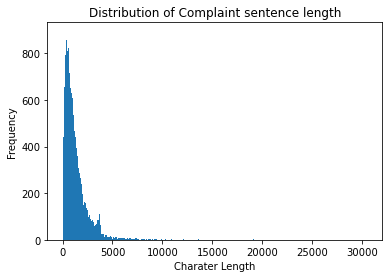

In [271]:
import matplotlib.pyplot as plt
plt.hist(sentence_lengths, bins=500)
plt.xlabel("Charater Length")
plt.ylabel("Frequency")
plt.title("Distribution of Complaint sentence length")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

morning name xxxx xxxx stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account thank advance help card agent anniversary date agent information order account xxxx anniversary date xxxxxxxx consent xxxx recording agent card application identity consent service credit identity applicant xxxx ticket offer ticket reward card information offer minute screen decision bank notification screen chase representative application information offer credit offer account statement ticket account application representative application request application representative chase fact credit account name credit report chase information credit report application error son check chase account fund chase account money son check money chase bank money son time check owner country time date number xxxx claim number chase inquiry notice account debit card branch customer service representative account branch fund deposit place employment bank as

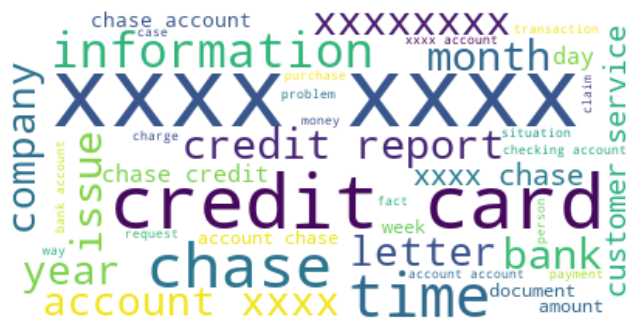

In [272]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

text = " ".join([ review for review in df_clean["complaint_POS_removed"] ])
print(text[0:1000])

# Blank Image file to be opened and converted into numpy array
image = Image.open("Blank.jpg")
# Convert the image to a numpy array
image_array = np.array(image)

# Generate the word cloud
wordcloud = WordCloud(background_color='white', max_words=40, stopwords=STOPWORDS).generate(text)

# Create a new figure and plot the word cloud
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Display the word cloud
plt.show()

In [273]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [274]:
print(df_clean["Complaint_clean"])

row_number
0        morning name xxxx xxxx stop bank car...
1        card agent anniversary date agent in...
2        card application identity consent se...
3        xxxx ticket offer ticket reward card...
4        son check chase account fund chase a...
                          ...                   
21067    chase card customer decade solicitat...
21068    credit card provider claim purchase ...
21069    pay risk consumer chase bank chase y...
21070    credit chase credit card freedom xxx...
21071    year account xxxx order line credit ...
Name: Complaint_clean, Length: 21072, dtype: object


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [275]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
import nltk 
from nltk import word_tokenize
from nltk.util import ngrams

tokens = word_tokenize(text)


In [276]:
#Print the top 10 words in the unigram frequency
unigrams = list(ngrams(tokens, 1))
unifreq = nltk.FreqDist(unigrams)
print(unifreq)

uni_dict = dict(sorted(unifreq.items(), key=lambda item: item[1], reverse=True))
uni_dict = dict(list(uni_dict.items())[:10])

<FreqDist with 15353 samples and 1166702 outcomes>


In [277]:
for k,v in uni_dict.items():
    print(k,v)

('xxxx',) 87493
('chase',) 49404
('account',) 47597
('credit',) 32623
('card',) 29937
('payment',) 21124
('bank',) 17184
('time',) 16003
('day',) 12945
('charge',) 12106


In [278]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigrams = list(ngrams(tokens, 2))
bifreq = nltk.FreqDist(bigrams)
print(bifreq)

bi_dict = dict(sorted(bifreq.items(), key=lambda item: item[1], reverse=True))
bi_dict = dict(list(bi_dict.items())[:30])


<FreqDist with 269476 samples and 1166701 outcomes>


In [279]:
#Print the top 10 words in the bigram frequency
bi_dict_10 = dict(list(bi_dict.items())[:10])
for k,v in bi_dict_10.items():
    print(k,v)

('xxxx', 'xxxx') 23818
('credit', 'card') 12842
('credit', 'report') 3842
('account', 'xxxx') 3185
('xxxx', 'chase') 3112
('customer', 'service') 3082
('chase', 'credit') 3081
('chase', 'account') 2970
('account', 'chase') 2932
('checking', 'account') 2604


In [280]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigrams = list(ngrams(tokens, 3))
trifreq = nltk.FreqDist(trigrams)

print(trifreq)

tri_dict = dict(sorted(trifreq.items(), key=lambda item: item[1], reverse=True))
tri_dict = dict(list(tri_dict.items())[:30])

<FreqDist with 782458 samples and 1166700 outcomes>


In [281]:
#Print the top 10 words in the trigram frequency
tri_dict_10 = dict(list(tri_dict.items())[:10])
for k,v in tri_dict_10.items():
    print(k,v)

('xxxx', 'xxxx', 'xxxx') 6226
('chase', 'credit', 'card') 2134
('_', '_', '_') 1037
('credit', 'card', 'company') 993
('credit', 'card', 'account') 968
('account', 'xxxx', 'xxxx') 778
('xxxx', 'xxxx', 'chase') 771
('xxxx', 'credit', 'card') 755
('credit', 'card', 'xxxx') 697
('credit', 'card', 'chase') 652


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [282]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [283]:
#All masked texts has been removed
df_clean

Id                         clean_complaints  \
row_number                                                   
0               1  good morning my name is xxxx xxxx an...   
1               2  i upgraded my xxxx xxxx card in and ...   
2              10  chase card was reported on however f...   
3              11  on while trying to book a xxxx xxxx ...   
4              14  my grand son give me check for i dep...   
...           ...                                      ...   
21067       78303  after being a chase card customer fo...   
21068       78309  on wednesday xxxxxxxx i called chas ...   
21069       78310  i am not familiar with xxxx pay and ...   
21070       78311  i have had flawless credit for yrs i...   
21071       78312  roughly years ago i closed out my ac...   

                             clean_complaints_lemma  \
row_number                                            
0           good morning my name be xxxx xxxx an...   
1           I upgrade my xxxx xxxx card in and b...   
2           chase card be report on however frau...   
3           on while try to book a xxxx xxxx tic...   
4           my grand son give I check for I depo...   
...                                             ...   
21067       after be a chase card customer for w...   
21068       on wednesday xxxxxxxx I call chas my...   
21069       I be not familiar with xxxx pay and ...   
21070       I have have flawless credit for yrs ...   
21071       roughly year ago I close out my acco...   

                              complaint_POS_removed  \
row_number                                            
0           morning name xxxx xxxx stop bank car...   
1           card agent anniversary date agent in...   
2           card application identity consent se...   
3           xxxx ticket offer ticket reward card...   
4           son check chase account fund chase a...   
...                                             ...   
21067       chase card customer decade solicitat...   
21068       credit card provider claim purchase ...   
21069       pay risk consumer chase bank chase y...   
21070       credit chase credit card freedom xxx...   
21071       year account xxxx order line credit ...   

                                    Complaint_clean  
row_number                                           
0           morning name   stop bank cardmember ...  
1           card agent anniversary date agent in...  
2           card application identity consent se...  
3            ticket offer ticket reward card inf...  
4           son check chase account fund chase a...  
...                                             ...  
21067       chase card customer decade solicitat...  
21068       credit card provider claim purchase ...  
21069       pay risk consumer chase bank chase y...  
21070       credit chase credit card freedom  pr...  
21071       year account  order line credit acco...  

[21072 rows x 5 columns]

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [284]:
#Write your code here to initialise the TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [285]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
text = [ re.sub('\s+', ' ', review) for review in df_clean["Complaint_clean"] ]
text = [ re.sub('^\s+|\s+$', '', review) for review in text ]
print(text[9])
tfidf_matrix = tfidfvectorizer.fit_transform(text)
dense_matrix = tfidf_matrix.toarray()
feature_names = tfidfvectorizer.get_feature_names_out()
print(tfidf_matrix)
'''
print(dense_matrix, feature_names)
print(dense_matrix.shape)
print(len(feature_names))
print(df_clean.shape)

first_vector_tfidfvectorizer=tfidf_wm[9] 
tfidf_df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), 
                 index=tfidfvectorizer.get_feature_names_out(), columns=["tfidf"]) 
tfidf_df = tfidf_df.sort_values(by=["tfidf"],ascending=False)
print(first_vector_tfidfvectorizer)
print(tfidf_df)
'''

chase credit card datum credit report company issue
  (0, 6108)	0.1967160611303396
  (0, 300)	0.25488075461877385
  (0, 13176)	0.25300160619164525
  (0, 74)	0.07825471438538159
  (0, 2220)	0.07138643336993528
  (0, 2930)	0.17566148623161776
  (0, 6736)	0.12562830730344035
  (0, 11520)	0.2082004641416313
  (0, 8475)	0.12565931140807585
  (0, 7847)	0.1775548137036398
  (0, 12587)	0.15504065813889714
  (0, 14153)	0.24898049983722034
  (0, 3563)	0.5445092968448234
  (0, 11974)	0.13353068104125373
  (0, 1914)	0.3134548673511484
  (0, 1153)	0.2113298755803602
  (0, 12679)	0.2968990125106347
  (0, 8521)	0.22889542012326813
  (1, 10930)	0.25122926494784786
  (1, 2892)	0.23106692691099265
  (1, 9268)	0.1608442552722257
  (1, 3472)	0.27262762517905637
  (1, 621)	0.6641183035316673
  (1, 397)	0.5637212131254618
  (1, 1889)	0.08392116826143094
  :	:
  (21070, 13634)	0.3360370205262505
  (21070, 14712)	0.05487578672338146
  (21070, 9614)	0.38838519341165956
  (21070, 5113)	0.12510849335704743
  (21

'\nprint(dense_matrix, feature_names)\nprint(dense_matrix.shape)\nprint(len(feature_names))\nprint(df_clean.shape)\n\nfirst_vector_tfidfvectorizer=tfidf_wm[9] \ntfidf_df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), \n                 index=tfidfvectorizer.get_feature_names_out(), columns=["tfidf"]) \ntfidf_df = tfidf_df.sort_values(by=["tfidf"],ascending=False)\nprint(first_vector_tfidfvectorizer)\nprint(tfidf_df)\n'

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [286]:
from sklearn.decomposition import NMF

In [287]:
print(dense_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [288]:
#Load your nmf_model with the n_components i.e 5

num_topics = 5

#keep the random_state = 40
nmf_model = NMF(n_components=num_topics, init='random', random_state=40)

In [289]:
nmf_model.fit(dense_matrix)
len(feature_names)

14781

In [290]:
#Print the Top15 words for each of the topics
# Features Matrix
nmf_features = nmf_model.transform(dense_matrix)

# Components Matrix
components_df = pd.DataFrame(nmf_model.components_, 
                            columns=feature_names)

terms =  list(feature_names)

for topic in range(components_df.shape[0]):
    topic_df = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(topic_df.nlargest(15))
    print('\n')

For topic 1 the words with the highest value are:
account     8.013824
money       1.766349
bank        1.739885
chase       1.551522
checking    1.248407
fund        1.153369
branch      0.945758
fee         0.924720
balance     0.869244
deposit     0.827674
saving      0.745957
day         0.736046
number      0.724205
transfer    0.708962
business    0.673872
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
payment         5.659949
loan            3.135114
mortgage        2.577088
chase           1.560390
month           1.211570
home            1.132651
modification    1.108343
time            1.053376
year            0.974023
balance         0.749487
rate            0.749062
statement       0.665934
fee             0.663660
property        0.650388
day             0.627753
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
credit         6.363209
card           4.133911
report         2.664632
inquiry        2.267416
score       

In [291]:
print(components_df)

         aa  aaarating   aacount      aaoa      aarp    aaving        ab  \
0  0.001356   0.000000  0.000000  0.000000  0.000448  0.000398  0.000000   
1  0.000222   0.000845  0.000000  0.000000  0.000000  0.000004  0.001749   
2  0.000000   0.000000  0.000000  0.000657  0.020437  0.000000  0.000000   
3  0.001199   0.000247  0.000000  0.000213  0.016607  0.000111  0.000000   
4  0.000000   0.000009  0.004772  0.000000  0.000000  0.000019  0.000094   

        aba  abandonment  abatement  ...  zeroliability        zi     zilch  \
0  0.000845     0.000000   0.000000  ...       0.000000  0.000544  0.001420   
1  0.000000     0.001333   0.002146  ...       0.000343  0.000000  0.000334   
2  0.000000     0.000000   0.000000  ...       0.000000  0.000000  0.000000   
3  0.000000     0.000000   0.000000  ...       0.001017  0.000000  0.000184   
4  0.000000     0.000000   0.000477  ...       0.000000  0.000000  0.000000   

        zip   zipcode  zipcodeaddress    zombie      zone       zoo 

In [292]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

# temporarily creating topic tuple that I can think of
topic_list = ("account_issues", "loan", "credit_card_application", "credit_card_dispute", "money_transaction")


def get_descriptor( terms, H, topic_index, top ):
  # reverse sort the values to sort the indices
  top_indices = np.argsort( H.iloc[topic_index,:] )[::-1]

  # get the terms corresponding to the top-ranked indices
  top_terms = [ ]
  for term_index in top_indices[0:top]:
      top_terms.append( terms[term_index] )
  return top_terms

k = num_topics 
descriptors = [ ]
for topic_index in range(k):
  descriptors.append(get_descriptor(terms, components_df, topic_index, 10 ))
  str_descriptor = ", ".join( descriptors[topic_index] )
  print("Topic %02d %s : %s" % ( topic_index, topic_list[topic_index], str_descriptor ) )


Topic 00 account_issues : account, money, bank, chase, checking, fund, branch, fee, balance, deposit
Topic 01 loan : payment, loan, mortgage, chase, month, home, modification, time, year, balance
Topic 02 credit_card_application : credit, card, report, inquiry, score, chase, company, limit, application, balance
Topic 03 credit_card_dispute : charge, card, chase, transaction, dispute, claim, fraud, merchant, fee, purchase
Topic 04 money_transaction : check, bank, fund, money, deposit, day, branch, chase, hold, claim


In [293]:
print(df_clean.columns)

Index(['Id', 'clean_complaints', 'clean_complaints_lemma',
       'complaint_POS_removed', 'Complaint_clean'],
      dtype='object')


In [294]:
#Assign the best topic to each of the cmplaints in Topic Column

# Let us check one sample jth complaint.
j = 508
print(pd.DataFrame(nmf_features).loc[j])

predicted_topic = np.argmax(pd.DataFrame(nmf_features).loc[j])
topic_name = topic_list[int(predicted_topic)]
print("\n {}th Document belongs to Topic {} {} ".\
format(j, predicted_topic, topic_name))

pd.set_option('display.max_colwidth', None)
print(df_clean.iloc[j])
pd.set_option('display.max_colwidth', 40)

0    0.000000
1    0.000000
2    0.000000
3    0.015218
4    0.000000
Name: 508, dtype: float64

 508th Document belongs to Topic 3 credit_card_dispute 
Id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [295]:
#df_clean['Topic'] = #write your code to assign topics to each rows.
df_clean["Topic"] = df_clean.apply(lambda row: str(np.argmax(pd.DataFrame(nmf_features).loc[row.name])), axis=1)

In [296]:
df_clean.head()

Id                         clean_complaints  \
row_number                                                
0            1  good morning my name is xxxx xxxx an...   
1            2  i upgraded my xxxx xxxx card in and ...   
2           10  chase card was reported on however f...   
3           11  on while trying to book a xxxx xxxx ...   
4           14  my grand son give me check for i dep...   

                             clean_complaints_lemma  \
row_number                                            
0           good morning my name be xxxx xxxx an...   
1           I upgrade my xxxx xxxx card in and b...   
2           chase card be report on however frau...   
3           on while try to book a xxxx xxxx tic...   
4           my grand son give I check for I depo...   

                              complaint_POS_removed  \
row_number                                            
0           morning name xxxx xxxx stop bank car...   
1           card agent anniversary date agent in...   
2           card application identity consent se...   
3           xxxx ticket offer ticket reward card...   
4           son check chase account fund chase a...   

                                    Complaint_clean Topic  
row_number                                                 
0           morning name   stop bank cardmember ...     0  
1           card agent anniversary date agent in...     0  
2           card application identity consent se...     2  
3            ticket offer ticket reward card inf...     2  
4           son check chase account fund chase a...     4

In [297]:
#Print the first 5 Complaint for each of the Topics
df_clean_print=df_clean.groupby('Topic').head(5)
df_clean_print.sort_values('Topic')

Id                         clean_complaints  \
row_number                                                 
0             1  good morning my name is xxxx xxxx an...   
10           24  mishandling of this account by chase...   
6            17  with out notice jp morgan chase rest...   
12           27  i opened an account with chase bank ...   
1             2  i upgraded my xxxx xxxx card in and ...   
32           81  i bought a new xxxx xxxx on xxxxxxxx...   
7            20  during the summer months i experienc...   
24           58  i made a purchase of on xxxxxxxx i m...   
30           73  i have wired through one of chase br...   
23           57  i have been trying to do a loan modi...   
5            15            can you please remove inquiry   
2            10  chase card was reported on however f...   
9            23  i have a chase credit card which is ...   
11           26  i have reached out to xxxx several t...   
3            11  on while trying to book a xxxx xxxx ...   
19           45  i made a purchase with xxxx xxxx xxx...   
14           32  my chase amazon card was declined fo...   
13           30  to whom it may concern chase bank ch...   
8            21  on xxxx i made a payment to an onlin...   
16           40  xxxx xxxx a sofa love seat table and...   
51          131  for joining chase bank checking and ...   
4            14  my grand son give me check for i dep...   
52          133  on i made a deposit into my chase ba...   
46          115  multiple times with the latest being...   
58          142                                      NaN   

                             clean_complaints_lemma  \
row_number                                            
0           good morning my name be xxxx xxxx an...   
10          mishandle of this account by chase a...   
6           with out notice jp morgan chase rest...   
12          I open an account with chase bank on...   
1           I upgrade my xxxx xxxx card in and b...   
32          I buy a new xxxx xxxx on xxxxxxxx fr...   
7           during the summer month I experience...   
24          I make a purchase of on xxxxxxxx I m...   
30          I have wire through one of chase bra...   
23          I have be try to do a loan modificat...   
5                     can you please remove inquiry   
2           chase card be report on however frau...   
9           I have a chase credit card which be ...   
11          I have reach out to xxxx several tim...   
3           on while try to book a xxxx xxxx tic...   
19          I make a purchase with xxxx xxxx xxx...   
14          my chase amazon card be decline for ...   
13          to whom it may concern chase bank ch...   
8           on xxxx I make a payment to an onlin...   
16          xxxx xxxx a sofa love seat table and...   
51          for join chase bank checking and set...   
4           my grand son give I check for I depo...   
52          on I make a deposit into my chase ba...   
46          multiple time with the late be xxxxx...   
58                                              NaN   

                              complaint_POS_removed  \
row_number                                            
0           morning name xxxx xxxx stop bank car...   
10                                account auto xxxx   
6           notice account debit card branch cus...   
12          account xxxx code bonus xxxxxxxx ter...   
1           card agent anniversary date agent in...   
32          xxxx xxxx xxxx xxxx loan title chase...   
7           summer month decline income employme...   
24          purchase payment payment closing dat...   
30          branch xxxx reinstatement amount ord...   
23          loan modification chase runaround mo...   
5                                           inquiry   
2           card application identity consent se...   
9           chase credit card datum credit repor...   
11          time attempt inquiry creditor inquir...   
3           xxxx ticket of

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [298]:
#Create the dictionary of Topic names and Topics

Topic_names = {"0":"Bank Account services", "1":"Credit card or prepaid card" , "2":"Theft/Dispute Reporting",
              "3":"Mortgage/Loan", "4":"Others"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [299]:
df_clean

Id                         clean_complaints  \
row_number                                                   
0               1  good morning my name is xxxx xxxx an...   
1               2  i upgraded my xxxx xxxx card in and ...   
2              10  chase card was reported on however f...   
3              11  on while trying to book a xxxx xxxx ...   
4              14  my grand son give me check for i dep...   
...           ...                                      ...   
21067       78303  after being a chase card customer fo...   
21068       78309  on wednesday xxxxxxxx i called chas ...   
21069       78310  i am not familiar with xxxx pay and ...   
21070       78311  i have had flawless credit for yrs i...   
21071       78312  roughly years ago i closed out my ac...   

                             clean_complaints_lemma  \
row_number                                            
0           good morning my name be xxxx xxxx an...   
1           I upgrade my xxxx xxxx card in and b...   
2           chase card be report on however frau...   
3           on while try to book a xxxx xxxx tic...   
4           my grand son give I check for I depo...   
...                                             ...   
21067       after be a chase card customer for w...   
21068       on wednesday xxxxxxxx I call chas my...   
21069       I be not familiar with xxxx pay and ...   
21070       I have have flawless credit for yrs ...   
21071       roughly year ago I close out my acco...   

                              complaint_POS_removed  \
row_number                                            
0           morning name xxxx xxxx stop bank car...   
1           card agent anniversary date agent in...   
2           card application identity consent se...   
3           xxxx ticket offer ticket reward card...   
4           son check chase account fund chase a...   
...                                             ...   
21067       chase card customer decade solicitat...   
21068       credit card provider claim purchase ...   
21069       pay risk consumer chase bank chase y...   
21070       credit chase credit card freedom xxx...   
21071       year account xxxx order line credit ...   

                                    Complaint_clean  \
row_number                                            
0           morning name   stop bank cardmember ...   
1           card agent anniversary date agent in...   
2           card application identity consent se...   
3            ticket offer ticket reward card inf...   
4           son check chase account fund chase a...   
...                                             ...   
21067       chase card customer decade solicitat...   
21068       credit card provider claim purchase ...   
21069       pay risk consumer chase bank chase y...   
21070       credit chase credit card freedom  pr...   
21071       year account  order line credit acco...   

                                  Topic  
row_number                               
0                 Bank Account services  
1                 Bank Account services  
2               Theft/Dispute Reporting  
3               Theft/Dispute Reporting  
4                                Others  
...                                 ...  
21067                     Mortgage/Loan  
21068                     Mortgage/Loan  
21069                     Mortgage/Loan  
21070       Credit card or prepaid card  
21071       Credit card or prepaid card  

[21072 rows x 6 columns]

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [300]:
#Create the dictionary again of Topic names and Topics

Topic_names = { "Bank Account services":0, "Credit card or prepaid card":1 , "Theft/Dispute Reporting":2,
              "Mortgage/Loan":3, "Others":4 }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [301]:
df_clean

Id                         clean_complaints  \
row_number                                                   
0               1  good morning my name is xxxx xxxx an...   
1               2  i upgraded my xxxx xxxx card in and ...   
2              10  chase card was reported on however f...   
3              11  on while trying to book a xxxx xxxx ...   
4              14  my grand son give me check for i dep...   
...           ...                                      ...   
21067       78303  after being a chase card customer fo...   
21068       78309  on wednesday xxxxxxxx i called chas ...   
21069       78310  i am not familiar with xxxx pay and ...   
21070       78311  i have had flawless credit for yrs i...   
21071       78312  roughly years ago i closed out my ac...   

                             clean_complaints_lemma  \
row_number                                            
0           good morning my name be xxxx xxxx an...   
1           I upgrade my xxxx xxxx card in and b...   
2           chase card be report on however frau...   
3           on while try to book a xxxx xxxx tic...   
4           my grand son give I check for I depo...   
...                                             ...   
21067       after be a chase card customer for w...   
21068       on wednesday xxxxxxxx I call chas my...   
21069       I be not familiar with xxxx pay and ...   
21070       I have have flawless credit for yrs ...   
21071       roughly year ago I close out my acco...   

                              complaint_POS_removed  \
row_number                                            
0           morning name xxxx xxxx stop bank car...   
1           card agent anniversary date agent in...   
2           card application identity consent se...   
3           xxxx ticket offer ticket reward card...   
4           son check chase account fund chase a...   
...                                             ...   
21067       chase card customer decade solicitat...   
21068       credit card provider claim purchase ...   
21069       pay risk consumer chase bank chase y...   
21070       credit chase credit card freedom xxx...   
21071       year account xxxx order line credit ...   

                                    Complaint_clean  Topic  
row_number                                                  
0           morning name   stop bank cardmember ...      0  
1           card agent anniversary date agent in...      0  
2           card application identity consent se...      2  
3            ticket offer ticket reward card inf...      2  
4           son check chase account fund chase a...      4  
...                                             ...    ...  
21067       chase card customer decade solicitat...      3  
21068       credit card provider claim purchase ...      3  
21069       pay risk consumer chase bank chase y...      3  
21070       credit chase credit card freedom  pr...      1  
21071       year account  order line credit acco...      1  

[21072 rows x 6 columns]

In [302]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["clean_complaints", "Topic"]]

In [303]:
training_data
print(training_data.shape)

(21072, 2)


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [304]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [305]:
# Write your code here to build any 3 models and evaluate them using the required metrics



